In [44]:
import math
import csv
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import sys
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
from keras import backend as K

# tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.list_physical_devices(device_type=None)
# config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 4} ) 

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

In [3]:
print("Python version: ", sys.version)
print("Keras version: ", keras.__version__)
print("Tensorflow version: ", tf.__version__)

Python version:  3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 21:14:29) 
[GCC 7.3.0]
Keras version:  2.3.1
Tensorflow version:  2.1.0


In [4]:
seed = 1234
epoch = 40
batch_size = 50
folds = 10

# SET Hyper Parameters on a small dataset

In [5]:
#reproducibility
np.random.seed(seed)

#digits 1...9
D = 9

#percentage of whole data used as training
percent_train = 0.8

fname = "secretkeys_exe-b.csv"
dataset = np.loadtxt(fname, delimiter = ',', dtype = int)
N = len(dataset)

In [6]:
#now  we need to extract data and labels
s = dataset[:,0]     #string of first keys
y = dataset[:,-1]   #last column, 1 if key is present, 0 if not

#lenght of a string
L = len(str(s[0]))

#dimension of data sample
LD = L*D

#see how many samples we use for training
N_train = int(percent_train * N)

print(f'data: {N}')                         #must be 1000 as we generated it before
print(f'lenght of string: {L}')             #must be 6 because each keys is 6 digits long
print(f'dimension of my data sample: {LD}') #must be L*D = 6*9 = 54 
print(f'dimension of my training dataset: {N_train}') 

data: 3000
lenght of string: 7
dimension of my data sample: 63
dimension of my training dataset: 2400


In [7]:
def expand(S):
    if(len(str(S))!=L):
        print('mismatch!')
        return[]
    
    x = [0] * LD
    p = 10**(L-1)
    j = 0
    while (j < L):
        q = int(S/p) #in this way we obtained the first digit
        
        # 1...9 ---> 0...8
        x[j*D + (q-1)] = 1
        j += 1
        S = S - q*p
        p = int(p/10)
    return x

In [8]:
#Split into training and test data

x_all = [None] * N

for i in range(N):
    x_all[i] = expand(s[i])

print(x_all[0]) #it must be the first one in the cell above

#split into train and test
x_train, y_train = x_all[0:N_train], y[0:N_train]
x_test , y_test  = x_all[N_train:] , y[N_train:]

print(len(x_train), '\t', len(x_test)) #should be 

#KERAS WANTS AS INPUT np.array()
x_train = np.array(x_train)                  # <--- we'd need to do this if the input data weren't of this kind
y_train = np.array(y_train)                  
x_test = np.array(x_test)                  
y_test = np.array(y_test)

print(x_train, np.shape(x_train))

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
2400 	 600
[[0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]] (2400, 63)


# GRID SEARCH CV

In [9]:
def create_model(activations = 'relu',
                 drop_out = 0.2,
                 optimizer = 'adam',
                regularizer = 1.):
    np.random.seed(seed)
    model = Sequential()

    model.add(Dense(LD, input_shape = (LD,), activation = activations, activity_regularizer=l2(regularizer) )) #layer 0
    model.add(Dense(max(10, int(LD/2)), activation = activations, activity_regularizer=l2(regularizer))) #layer 1
    model.add(Dense(max(6, int(LD/4)), activation = activations, activity_regularizer=l2(regularizer))) #layer 2
 
    model.add(Dropout(drop_out))

    model.add(Dense((1), activation = 'sigmoid')) #final node
    model.compile(loss='binary_crossentropy', optimizer = str(optimizer), metrics=['accuracy'])
    
    return model

# START

In [10]:
#find best regularization parameter
optimizers  = { 'regularizer'  : [0.01, 0.05, 0.1],
              'optimizer' : ['RMSprop', 'Adam', 'Nadam', 'Adamax']}

grid = GridSearchCV(estimator = KerasClassifier(build_fn=create_model, epochs=epoch, batch_size=batch_size),
                    param_grid= optimizers,  
                    n_jobs=1,
                    cv = folds)
grid.fit(x_train,y_train, shuffle = 1 )

Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 1s 456us/sample - loss: 0.6345 - accuracy: 0.7389
Epoch 2/40
2160/2160 [==============================] - 0s 65us/sample - loss: 0.5641 - accuracy: 0.7620
Epoch 3/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.5290 - accuracy: 0.7625
Epoch 4/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.4972 - accuracy: 0.7644
Epoch 5/40
2160/2160 [==============================] - 0s 57us/sample - loss: 0.4700 - accuracy: 0.7759
Epoch 6/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.4381 - accuracy: 0.7963
Epoch 7/40
2160/2160 [==============================] - 0s 63us/sample - loss: 0.4095 - accuracy: 0.8310
Epoch 8/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.3758 - accuracy: 0.8685
Epoch 9/40
2160/2160 [==============================] - 0s 56us/sample - loss: 0.3369 - accuracy: 0.8870
Epoch 10/40
2160/2160 [=========

2160/2160 [==============================] - 0s 55us/sample - loss: 0.0370 - accuracy: 1.0000
Epoch 32/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.0354 - accuracy: 1.0000
Epoch 33/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.0336 - accuracy: 1.0000
Epoch 34/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.0321 - accuracy: 1.0000
Epoch 35/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.0305 - accuracy: 1.0000
Epoch 36/40
2160/2160 [==============================] - 0s 57us/sample - loss: 0.0288 - accuracy: 1.0000
Epoch 37/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.0281 - accuracy: 1.0000
Epoch 38/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.0279 - accuracy: 1.0000
Epoch 39/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.0262 - accuracy: 0.9995
Epoch 40/40
240/240 [==============================] - 0s 

2160/2160 [==============================] - 0s 63us/sample - loss: 0.0716 - accuracy: 1.0000
Epoch 22/40
2160/2160 [==============================] - 0s 66us/sample - loss: 0.0665 - accuracy: 0.9995
Epoch 23/40
2160/2160 [==============================] - 0s 75us/sample - loss: 0.0632 - accuracy: 0.9995
Epoch 24/40
2160/2160 [==============================] - 0s 61us/sample - loss: 0.0583 - accuracy: 1.0000
Epoch 25/40
2160/2160 [==============================] - 0s 68us/sample - loss: 0.0555 - accuracy: 0.9995
Epoch 26/40
2160/2160 [==============================] - 0s 63us/sample - loss: 0.0529 - accuracy: 0.9995
Epoch 27/40
2160/2160 [==============================] - 0s 60us/sample - loss: 0.0491 - accuracy: 1.0000
Epoch 28/40
2160/2160 [==============================] - 0s 60us/sample - loss: 0.0461 - accuracy: 1.0000
Epoch 29/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.0442 - accuracy: 1.0000
Epoch 30/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 39us/sample - loss: 0.3216 - accuracy: 0.9537
Epoch 12/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.2914 - accuracy: 0.9630
Epoch 13/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.2592 - accuracy: 0.9750
Epoch 14/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.2358 - accuracy: 0.9819
Epoch 15/40
2160/2160 [==============================] - 0s 56us/sample - loss: 0.2151 - accuracy: 0.9880
Epoch 16/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.1924 - accuracy: 0.9926
Epoch 17/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.1777 - accuracy: 0.9935
Epoch 18/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.1629 - accuracy: 0.9958
Epoch 19/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.1514 - accuracy: 0.9968
Epoch 20/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 1s 286us/sample - loss: 0.7622 - accuracy: 0.7134
Epoch 2/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.6410 - accuracy: 0.7653
Epoch 3/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.5874 - accuracy: 0.7653
Epoch 4/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.5566 - accuracy: 0.7653
Epoch 5/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.5258 - accuracy: 0.7704
Epoch 6/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.4927 - accuracy: 0.7912
Epoch 7/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.4560 - accuracy: 0.8259
Epoch 8/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.4135 - accuracy: 0.8792
Epoch 9/40
2160/2160 [==============================] - 0s 60us/sample - loss: 0.3804 - accuracy: 0.9106
Epoch 10/40
2160/2160 [==============================] - 0s 42us/

2160/2160 [==============================] - 0s 44us/sample - loss: 0.0872 - accuracy: 1.0000
Epoch 33/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.0833 - accuracy: 1.0000
Epoch 34/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.0812 - accuracy: 1.0000
Epoch 35/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.0775 - accuracy: 1.0000
Epoch 36/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.0738 - accuracy: 1.0000
Epoch 37/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.0729 - accuracy: 1.0000
Epoch 38/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.0694 - accuracy: 1.0000
Epoch 39/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.0686 - accuracy: 1.0000
Epoch 40/40
240/240 [==============================] - 0s 445us/sample - loss: 0.5702 - accuracy: 0.8125
Train on 2160 samples
Epoch 1/40
2160/2160 [===============

2160/2160 [==============================] - 0s 46us/sample - loss: 0.3028 - accuracy: 0.9755
Epoch 23/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.2940 - accuracy: 0.9792
Epoch 24/40
2160/2160 [==============================] - 0s 36us/sample - loss: 0.2850 - accuracy: 0.9847
Epoch 25/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.2766 - accuracy: 0.9884
Epoch 26/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.2707 - accuracy: 0.9898
Epoch 27/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.2626 - accuracy: 0.9912
Epoch 28/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.2556 - accuracy: 0.9931
Epoch 29/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.2479 - accuracy: 0.9935
Epoch 30/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.2405 - accuracy: 0.9940
Epoch 31/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 41us/sample - loss: 0.4903 - accuracy: 0.7551
Epoch 13/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.4733 - accuracy: 0.7551
Epoch 14/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.4609 - accuracy: 0.7551
Epoch 15/40
2160/2160 [==============================] - 0s 36us/sample - loss: 0.4461 - accuracy: 0.7551
Epoch 16/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.4307 - accuracy: 0.7551
Epoch 17/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.4194 - accuracy: 0.7556
Epoch 18/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.4029 - accuracy: 0.7574
Epoch 19/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.3876 - accuracy: 0.8005
Epoch 20/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.3716 - accuracy: 0.9185
Epoch 21/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 46us/sample - loss: 0.5946 - accuracy: 0.7611
Epoch 3/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.5548 - accuracy: 0.7639
Epoch 4/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.5254 - accuracy: 0.7731
Epoch 5/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.4937 - accuracy: 0.7935
Epoch 6/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.4617 - accuracy: 0.8176
Epoch 7/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.4171 - accuracy: 0.8565
Epoch 8/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.3596 - accuracy: 0.8889
Epoch 9/40
2160/2160 [==============================] - 0s 55us/sample - loss: 0.2982 - accuracy: 0.9333
Epoch 10/40
2160/2160 [==============================] - 0s 53us/sample - loss: 0.2350 - accuracy: 0.9611
Epoch 11/40
2160/2160 [==============================] - 0s 45us/

2160/2160 [==============================] - 0s 45us/sample - loss: 0.0541 - accuracy: 0.9991
Epoch 34/40
2160/2160 [==============================] - 0s 54us/sample - loss: 0.0521 - accuracy: 0.9991
Epoch 35/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.0501 - accuracy: 1.0000
Epoch 36/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.0489 - accuracy: 1.0000
Epoch 37/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.0492 - accuracy: 0.9995
Epoch 38/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.0477 - accuracy: 1.0000
Epoch 39/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.0484 - accuracy: 0.9995
Epoch 40/40
240/240 [==============================] - 0s 662us/sample - loss: 0.3223 - accuracy: 0.9000
Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 1s 361us/sample - loss: 0.7069 - accuracy: 0.6074
Epoch 2/40
2160/2160 [===============

2160/2160 [==============================] - 0s 57us/sample - loss: 0.0684 - accuracy: 0.9995
Epoch 24/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.0655 - accuracy: 1.0000
Epoch 25/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.0640 - accuracy: 1.0000
Epoch 26/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.0621 - accuracy: 0.9995
Epoch 27/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.0599 - accuracy: 1.0000
Epoch 28/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.0583 - accuracy: 1.0000
Epoch 29/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.0568 - accuracy: 1.0000
Epoch 30/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.0551 - accuracy: 1.0000
Epoch 31/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.0538 - accuracy: 0.9995
Epoch 32/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 41us/sample - loss: 0.1982 - accuracy: 0.9977
Epoch 14/40
2160/2160 [==============================] - 0s 53us/sample - loss: 0.1849 - accuracy: 0.9986
Epoch 15/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.1717 - accuracy: 1.0000
Epoch 16/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.1619 - accuracy: 1.0000
Epoch 17/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.1543 - accuracy: 1.0000
Epoch 18/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.1463 - accuracy: 1.0000
Epoch 19/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.1402 - accuracy: 1.0000
Epoch 20/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.1373 - accuracy: 1.0000
Epoch 21/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.1294 - accuracy: 1.0000
Epoch 22/40
2160/2160 [==============================] - 0

Epoch 8/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.4220 - accuracy: 0.8435
Epoch 9/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.3755 - accuracy: 0.9056
Epoch 10/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.3281 - accuracy: 0.9519
Epoch 11/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.2856 - accuracy: 0.9769
Epoch 12/40
2160/2160 [==============================] - 0s 57us/sample - loss: 0.2535 - accuracy: 0.9894
Epoch 13/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.2255 - accuracy: 0.9926
Epoch 14/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.2075 - accuracy: 0.9949
Epoch 15/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.1918 - accuracy: 0.9977
Epoch 16/40
2160/2160 [==============================] - 0s 36us/sample - loss: 0.1818 - accuracy: 0.9986
Epoch 17/40
2160/2160 [=========================

2160/2160 [==============================] - 0s 51us/sample - loss: 0.0776 - accuracy: 1.0000
Epoch 40/40
240/240 [==============================] - 0s 690us/sample - loss: 0.2385 - accuracy: 0.8958
Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 1s 318us/sample - loss: 0.7785 - accuracy: 0.7528
Epoch 2/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.6475 - accuracy: 0.7620
Epoch 3/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.5906 - accuracy: 0.7620
Epoch 4/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.5553 - accuracy: 0.7620
Epoch 5/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.5229 - accuracy: 0.7620
Epoch 6/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.4960 - accuracy: 0.7620
Epoch 7/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.4633 - accuracy: 0.7620
Epoch 8/40
2160/2160 [=====================

2160/2160 [==============================] - 0s 58us/sample - loss: 0.1364 - accuracy: 0.9995
Epoch 30/40
2160/2160 [==============================] - 0s 53us/sample - loss: 0.1354 - accuracy: 0.9991
Epoch 31/40
2160/2160 [==============================] - 0s 56us/sample - loss: 0.1299 - accuracy: 0.9991
Epoch 32/40
2160/2160 [==============================] - 0s 61us/sample - loss: 0.1275 - accuracy: 0.9995
Epoch 33/40
2160/2160 [==============================] - 0s 59us/sample - loss: 0.1260 - accuracy: 0.9991
Epoch 34/40
2160/2160 [==============================] - 0s 57us/sample - loss: 0.1228 - accuracy: 0.9995
Epoch 35/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.1204 - accuracy: 0.9991
Epoch 36/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.1201 - accuracy: 0.9991
Epoch 37/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.1164 - accuracy: 0.9991
Epoch 38/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 45us/sample - loss: 0.2339 - accuracy: 0.9861
Epoch 20/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.2209 - accuracy: 0.9889
Epoch 21/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.2142 - accuracy: 0.9880
Epoch 22/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.2014 - accuracy: 0.9912
Epoch 23/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.1929 - accuracy: 0.9907
Epoch 24/40
2160/2160 [==============================] - 0s 36us/sample - loss: 0.1871 - accuracy: 0.9944
Epoch 25/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.1799 - accuracy: 0.9944
Epoch 26/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.1728 - accuracy: 0.9981
Epoch 27/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.1684 - accuracy: 0.9977
Epoch 28/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 49us/sample - loss: 0.4507 - accuracy: 0.7620
Epoch 10/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.4107 - accuracy: 0.7903
Epoch 11/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.3710 - accuracy: 0.8861
Epoch 12/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.3349 - accuracy: 0.9407
Epoch 13/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.3010 - accuracy: 0.9681
Epoch 14/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.2729 - accuracy: 0.9778
Epoch 15/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.2494 - accuracy: 0.9824
Epoch 16/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.2325 - accuracy: 0.9819
Epoch 17/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.2199 - accuracy: 0.9833
Epoch 18/40
2160/2160 [==============================] - 0

240/240 [==============================] - 0s 430us/sample - loss: 0.2846 - accuracy: 0.9000
Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 1s 508us/sample - loss: 0.6418 - accuracy: 0.7204
Epoch 2/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.5684 - accuracy: 0.7620
Epoch 3/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.5252 - accuracy: 0.7625
Epoch 4/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.4881 - accuracy: 0.7773
Epoch 5/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.4559 - accuracy: 0.8111
Epoch 6/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.4131 - accuracy: 0.8384
Epoch 7/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.3680 - accuracy: 0.8722
Epoch 8/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.3101 - accuracy: 0.9167
Epoch 9/40
2160/2160 [======================

2160/2160 [==============================] - 0s 39us/sample - loss: 0.0517 - accuracy: 1.0000
Epoch 31/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.0510 - accuracy: 0.9995
Epoch 32/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.0497 - accuracy: 1.0000
Epoch 33/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.0475 - accuracy: 1.0000
Epoch 34/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.0466 - accuracy: 0.9995
Epoch 35/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.0460 - accuracy: 1.0000
Epoch 36/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.0447 - accuracy: 0.9995
Epoch 37/40
2160/2160 [==============================] - 0s 36us/sample - loss: 0.0435 - accuracy: 0.9995
Epoch 38/40
2160/2160 [==============================] - 0s 36us/sample - loss: 0.0426 - accuracy: 1.0000
Epoch 39/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 41us/sample - loss: 0.0743 - accuracy: 1.0000
Epoch 21/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.0716 - accuracy: 1.0000
Epoch 22/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.0690 - accuracy: 1.0000
Epoch 23/40
2160/2160 [==============================] - 0s 56us/sample - loss: 0.0660 - accuracy: 1.0000
Epoch 24/40
2160/2160 [==============================] - 0s 53us/sample - loss: 0.0649 - accuracy: 1.0000
Epoch 25/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.0637 - accuracy: 1.0000
Epoch 26/40
2160/2160 [==============================] - 0s 59us/sample - loss: 0.0600 - accuracy: 1.0000
Epoch 27/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.0589 - accuracy: 1.0000
Epoch 28/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.0569 - accuracy: 1.0000
Epoch 29/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 46us/sample - loss: 0.3412 - accuracy: 0.9361
Epoch 11/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.2949 - accuracy: 0.9644
Epoch 12/40
2160/2160 [==============================] - 0s 60us/sample - loss: 0.2564 - accuracy: 0.9847
Epoch 13/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.2241 - accuracy: 0.9935
Epoch 14/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.1993 - accuracy: 0.9972
Epoch 15/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.1816 - accuracy: 0.9977
Epoch 16/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.1689 - accuracy: 0.9981
Epoch 17/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.1573 - accuracy: 0.9986
Epoch 18/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.1470 - accuracy: 0.9991
Epoch 19/40
2160/2160 [==============================] - 0

240/240 [==============================] - 0s 579us/sample - loss: 0.3957 - accuracy: 0.8542
Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 1s 375us/sample - loss: 0.7935 - accuracy: 0.6764
Epoch 2/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.6440 - accuracy: 0.7620
Epoch 3/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.5872 - accuracy: 0.7620
Epoch 4/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.5494 - accuracy: 0.7620
Epoch 5/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.5149 - accuracy: 0.7620
Epoch 6/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.4788 - accuracy: 0.7741
Epoch 7/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.4352 - accuracy: 0.8356
Epoch 8/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.3834 - accuracy: 0.8954
Epoch 9/40
2160/2160 [======================

2160/2160 [==============================] - 0s 49us/sample - loss: 0.1822 - accuracy: 0.9856
Epoch 32/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.1737 - accuracy: 0.9903
Epoch 33/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.1648 - accuracy: 0.9944
Epoch 34/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.1639 - accuracy: 0.9940
Epoch 35/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.1603 - accuracy: 0.9931
Epoch 36/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.1589 - accuracy: 0.9921
Epoch 37/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.1546 - accuracy: 0.9921
Epoch 38/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.1542 - accuracy: 0.9894
Epoch 39/40
2160/2160 [==============================] - 0s 53us/sample - loss: 0.1521 - accuracy: 0.9880
Epoch 40/40
240/240 [==============================] - 0s 

2160/2160 [==============================] - 0s 43us/sample - loss: 0.1812 - accuracy: 0.9995
Epoch 22/40
2160/2160 [==============================] - 0s 36us/sample - loss: 0.1752 - accuracy: 0.9995
Epoch 23/40
2160/2160 [==============================] - 0s 36us/sample - loss: 0.1703 - accuracy: 0.9995
Epoch 24/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.1654 - accuracy: 0.9986
Epoch 25/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.1586 - accuracy: 0.9986
Epoch 26/40
2160/2160 [==============================] - 0s 35us/sample - loss: 0.1550 - accuracy: 0.9986
Epoch 27/40
2160/2160 [==============================] - 0s 33us/sample - loss: 0.1507 - accuracy: 0.9991
Epoch 28/40
2160/2160 [==============================] - 0s 35us/sample - loss: 0.1453 - accuracy: 0.9995
Epoch 29/40
2160/2160 [==============================] - 0s 35us/sample - loss: 0.1406 - accuracy: 0.9995
Epoch 30/40
2160/2160 [==============================] - 0

Epoch 11/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.4422 - accuracy: 0.7620
Epoch 12/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.4156 - accuracy: 0.7620
Epoch 13/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.3919 - accuracy: 0.7806
Epoch 14/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.3691 - accuracy: 0.8958
Epoch 15/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.3481 - accuracy: 0.9296
Epoch 16/40
2160/2160 [==============================] - 0s 36us/sample - loss: 0.3248 - accuracy: 0.9426
Epoch 17/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.3031 - accuracy: 0.9486
Epoch 18/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.2840 - accuracy: 0.9426
Epoch 19/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.2642 - accuracy: 0.9653
Epoch 20/40
2160/2160 [=======================

2160/2160 [==============================] - 1s 277us/sample - loss: 0.6668 - accuracy: 0.7194
Epoch 2/40
2160/2160 [==============================] - 0s 36us/sample - loss: 0.6037 - accuracy: 0.7597
Epoch 3/40
2160/2160 [==============================] - 0s 34us/sample - loss: 0.5853 - accuracy: 0.7606
Epoch 4/40
2160/2160 [==============================] - 0s 34us/sample - loss: 0.5707 - accuracy: 0.7602
Epoch 5/40
2160/2160 [==============================] - 0s 33us/sample - loss: 0.5568 - accuracy: 0.7597
Epoch 6/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.5395 - accuracy: 0.7606
Epoch 7/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.5303 - accuracy: 0.7616
Epoch 8/40
2160/2160 [==============================] - 0s 55us/sample - loss: 0.5198 - accuracy: 0.7639
Epoch 9/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.5091 - accuracy: 0.7657
Epoch 10/40
2160/2160 [==============================] - 0s 36us/

2160/2160 [==============================] - 0s 61us/sample - loss: 0.2790 - accuracy: 0.9255
Epoch 33/40
2160/2160 [==============================] - 0s 63us/sample - loss: 0.2658 - accuracy: 0.9315
Epoch 34/40
2160/2160 [==============================] - 0s 54us/sample - loss: 0.2525 - accuracy: 0.9403
Epoch 35/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.2460 - accuracy: 0.9435
Epoch 36/40
2160/2160 [==============================] - 0s 55us/sample - loss: 0.2324 - accuracy: 0.9463
Epoch 37/40
2160/2160 [==============================] - 0s 54us/sample - loss: 0.2220 - accuracy: 0.9542
Epoch 38/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.2151 - accuracy: 0.9565
Epoch 39/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.2039 - accuracy: 0.9625
Epoch 40/40
240/240 [==============================] - 0s 662us/sample - loss: 0.4303 - accuracy: 0.8167
Train on 2160 samples
Epoch 1/40
2160/2160 [===============

2160/2160 [==============================] - 0s 43us/sample - loss: 0.3828 - accuracy: 0.8630
Epoch 23/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.3723 - accuracy: 0.8796
Epoch 24/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.3599 - accuracy: 0.8819
Epoch 25/40
2160/2160 [==============================] - 0s 53us/sample - loss: 0.3476 - accuracy: 0.8968
Epoch 26/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.3301 - accuracy: 0.9037
Epoch 27/40
2160/2160 [==============================] - 0s 56us/sample - loss: 0.3239 - accuracy: 0.9056
Epoch 28/40
2160/2160 [==============================] - 0s 65us/sample - loss: 0.3056 - accuracy: 0.9185
Epoch 29/40
2160/2160 [==============================] - 0s 61us/sample - loss: 0.2938 - accuracy: 0.9329
Epoch 30/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.2802 - accuracy: 0.9356
Epoch 31/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 46us/sample - loss: 0.5428 - accuracy: 0.7685
Epoch 13/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.5318 - accuracy: 0.7685
Epoch 14/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.5246 - accuracy: 0.7685
Epoch 15/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.5150 - accuracy: 0.7685
Epoch 16/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.5041 - accuracy: 0.7685
Epoch 17/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.4925 - accuracy: 0.7685
Epoch 18/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.4825 - accuracy: 0.7685
Epoch 19/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.4717 - accuracy: 0.7685
Epoch 20/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.4641 - accuracy: 0.7685
Epoch 21/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 36us/sample - loss: 0.7182 - accuracy: 0.7616
Epoch 3/40
2160/2160 [==============================] - 0s 34us/sample - loss: 0.6738 - accuracy: 0.7620
Epoch 4/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.6457 - accuracy: 0.7620
Epoch 5/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.6239 - accuracy: 0.7620
Epoch 6/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.6095 - accuracy: 0.7620
Epoch 7/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.5970 - accuracy: 0.7620
Epoch 8/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.5834 - accuracy: 0.7620
Epoch 9/40
2160/2160 [==============================] - 0s 62us/sample - loss: 0.5710 - accuracy: 0.7620
Epoch 10/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.5645 - accuracy: 0.7620
Epoch 11/40
2160/2160 [==============================] - 0s 54us/

2160/2160 [==============================] - 0s 50us/sample - loss: 0.4213 - accuracy: 0.7634
Epoch 34/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.4134 - accuracy: 0.7657
Epoch 35/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.4085 - accuracy: 0.7667
Epoch 36/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.3983 - accuracy: 0.7713
Epoch 37/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.3884 - accuracy: 0.7847
Epoch 38/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.3807 - accuracy: 0.7977
Epoch 39/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.3727 - accuracy: 0.8310
Epoch 40/40
240/240 [==============================] - 0s 685us/sample - loss: 0.4438 - accuracy: 0.8292
Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 1s 597us/sample - loss: 0.9900 - accuracy: 0.6801
Epoch 2/40
2160/2160 [===============

2160/2160 [==============================] - 0s 59us/sample - loss: 0.4417 - accuracy: 0.7606
Epoch 29/40
2160/2160 [==============================] - 0s 62us/sample - loss: 0.4327 - accuracy: 0.7606
Epoch 30/40
2160/2160 [==============================] - 0s 60us/sample - loss: 0.4224 - accuracy: 0.7606
Epoch 31/40
2160/2160 [==============================] - 0s 61us/sample - loss: 0.4151 - accuracy: 0.7634
Epoch 32/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.4049 - accuracy: 0.7685
Epoch 33/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.3958 - accuracy: 0.7782
Epoch 34/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.3865 - accuracy: 0.7968
Epoch 35/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.3791 - accuracy: 0.8093
Epoch 36/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.3709 - accuracy: 0.8361
Epoch 37/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 67us/sample - loss: 0.5810 - accuracy: 0.7551
Epoch 19/40
2160/2160 [==============================] - 0s 67us/sample - loss: 0.5754 - accuracy: 0.7551
Epoch 20/40
2160/2160 [==============================] - 0s 66us/sample - loss: 0.5718 - accuracy: 0.7551
Epoch 21/40
2160/2160 [==============================] - 0s 59us/sample - loss: 0.5685 - accuracy: 0.7551
Epoch 22/40
2160/2160 [==============================] - 0s 54us/sample - loss: 0.5616 - accuracy: 0.7551
Epoch 23/40
2160/2160 [==============================] - 0s 59us/sample - loss: 0.5547 - accuracy: 0.7551
Epoch 24/40
2160/2160 [==============================] - 0s 67us/sample - loss: 0.5498 - accuracy: 0.7551
Epoch 25/40
2160/2160 [==============================] - 0s 66us/sample - loss: 0.5428 - accuracy: 0.7551
Epoch 26/40
2160/2160 [==============================] - 0s 70us/sample - loss: 0.5356 - accuracy: 0.7551
Epoch 27/40
2160/2160 [==============================] - 0

2400/2400 [==============================] - 0s 42us/sample - loss: 0.3177 - accuracy: 0.9154
Epoch 9/40
2400/2400 [==============================] - 0s 38us/sample - loss: 0.2522 - accuracy: 0.9550
Epoch 10/40
2400/2400 [==============================] - 0s 35us/sample - loss: 0.1929 - accuracy: 0.9825
Epoch 11/40
2400/2400 [==============================] - 0s 34us/sample - loss: 0.1538 - accuracy: 0.9917
Epoch 12/40
2400/2400 [==============================] - 0s 32us/sample - loss: 0.1326 - accuracy: 0.9958
Epoch 13/40
2400/2400 [==============================] - 0s 35us/sample - loss: 0.1167 - accuracy: 0.9996
Epoch 14/40
2400/2400 [==============================] - 0s 54us/sample - loss: 0.1046 - accuracy: 1.0000
Epoch 15/40
2400/2400 [==============================] - 0s 42us/sample - loss: 0.0963 - accuracy: 1.0000
Epoch 16/40
2400/2400 [==============================] - 0s 41us/sample - loss: 0.0911 - accuracy: 1.0000
Epoch 17/40
2400/2400 [==============================] - 0s

GridSearchCV(cv=10, error_score=nan,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fd101b0a550>,
             iid='deprecated', n_jobs=1,
             param_grid={'optimizer': ['RMSprop', 'Adam', 'Nadam', 'Adamax'],
                         'regularizer': [0.01, 0.05, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [11]:
print("Best parameters set found:", grid.best_params_ )
best_regular = grid.best_params_.get('regularizer')
best_optimizer = grid.best_params_.get('optimizer')
 
print("Score with best parameters:", grid.best_score_)


scores = pd.DataFrame(grid.cv_results_)[['rank_test_score','mean_test_score','std_test_score', 'params', 'mean_fit_time','std_fit_time','mean_score_time','std_score_time']]
scores.sort_values('rank_test_score')

Best parameters set found: {'optimizer': 'Adam', 'regularizer': 0.01}
Score with best parameters: 0.915416669845581


,rank_test_score,mean_test_score,std_test_score,params,mean_fit_time,std_fit_time,mean_score_time,std_score_time
3,1,0.915417,0.013314,"{'optimizer': 'Adam', 'regularizer': 0.01}",4.563560,0.189074,0.190405,0.030938
6,2,0.904583,0.018300,"{'optimizer': 'Nadam', 'regularizer': 0.01}",4.751957,0.228911,0.168530,0.018269
0,3,0.893750,0.019566,"{'optimizer': 'RMSprop', 'regularizer': 0.01}",5.446874,0.429236,0.194721,0.014676
4,4,0.865417,0.020837,"{'optimizer': 'Adam', 'regularizer': 0.05}",4.964114,0.344635,0.196967,0.013156
7,5,0.862500,0.026680,"{'optimizer': 'Nadam', 'regularizer': 0.05}",4.830035,0.425938,0.168757,0.026374
9,6,0.857500,0.029919,"{'optimizer': 'Adamax', 'regularizer': 0.01}",4.434791,0.286876,0.175044,0.020530
8,7,0.834167,0.031002,"{'optimizer': 'Nadam', 'regularizer': 0.1}",4.399789,0.191684,0.195251,0.122644
5,8,0.830000,0.019526,"{'optimizer': 'Adam', 'regularizer': 0.1}",4.725141,0.325189,0.181631,0.014360
1,9,0.827083,0.015281,"{'optimizer': 'RMSprop', 'regularizer': 0.05}",4.536765,0.164192,0.180979,0.081761
10,10,0.819583,0.024084,"{'optimizer': 'Adamax', 'regularizer': 0.05}",4.789260,0.472786,0.185351,0.024015


In [12]:
#find best dropout rate
optimizers  = { 'drop_out'  : [0.15, 0.20, 0.25, 0.3],
              'activations'  : ['relu', 'sigmoid', 'softmax'] }

grid = GridSearchCV(estimator = KerasClassifier(build_fn=create_model,
                                                epochs=epoch, batch_size=batch_size,
                                                optimizer = best_optimizer,
                                                regularizer = best_regular),
                    param_grid=optimizers,
                    n_jobs=1,
                    cv = folds)
grid.fit(x_train,y_train, shuffle = 1 )

Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 1s 465us/sample - loss: 0.6162 - accuracy: 0.7574
Epoch 2/40
2160/2160 [==============================] - 0s 54us/sample - loss: 0.5500 - accuracy: 0.7620
Epoch 3/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.5082 - accuracy: 0.7620
Epoch 4/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.4722 - accuracy: 0.7750
Epoch 5/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.4411 - accuracy: 0.8079
Epoch 6/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.3995 - accuracy: 0.8380
Epoch 7/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.3603 - accuracy: 0.8745
Epoch 8/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.3100 - accuracy: 0.9106
Epoch 9/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.2597 - accuracy: 0.9370
Epoch 10/40
2160/2160 [=========

2160/2160 [==============================] - 0s 60us/sample - loss: 0.0542 - accuracy: 1.0000
Epoch 32/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.0533 - accuracy: 1.0000
Epoch 33/40
2160/2160 [==============================] - 0s 53us/sample - loss: 0.0521 - accuracy: 1.0000
Epoch 34/40
2160/2160 [==============================] - 0s 54us/sample - loss: 0.0499 - accuracy: 1.0000
Epoch 35/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.0494 - accuracy: 1.0000
Epoch 36/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.0476 - accuracy: 1.0000
Epoch 37/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.0479 - accuracy: 1.0000
Epoch 38/40
2160/2160 [==============================] - 0s 57us/sample - loss: 0.0456 - accuracy: 1.0000
Epoch 39/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.0451 - accuracy: 1.0000
Epoch 40/40
240/240 [==============================] - 0s 

2160/2160 [==============================] - 0s 67us/sample - loss: 0.0754 - accuracy: 1.0000
Epoch 22/40
2160/2160 [==============================] - 0s 68us/sample - loss: 0.0739 - accuracy: 1.0000
Epoch 23/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.0704 - accuracy: 1.0000s - loss: 0.0695 - accuracy: 1.
Epoch 24/40
2160/2160 [==============================] - 0s 50us/sample - loss: 0.0689 - accuracy: 1.0000
Epoch 25/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.0671 - accuracy: 0.9995
Epoch 26/40
2160/2160 [==============================] - 0s 58us/sample - loss: 0.0640 - accuracy: 1.0000
Epoch 27/40
2160/2160 [==============================] - 0s 62us/sample - loss: 0.0616 - accuracy: 1.0000
Epoch 28/40
2160/2160 [==============================] - 0s 62us/sample - loss: 0.0625 - accuracy: 1.0000
Epoch 29/40
2160/2160 [==============================] - 0s 54us/sample - loss: 0.0592 - accuracy: 1.0000
Epoch 30/40
2160/2160 [====

2160/2160 [==============================] - 0s 54us/sample - loss: 0.1004 - accuracy: 0.9986
Epoch 17/40
2160/2160 [==============================] - 0s 57us/sample - loss: 0.0940 - accuracy: 0.9986
Epoch 18/40
2160/2160 [==============================] - 0s 58us/sample - loss: 0.0867 - accuracy: 1.0000
Epoch 19/40
2160/2160 [==============================] - 0s 59us/sample - loss: 0.0824 - accuracy: 1.0000
Epoch 20/40
2160/2160 [==============================] - 0s 65us/sample - loss: 0.0786 - accuracy: 1.0000
Epoch 21/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.0757 - accuracy: 1.0000
Epoch 22/40
2160/2160 [==============================] - 0s 53us/sample - loss: 0.0728 - accuracy: 1.0000
Epoch 23/40
2160/2160 [==============================] - 0s 54us/sample - loss: 0.0704 - accuracy: 1.0000
Epoch 24/40
2160/2160 [==============================] - 0s 50us/sample - loss: 0.0685 - accuracy: 1.0000
Epoch 25/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 46us/sample - loss: 0.4194 - accuracy: 0.8097
Epoch 7/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.3780 - accuracy: 0.8634
Epoch 8/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.3235 - accuracy: 0.9102
Epoch 9/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.2595 - accuracy: 0.9486
Epoch 10/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.2125 - accuracy: 0.9708
Epoch 11/40
2160/2160 [==============================] - 0s 59us/sample - loss: 0.1727 - accuracy: 0.9875
Epoch 12/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.1467 - accuracy: 0.9912
Epoch 13/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.1248 - accuracy: 0.9972
Epoch 14/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.1085 - accuracy: 0.9991
Epoch 15/40
2160/2160 [==============================] - 0s 4

2160/2160 [==============================] - 0s 41us/sample - loss: 0.0450 - accuracy: 1.0000
Epoch 38/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.0441 - accuracy: 1.0000
Epoch 39/40
2160/2160 [==============================] - 0s 53us/sample - loss: 0.0431 - accuracy: 1.0000
Epoch 40/40
240/240 [==============================] - 0s 634us/sample - loss: 0.1475 - accuracy: 0.9625
Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 1s 296us/sample - loss: 0.6562 - accuracy: 0.7236
Epoch 2/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.5755 - accuracy: 0.7620
Epoch 3/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.5332 - accuracy: 0.7620
Epoch 4/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.4950 - accuracy: 0.7620
Epoch 5/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.4636 - accuracy: 0.7620
Epoch 6/40
2160/2160 [===================

2160/2160 [==============================] - 0s 38us/sample - loss: 0.0644 - accuracy: 0.9995
Epoch 28/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.0614 - accuracy: 0.9995
Epoch 29/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.0594 - accuracy: 1.0000
Epoch 30/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.0574 - accuracy: 1.0000
Epoch 31/40
2160/2160 [==============================] - 0s 56us/sample - loss: 0.0550 - accuracy: 0.9995
Epoch 32/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.0526 - accuracy: 1.0000
Epoch 33/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.0531 - accuracy: 1.0000
Epoch 34/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.0516 - accuracy: 1.0000
Epoch 35/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.0511 - accuracy: 0.9991
Epoch 36/40
2160/2160 [==============================] - 0

Epoch 17/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.0971 - accuracy: 1.0000
Epoch 18/40
2160/2160 [==============================] - 0s 53us/sample - loss: 0.0919 - accuracy: 1.0000
Epoch 19/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.0884 - accuracy: 1.0000
Epoch 20/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.0828 - accuracy: 1.0000
Epoch 21/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.0820 - accuracy: 1.0000
Epoch 22/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.0778 - accuracy: 1.0000
Epoch 23/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.0751 - accuracy: 1.0000
Epoch 24/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.0728 - accuracy: 1.0000
Epoch 25/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.0699 - accuracy: 1.0000
Epoch 26/40
2160/2160 [=======================

2160/2160 [==============================] - 0s 36us/sample - loss: 0.4008 - accuracy: 0.8509
Epoch 8/40
2160/2160 [==============================] - 0s 35us/sample - loss: 0.3414 - accuracy: 0.9000
Epoch 9/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.2751 - accuracy: 0.9449
Epoch 10/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.2182 - accuracy: 0.9708
Epoch 11/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.1739 - accuracy: 0.9870
Epoch 12/40
2160/2160 [==============================] - 0s 50us/sample - loss: 0.1455 - accuracy: 0.9940
Epoch 13/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.1281 - accuracy: 0.9991
Epoch 14/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.1146 - accuracy: 0.9991
Epoch 15/40
2160/2160 [==============================] - 0s 57us/sample - loss: 0.1106 - accuracy: 0.9995
Epoch 16/40
2160/2160 [==============================] - 0s 

2160/2160 [==============================] - 0s 45us/sample - loss: 0.0472 - accuracy: 0.9995
Epoch 39/40
2160/2160 [==============================] - 0s 54us/sample - loss: 0.0457 - accuracy: 0.9995
Epoch 40/40
240/240 [==============================] - 0s 695us/sample - loss: 0.3185 - accuracy: 0.8667
Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 1s 506us/sample - loss: 0.6776 - accuracy: 0.7009
Epoch 2/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.6006 - accuracy: 0.7602
Epoch 3/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.5649 - accuracy: 0.7606
Epoch 4/40
2160/2160 [==============================] - 0s 63us/sample - loss: 0.5280 - accuracy: 0.7606
Epoch 5/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.4970 - accuracy: 0.7620
Epoch 6/40
2160/2160 [==============================] - 0s 55us/sample - loss: 0.4646 - accuracy: 0.7708
Epoch 7/40
2160/2160 [====================

2160/2160 [==============================] - 0s 47us/sample - loss: 0.0876 - accuracy: 1.0000
Epoch 29/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.0843 - accuracy: 1.0000
Epoch 30/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.0829 - accuracy: 1.0000
Epoch 31/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.0785 - accuracy: 1.0000
Epoch 32/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.0777 - accuracy: 1.0000
Epoch 33/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.0753 - accuracy: 1.0000
Epoch 34/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.0751 - accuracy: 1.0000
Epoch 35/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.0739 - accuracy: 1.0000
Epoch 36/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.0707 - accuracy: 1.0000
Epoch 37/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 52us/sample - loss: 0.0869 - accuracy: 0.9995
Epoch 19/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.0846 - accuracy: 0.9995
Epoch 20/40
2160/2160 [==============================] - 0s 56us/sample - loss: 0.0788 - accuracy: 1.0000
Epoch 21/40
2160/2160 [==============================] - 0s 61us/sample - loss: 0.0767 - accuracy: 1.0000
Epoch 22/40
2160/2160 [==============================] - 0s 61us/sample - loss: 0.0739 - accuracy: 1.0000
Epoch 23/40
2160/2160 [==============================] - 0s 62us/sample - loss: 0.0707 - accuracy: 1.0000
Epoch 24/40
2160/2160 [==============================] - 0s 55us/sample - loss: 0.0698 - accuracy: 0.9995
Epoch 25/40
2160/2160 [==============================] - 0s 55us/sample - loss: 0.0664 - accuracy: 1.0000
Epoch 26/40
2160/2160 [==============================] - 0s 59us/sample - loss: 0.0635 - accuracy: 1.0000
Epoch 27/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 46us/sample - loss: 0.6153 - accuracy: 0.7681
Epoch 9/40
2160/2160 [==============================] - 0s 53us/sample - loss: 0.6069 - accuracy: 0.7676
Epoch 10/40
2160/2160 [==============================] - 0s 63us/sample - loss: 0.5962 - accuracy: 0.7671
Epoch 11/40
2160/2160 [==============================] - 0s 55us/sample - loss: 0.5892 - accuracy: 0.7690
Epoch 12/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.5877 - accuracy: 0.7676
Epoch 13/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.5834 - accuracy: 0.7681
Epoch 14/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.5794 - accuracy: 0.7685
Epoch 15/40
2160/2160 [==============================] - 0s 61us/sample - loss: 0.5702 - accuracy: 0.7676
Epoch 16/40
2160/2160 [==============================] - 0s 57us/sample - loss: 0.5647 - accuracy: 0.7681
Epoch 17/40
2160/2160 [==============================] - 0s

2160/2160 [==============================] - 0s 65us/sample - loss: 0.4921 - accuracy: 0.7819
Epoch 40/40
240/240 [==============================] - 0s 603us/sample - loss: 0.4220 - accuracy: 0.8542
Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 1s 280us/sample - loss: 0.8680 - accuracy: 0.6907
Epoch 2/40
2160/2160 [==============================] - 0s 65us/sample - loss: 0.7469 - accuracy: 0.7528
Epoch 3/40
2160/2160 [==============================] - 0s 58us/sample - loss: 0.7053 - accuracy: 0.7551
Epoch 4/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.6657 - accuracy: 0.7597
Epoch 5/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.6489 - accuracy: 0.7616
Epoch 6/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.6276 - accuracy: 0.7625
Epoch 7/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.6246 - accuracy: 0.7616
Epoch 8/40
2160/2160 [=====================

2160/2160 [==============================] - 0s 38us/sample - loss: 0.5330 - accuracy: 0.7685
Epoch 30/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.5307 - accuracy: 0.7648
Epoch 31/40
2160/2160 [==============================] - 0s 50us/sample - loss: 0.5308 - accuracy: 0.7648
Epoch 32/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.5227 - accuracy: 0.7694
Epoch 33/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.5266 - accuracy: 0.7713
Epoch 34/40
2160/2160 [==============================] - 0s 59us/sample - loss: 0.5257 - accuracy: 0.7718
Epoch 35/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.5206 - accuracy: 0.7769
Epoch 36/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.5187 - accuracy: 0.7745
Epoch 37/40
2160/2160 [==============================] - 0s 55us/sample - loss: 0.5202 - accuracy: 0.7690
Epoch 38/40
2160/2160 [==============================] - 0

Epoch 19/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.5677 - accuracy: 0.7657
Epoch 20/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.5670 - accuracy: 0.7648
Epoch 21/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.5572 - accuracy: 0.7662
Epoch 22/40
2160/2160 [==============================] - 0s 54us/sample - loss: 0.5523 - accuracy: 0.7662
Epoch 23/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.5455 - accuracy: 0.7662
Epoch 24/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.5351 - accuracy: 0.7662
Epoch 25/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.5279 - accuracy: 0.7676
Epoch 26/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.5190 - accuracy: 0.7685
Epoch 27/40
2160/2160 [==============================] - 0s 56us/sample - loss: 0.5157 - accuracy: 0.7750
Epoch 28/40
2160/2160 [=======================

2160/2160 [==============================] - 0s 57us/sample - loss: 0.6159 - accuracy: 0.7616
Epoch 10/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.6065 - accuracy: 0.7611
Epoch 11/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.6098 - accuracy: 0.7620
Epoch 12/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.6011 - accuracy: 0.7616
Epoch 13/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.5979 - accuracy: 0.7620
Epoch 14/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.5957 - accuracy: 0.7616
Epoch 15/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.5971 - accuracy: 0.7616
Epoch 16/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.5904 - accuracy: 0.7620
Epoch 17/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.5874 - accuracy: 0.7620
Epoch 18/40
2160/2160 [==============================] - 0

240/240 [==============================] - 0s 592us/sample - loss: 0.5918 - accuracy: 0.7542
Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 1s 274us/sample - loss: 1.0137 - accuracy: 0.4574
Epoch 2/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.8020 - accuracy: 0.7162
Epoch 3/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.7380 - accuracy: 0.7356
Epoch 4/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.6970 - accuracy: 0.7449
Epoch 5/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.6806 - accuracy: 0.7458
Epoch 6/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.6554 - accuracy: 0.7514
Epoch 7/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.6466 - accuracy: 0.7505
Epoch 8/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.6373 - accuracy: 0.7556
Epoch 9/40
2160/2160 [======================

2160/2160 [==============================] - 0s 37us/sample - loss: 0.5190 - accuracy: 0.7713
Epoch 31/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.5133 - accuracy: 0.7690
Epoch 32/40
2160/2160 [==============================] - 0s 56us/sample - loss: 0.5089 - accuracy: 0.7769
Epoch 33/40
2160/2160 [==============================] - 0s 55us/sample - loss: 0.5131 - accuracy: 0.7741
Epoch 34/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.5033 - accuracy: 0.7736
Epoch 35/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.5079 - accuracy: 0.7741
Epoch 36/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.5015 - accuracy: 0.7815
Epoch 37/40
2160/2160 [==============================] - 0s 50us/sample - loss: 0.5079 - accuracy: 0.7708
Epoch 38/40
2160/2160 [==============================] - 0s 50us/sample - loss: 0.5000 - accuracy: 0.7801
Epoch 39/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 48us/sample - loss: 0.5664 - accuracy: 0.7676
Epoch 21/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.5580 - accuracy: 0.7676
Epoch 22/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.5515 - accuracy: 0.7676
Epoch 23/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.5451 - accuracy: 0.7676
Epoch 24/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.5370 - accuracy: 0.7676
Epoch 25/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.5290 - accuracy: 0.7676
Epoch 26/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.5212 - accuracy: 0.7676
Epoch 27/40
2160/2160 [==============================] - 0s 53us/sample - loss: 0.5114 - accuracy: 0.7676
Epoch 28/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.5054 - accuracy: 0.7676
Epoch 29/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 43us/sample - loss: 0.6010 - accuracy: 0.7690
Epoch 11/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.5941 - accuracy: 0.7685
Epoch 12/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.5934 - accuracy: 0.7685
Epoch 13/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.5839 - accuracy: 0.7685
Epoch 14/40
2160/2160 [==============================] - 0s 58us/sample - loss: 0.5847 - accuracy: 0.7685
Epoch 15/40
2160/2160 [==============================] - 0s 59us/sample - loss: 0.5831 - accuracy: 0.7685
Epoch 16/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.5721 - accuracy: 0.7685
Epoch 17/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.5730 - accuracy: 0.7685
Epoch 18/40
2160/2160 [==============================] - 0s 62us/sample - loss: 0.5650 - accuracy: 0.7685
Epoch 19/40
2160/2160 [==============================] - 0

240/240 [==============================] - 0s 656us/sample - loss: 0.4124 - accuracy: 0.8375
Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 1s 312us/sample - loss: 1.3615 - accuracy: 0.2870
Epoch 2/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.9381 - accuracy: 0.5556
Epoch 3/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.8150 - accuracy: 0.6819
Epoch 4/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.7761 - accuracy: 0.6972
Epoch 5/40
2160/2160 [==============================] - 0s 57us/sample - loss: 0.7282 - accuracy: 0.7213
Epoch 6/40
2160/2160 [==============================] - 0s 54us/sample - loss: 0.7140 - accuracy: 0.7213
Epoch 7/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.6846 - accuracy: 0.7306
Epoch 8/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.6739 - accuracy: 0.7380
Epoch 9/40
2160/2160 [======================

2160/2160 [==============================] - 0s 74us/sample - loss: 0.5203 - accuracy: 0.7620
Epoch 32/40
2160/2160 [==============================] - 0s 59us/sample - loss: 0.5153 - accuracy: 0.7620
Epoch 33/40
2160/2160 [==============================] - 0s 65us/sample - loss: 0.5096 - accuracy: 0.7620
Epoch 34/40
2160/2160 [==============================] - 0s 72us/sample - loss: 0.5050 - accuracy: 0.7620
Epoch 35/40
2160/2160 [==============================] - 0s 63us/sample - loss: 0.5008 - accuracy: 0.7620
Epoch 36/40
2160/2160 [==============================] - 0s 71us/sample - loss: 0.4924 - accuracy: 0.7620
Epoch 37/40
2160/2160 [==============================] - 0s 68us/sample - loss: 0.4901 - accuracy: 0.7620
Epoch 38/40
2160/2160 [==============================] - 0s 71us/sample - loss: 0.4815 - accuracy: 0.7620
Epoch 39/40
2160/2160 [==============================] - 0s 68us/sample - loss: 0.4786 - accuracy: 0.7620
Epoch 40/40
240/240 [==============================] - 0s 

2160/2160 [==============================] - 0s 42us/sample - loss: 0.5461 - accuracy: 0.7657
Epoch 22/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.5448 - accuracy: 0.7657
Epoch 23/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.5427 - accuracy: 0.7657
Epoch 24/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.5423 - accuracy: 0.7657
Epoch 25/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.5398 - accuracy: 0.7657
Epoch 26/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.5389 - accuracy: 0.7657
Epoch 27/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.5384 - accuracy: 0.7657
Epoch 28/40
2160/2160 [==============================] - 0s 55us/sample - loss: 0.5342 - accuracy: 0.7657
Epoch 29/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.5315 - accuracy: 0.7657
Epoch 30/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 47us/sample - loss: 0.5599 - accuracy: 0.7620
Epoch 12/40
2160/2160 [==============================] - 0s 53us/sample - loss: 0.5584 - accuracy: 0.7620
Epoch 13/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.5550 - accuracy: 0.7620
Epoch 14/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.5550 - accuracy: 0.7620
Epoch 15/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.5539 - accuracy: 0.7620
Epoch 16/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.5518 - accuracy: 0.7620
Epoch 17/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.5522 - accuracy: 0.7620
Epoch 18/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.5514 - accuracy: 0.7620
Epoch 19/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.5491 - accuracy: 0.7620
Epoch 20/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 1s 320us/sample - loss: 0.6862 - accuracy: 0.6019
Epoch 2/40
2160/2160 [==============================] - 0s 50us/sample - loss: 0.6598 - accuracy: 0.7519
Epoch 3/40
2160/2160 [==============================] - 0s 61us/sample - loss: 0.6361 - accuracy: 0.7606
Epoch 4/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.6174 - accuracy: 0.7606
Epoch 5/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.6032 - accuracy: 0.7606
Epoch 6/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.5894 - accuracy: 0.7606
Epoch 7/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.5790 - accuracy: 0.7606
Epoch 8/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.5724 - accuracy: 0.7606
Epoch 9/40
2160/2160 [==============================] - 0s 54us/sample - loss: 0.5673 - accuracy: 0.7606
Epoch 10/40
2160/2160 [==============================] - 0s 43us/

2160/2160 [==============================] - 0s 48us/sample - loss: 0.5236 - accuracy: 0.7653
Epoch 33/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.5176 - accuracy: 0.7653
Epoch 34/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.5143 - accuracy: 0.7653
Epoch 35/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.5074 - accuracy: 0.7653
Epoch 36/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.5027 - accuracy: 0.7653
Epoch 37/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.4951 - accuracy: 0.7653
Epoch 38/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.4909 - accuracy: 0.7653
Epoch 39/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.4835 - accuracy: 0.7653
Epoch 40/40
240/240 [==============================] - 0s 680us/sample - loss: 0.5195 - accuracy: 0.7458
Train on 2160 samples
Epoch 1/40
2160/2160 [===============

2160/2160 [==============================] - 0s 39us/sample - loss: 0.5433 - accuracy: 0.7676
Epoch 23/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.5453 - accuracy: 0.7676
Epoch 24/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.5439 - accuracy: 0.7676
Epoch 25/40
2160/2160 [==============================] - 0s 50us/sample - loss: 0.5429 - accuracy: 0.7676
Epoch 26/40
2160/2160 [==============================] - 0s 50us/sample - loss: 0.5413 - accuracy: 0.7676
Epoch 27/40
2160/2160 [==============================] - 0s 59us/sample - loss: 0.5410 - accuracy: 0.7676
Epoch 28/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.5414 - accuracy: 0.7676
Epoch 29/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.5380 - accuracy: 0.7676
Epoch 30/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.5353 - accuracy: 0.7676
Epoch 31/40
2160/2160 [==============================] - 0

Epoch 17/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.5515 - accuracy: 0.7644
Epoch 18/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.5515 - accuracy: 0.7644
Epoch 19/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.5528 - accuracy: 0.7644
Epoch 20/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.5493 - accuracy: 0.7644
Epoch 21/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.5488 - accuracy: 0.7644
Epoch 22/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.5496 - accuracy: 0.7644
Epoch 23/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.5495 - accuracy: 0.7644
Epoch 24/40
2160/2160 [==============================] - 0s 55us/sample - loss: 0.5484 - accuracy: 0.7644
Epoch 25/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.5470 - accuracy: 0.7644
Epoch 26/40
2160/2160 [=======================

Epoch 7/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.5738 - accuracy: 0.7653
Epoch 8/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.5711 - accuracy: 0.7653
Epoch 9/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.5643 - accuracy: 0.7653
Epoch 10/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.5607 - accuracy: 0.7653
Epoch 11/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.5571 - accuracy: 0.7653
Epoch 12/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.5549 - accuracy: 0.7653
Epoch 13/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.5524 - accuracy: 0.7653
Epoch 14/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.5512 - accuracy: 0.7653
Epoch 15/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.5523 - accuracy: 0.7653
Epoch 16/40
2160/2160 [==========================

2160/2160 [==============================] - 0s 55us/sample - loss: 0.4975 - accuracy: 0.7620
Epoch 39/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.4918 - accuracy: 0.7620
Epoch 40/40
240/240 [==============================] - 0s 469us/sample - loss: 0.4874 - accuracy: 0.7750
Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 1s 249us/sample - loss: 0.6560 - accuracy: 0.7639
Epoch 2/40
2160/2160 [==============================] - 0s 58us/sample - loss: 0.6345 - accuracy: 0.7676
Epoch 3/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.6157 - accuracy: 0.7676
Epoch 4/40
2160/2160 [==============================] - 0s 50us/sample - loss: 0.5999 - accuracy: 0.7676
Epoch 5/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.5871 - accuracy: 0.7676
Epoch 6/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.5768 - accuracy: 0.7676
Epoch 7/40
2160/2160 [====================

Epoch 33/40
2160/2160 [==============================] - 0s 58us/sample - loss: 0.5152 - accuracy: 0.7620
Epoch 34/40
2160/2160 [==============================] - 0s 63us/sample - loss: 0.5093 - accuracy: 0.7620
Epoch 35/40
2160/2160 [==============================] - 0s 61us/sample - loss: 0.5063 - accuracy: 0.7620
Epoch 36/40
2160/2160 [==============================] - 0s 69us/sample - loss: 0.5008 - accuracy: 0.7620
Epoch 37/40
2160/2160 [==============================] - 0s 55us/sample - loss: 0.4930 - accuracy: 0.7620
Epoch 38/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.4919 - accuracy: 0.7620
Epoch 39/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.4828 - accuracy: 0.7620
Epoch 40/40
240/240 [==============================] - 0s 636us/sample - loss: 0.4746 - accuracy: 0.7750
Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 1s 302us/sample - loss: 0.7043 - accuracy: 0.3968
Epoch 2/40
2160/2160 [===

2160/2160 [==============================] - 0s 58us/sample - loss: 0.5446 - accuracy: 0.7657
Epoch 24/40
2160/2160 [==============================] - 0s 61us/sample - loss: 0.5444 - accuracy: 0.7657
Epoch 25/40
2160/2160 [==============================] - 0s 67us/sample - loss: 0.5445 - accuracy: 0.7657
Epoch 26/40
2160/2160 [==============================] - 0s 69us/sample - loss: 0.5441 - accuracy: 0.7657
Epoch 27/40
2160/2160 [==============================] - 0s 65us/sample - loss: 0.5405 - accuracy: 0.7657
Epoch 28/40
2160/2160 [==============================] - 0s 67us/sample - loss: 0.5374 - accuracy: 0.7657
Epoch 29/40
2160/2160 [==============================] - 0s 69us/sample - loss: 0.5368 - accuracy: 0.7657
Epoch 30/40
2160/2160 [==============================] - 0s 65us/sample - loss: 0.5346 - accuracy: 0.7657
Epoch 31/40
2160/2160 [==============================] - 0s 62us/sample - loss: 0.5311 - accuracy: 0.7657
Epoch 32/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 40us/sample - loss: 0.5615 - accuracy: 0.7620
Epoch 14/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.5585 - accuracy: 0.7620
Epoch 15/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.5583 - accuracy: 0.7620
Epoch 16/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.5543 - accuracy: 0.7620
Epoch 17/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.5545 - accuracy: 0.7620
Epoch 18/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.5550 - accuracy: 0.7620
Epoch 19/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.5496 - accuracy: 0.7620
Epoch 20/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.5525 - accuracy: 0.7620
Epoch 21/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.5472 - accuracy: 0.7620
Epoch 22/40
2160/2160 [==============================] - 0

GridSearchCV(cv=10, error_score=nan,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fcfdc4c4588>,
             iid='deprecated', n_jobs=1,
             param_grid={'activations': ['relu', 'sigmoid', 'softmax'],
                         'drop_out': [0.15, 0.2, 0.25, 0.3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [13]:
print("Best parameters set found:", grid.best_params_ )
best_dropout = grid.best_params_.get('drop_out')
best_activations = grid.best_params_.get('activations')
print("Score with best parameters:", grid.best_score_)


scores = pd.DataFrame(grid.cv_results_)[['rank_test_score','mean_test_score','std_test_score', 'params', 'mean_fit_time','std_fit_time','mean_score_time','std_score_time']]
scores.sort_values('rank_test_score')

Best parameters set found: {'activations': 'relu', 'drop_out': 0.25}
Score with best parameters: 0.9229166746139527


,rank_test_score,mean_test_score,std_test_score,params,mean_fit_time,std_fit_time,mean_score_time,std_score_time
2,1,0.922917,0.021429,"{'activations': 'relu', 'drop_out': 0.25}",4.358750,0.273076,0.172660,0.023584
1,2,0.913750,0.021086,"{'activations': 'relu', 'drop_out': 0.2}",4.984659,0.645621,0.189059,0.012678
0,3,0.910417,0.012535,"{'activations': 'relu', 'drop_out': 0.15}",4.929558,0.397968,0.168166,0.029868
3,4,0.908333,0.023124,"{'activations': 'relu', 'drop_out': 0.3}",4.862501,0.414413,0.181188,0.028073
4,5,0.782500,0.032692,"{'activations': 'sigmoid', 'drop_out': 0.15}",5.156961,0.528033,0.190103,0.024245
5,6,0.775417,0.028410,"{'activations': 'sigmoid', 'drop_out': 0.2}",4.976179,0.294472,0.181976,0.026803
7,7,0.772083,0.034108,"{'activations': 'sigmoid', 'drop_out': 0.3}",4.846392,0.369883,0.190923,0.011528
6,8,0.770417,0.030814,"{'activations': 'sigmoid', 'drop_out': 0.25}",4.776263,0.401798,0.169746,0.029581
8,9,0.763333,0.033166,"{'activations': 'softmax', 'drop_out': 0.15}",5.049240,0.658787,0.174334,0.024718
9,9,0.763333,0.033166,"{'activations': 'softmax', 'drop_out': 0.2}",4.830444,0.475546,0.183200,0.020069


In [16]:
# tf.compat.v1.disable_eager_execution()

best_model = create_model(activations = best_activations, 
                          drop_out = best_dropout, 
                          optimizer = best_optimizer,
                          regularizer = best_regular)

fit = best_model.fit(x_train, y_train, 
                     epochs = 40, 
                     batch_size = batch_size, 
                     validation_data = (x_test, y_test), shuffle = 1,
                     callbacks = [ModelCheckpoint(filepath='parameters_smalldataset.h5', save_best_only=True)])


Train on 2400 samples, validate on 600 samples
Epoch 1/40
2400/2400 [==============================] - 1s 370us/sample - loss: 0.6541 - accuracy: 0.7350 - val_loss: 0.6055 - val_accuracy: 0.7400
Epoch 2/40
2400/2400 [==============================] - 0s 83us/sample - loss: 0.5758 - accuracy: 0.7629 - val_loss: 0.5698 - val_accuracy: 0.7400
Epoch 3/40
2400/2400 [==============================] - 0s 74us/sample - loss: 0.5302 - accuracy: 0.7633 - val_loss: 0.5419 - val_accuracy: 0.7400
Epoch 4/40
2400/2400 [==============================] - 0s 64us/sample - loss: 0.4966 - accuracy: 0.7633 - val_loss: 0.5215 - val_accuracy: 0.7400
Epoch 5/40
2400/2400 [==============================] - 0s 57us/sample - loss: 0.4652 - accuracy: 0.7704 - val_loss: 0.4890 - val_accuracy: 0.7633
Epoch 6/40
2400/2400 [==============================] - 0s 61us/sample - loss: 0.4206 - accuracy: 0.8196 - val_loss: 0.4585 - val_accuracy: 0.8050
Epoch 7/40
2400/2400 [==============================] - 0s 97us/sample

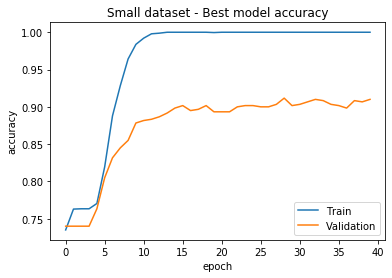

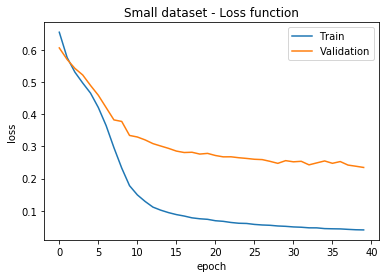

In [17]:
#plot accuracy both for training and validation
plt.plot(fit.history['accuracy'])
plt.plot(fit.history['val_accuracy'])
plt.title('Small dataset - Best model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Validation'])
plt.show()

#plot loss function
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.title('Small dataset - Loss function')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Validation'])
plt.show()

# now shifting data

In [18]:
x_train_shift=(x_train-np.mean(x_train,axis=0))/np.std(x_train,axis=0) #rescaled data of the trainig set

x_test_shift=(x_test-np.mean(x_test,axis=0))/np.std(x_test,axis=0) #rescaled data of the validation set
print(len(x_train_shift))
print(np.shape(x_train_shift))
#rint(x_train)

2400
(2400, 63)


In [19]:
#find best regularization parameter
optimizers  = { 'regularizer'  : [0.01, 0.05, 0.1],
              'optimizer' : ['RMSprop', 'Adam', 'Nadam', 'Adamax']}

grid = GridSearchCV(estimator = KerasClassifier(build_fn=create_model, epochs=epoch, batch_size=batch_size),
                    param_grid= optimizers,  
                    n_jobs=1,
                    cv = folds)
grid.fit(x_train_shift,y_train, shuffle = 1 )

Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 1s 541us/sample - loss: 0.9206 - accuracy: 0.7412
Epoch 2/40
2160/2160 [==============================] - 0s 56us/sample - loss: 0.7720 - accuracy: 0.7611
Epoch 3/40
2160/2160 [==============================] - 0s 57us/sample - loss: 0.6812 - accuracy: 0.7625
Epoch 4/40
2160/2160 [==============================] - 0s 53us/sample - loss: 0.6096 - accuracy: 0.7644
Epoch 5/40
2160/2160 [==============================] - 0s 74us/sample - loss: 0.5480 - accuracy: 0.7769
Epoch 6/40
2160/2160 [==============================] - 0s 58us/sample - loss: 0.4973 - accuracy: 0.8028
Epoch 7/40
2160/2160 [==============================] - 0s 69us/sample - loss: 0.4421 - accuracy: 0.8440
Epoch 8/40
2160/2160 [==============================] - 0s 50us/sample - loss: 0.3889 - accuracy: 0.8968
Epoch 9/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.3355 - accuracy: 0.9269
Epoch 10/40
2160/2160 [=========

Epoch 32/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.0327 - accuracy: 1.0000
Epoch 33/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.0310 - accuracy: 0.9995
Epoch 34/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.0298 - accuracy: 1.0000
Epoch 35/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.0286 - accuracy: 0.9995
Epoch 36/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.0267 - accuracy: 1.0000
Epoch 37/40
2160/2160 [==============================] - 0s 56us/sample - loss: 0.0266 - accuracy: 1.0000
Epoch 38/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.0247 - accuracy: 1.0000
Epoch 39/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.0240 - accuracy: 0.9995
Epoch 40/40
240/240 [==============================] - 0s 416us/sample - loss: 0.2973 - accuracy: 0.9042
Train on 2160 samples
Epoch 1/40
2160/2160 [===

2160/2160 [==============================] - 0s 50us/sample - loss: 0.0608 - accuracy: 1.0000
Epoch 23/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.0566 - accuracy: 1.0000
Epoch 24/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.0522 - accuracy: 1.0000
Epoch 25/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.0480 - accuracy: 1.0000
Epoch 26/40
2160/2160 [==============================] - 0s 50us/sample - loss: 0.0447 - accuracy: 1.0000
Epoch 27/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.0430 - accuracy: 0.9995
Epoch 28/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.0404 - accuracy: 1.0000
Epoch 29/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.0381 - accuracy: 1.0000
Epoch 30/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.0365 - accuracy: 1.0000
Epoch 31/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 40us/sample - loss: 0.3344 - accuracy: 0.9773
Epoch 13/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.3058 - accuracy: 0.9921
Epoch 14/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.2821 - accuracy: 0.9963
Epoch 15/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.2573 - accuracy: 0.9981
Epoch 16/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.2372 - accuracy: 0.9986
Epoch 17/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.2183 - accuracy: 0.9981
Epoch 18/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.2032 - accuracy: 1.0000
Epoch 19/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.1899 - accuracy: 1.0000
Epoch 20/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.1766 - accuracy: 0.9995
Epoch 21/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 38us/sample - loss: 1.3306 - accuracy: 0.7662
Epoch 3/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.9542 - accuracy: 0.7653
Epoch 4/40
2160/2160 [==============================] - 0s 36us/sample - loss: 0.7263 - accuracy: 0.7653
Epoch 5/40
2160/2160 [==============================] - 0s 35us/sample - loss: 0.6070 - accuracy: 0.7653
Epoch 6/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.5395 - accuracy: 0.7653
Epoch 7/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.4855 - accuracy: 0.7662
Epoch 8/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.4346 - accuracy: 0.7912
Epoch 9/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.3829 - accuracy: 0.8579
Epoch 10/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.3381 - accuracy: 0.9477
Epoch 11/40
2160/2160 [==============================] - 0s 37us/

2160/2160 [==============================] - 0s 39us/sample - loss: 0.0983 - accuracy: 0.9991
Epoch 34/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.0950 - accuracy: 0.9995
Epoch 35/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.0938 - accuracy: 0.9981
Epoch 36/40
2160/2160 [==============================] - 0s 36us/sample - loss: 0.0906 - accuracy: 0.9995
Epoch 37/40
2160/2160 [==============================] - 0s 58us/sample - loss: 0.0875 - accuracy: 0.9981
Epoch 38/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.0854 - accuracy: 0.9991
Epoch 39/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.0838 - accuracy: 0.9991
Epoch 40/40
240/240 [==============================] - 0s 608us/sample - loss: 0.3154 - accuracy: 0.8958
Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 1s 304us/sample - loss: 2.1201 - accuracy: 0.3560
Epoch 2/40
2160/2160 [===============

2160/2160 [==============================] - 0s 49us/sample - loss: 0.1952 - accuracy: 0.9917
Epoch 24/40
2160/2160 [==============================] - 0s 59us/sample - loss: 0.1862 - accuracy: 0.9898
Epoch 25/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.1810 - accuracy: 0.9917
Epoch 26/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.1732 - accuracy: 0.9921
Epoch 27/40
2160/2160 [==============================] - 0s 54us/sample - loss: 0.1687 - accuracy: 1.0000
Epoch 28/40
2160/2160 [==============================] - 0s 55us/sample - loss: 0.1637 - accuracy: 1.0000
Epoch 29/40
2160/2160 [==============================] - 0s 55us/sample - loss: 0.1578 - accuracy: 0.9995
Epoch 30/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.1528 - accuracy: 0.9991
Epoch 31/40
2160/2160 [==============================] - 0s 56us/sample - loss: 0.1501 - accuracy: 0.9995
Epoch 32/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 41us/sample - loss: 0.3408 - accuracy: 0.9394
Epoch 14/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.3237 - accuracy: 0.9435
Epoch 15/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.3073 - accuracy: 0.9519
Epoch 16/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.2933 - accuracy: 0.9500
Epoch 17/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.2816 - accuracy: 0.9569
Epoch 18/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.2698 - accuracy: 0.9949
Epoch 19/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.2564 - accuracy: 0.9981
Epoch 20/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.2480 - accuracy: 0.9991
Epoch 21/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.2385 - accuracy: 0.9972
Epoch 22/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 42us/sample - loss: 0.6904 - accuracy: 0.7625
Epoch 4/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.6178 - accuracy: 0.7653
Epoch 5/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.5596 - accuracy: 0.7713
Epoch 6/40
2160/2160 [==============================] - 0s 54us/sample - loss: 0.5043 - accuracy: 0.7968
Epoch 7/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.4468 - accuracy: 0.8324
Epoch 8/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.3913 - accuracy: 0.8861
Epoch 9/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.3343 - accuracy: 0.9301
Epoch 10/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.2710 - accuracy: 0.9639
Epoch 11/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.2211 - accuracy: 0.9833
Epoch 12/40
2160/2160 [==============================] - 0s 38us

2160/2160 [==============================] - 0s 58us/sample - loss: 0.0523 - accuracy: 0.9986
Epoch 35/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.0494 - accuracy: 0.9995
Epoch 36/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.0478 - accuracy: 1.0000
Epoch 37/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.0465 - accuracy: 1.0000
Epoch 38/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.0468 - accuracy: 1.0000
Epoch 39/40
2160/2160 [==============================] - 0s 50us/sample - loss: 0.0474 - accuracy: 0.9995
Epoch 40/40
240/240 [==============================] - 0s 529us/sample - loss: 0.2053 - accuracy: 0.9375
Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 0s 226us/sample - loss: 1.0657 - accuracy: 0.5866
Epoch 2/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.8195 - accuracy: 0.7667
Epoch 3/40
2160/2160 [================

2160/2160 [==============================] - 0s 40us/sample - loss: 0.0713 - accuracy: 1.0000
Epoch 25/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.0689 - accuracy: 1.0000
Epoch 26/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.0656 - accuracy: 1.0000
Epoch 27/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.0641 - accuracy: 1.0000
Epoch 28/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.0627 - accuracy: 1.0000
Epoch 29/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.0593 - accuracy: 1.0000
Epoch 30/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.0573 - accuracy: 1.0000
Epoch 31/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.0559 - accuracy: 1.0000
Epoch 32/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.0529 - accuracy: 1.0000
Epoch 33/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 39us/sample - loss: 0.2915 - accuracy: 0.9440
Epoch 15/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.2697 - accuracy: 0.9505
Epoch 16/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.2531 - accuracy: 0.9514
Epoch 17/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.2362 - accuracy: 0.9736
Epoch 18/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.2232 - accuracy: 0.9977
Epoch 19/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.2082 - accuracy: 0.9981
Epoch 20/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.1994 - accuracy: 0.9986
Epoch 21/40
2160/2160 [==============================] - 0s 50us/sample - loss: 0.1852 - accuracy: 0.9986
Epoch 22/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.1787 - accuracy: 0.9995
Epoch 23/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 41us/sample - loss: 0.9259 - accuracy: 0.7653
Epoch 5/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.7697 - accuracy: 0.7653
Epoch 6/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.6772 - accuracy: 0.7653
Epoch 7/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.6151 - accuracy: 0.7653
Epoch 8/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.5745 - accuracy: 0.7653
Epoch 9/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.5442 - accuracy: 0.7653
Epoch 10/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.5155 - accuracy: 0.7653
Epoch 11/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.4834 - accuracy: 0.7653
Epoch 12/40
2160/2160 [==============================] - 0s 34us/sample - loss: 0.4467 - accuracy: 0.7653
Epoch 13/40
2160/2160 [==============================] - 0s 39u

2160/2160 [==============================] - 0s 45us/sample - loss: 0.1156 - accuracy: 0.9986
Epoch 36/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.1106 - accuracy: 0.9991
Epoch 37/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.1118 - accuracy: 0.9972
Epoch 38/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.1151 - accuracy: 0.9968
Epoch 39/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.1404 - accuracy: 0.9861
Epoch 40/40
240/240 [==============================] - 0s 455us/sample - loss: 0.2015 - accuracy: 0.9542
Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 0s 231us/sample - loss: 2.2803 - accuracy: 0.7417
Epoch 2/40
2160/2160 [==============================] - 0s 49us/sample - loss: 1.4955 - accuracy: 0.7681
Epoch 3/40
2160/2160 [==============================] - 0s 44us/sample - loss: 1.1232 - accuracy: 0.7676
Epoch 4/40
2160/2160 [=================

2160/2160 [==============================] - 0s 48us/sample - loss: 0.2981 - accuracy: 0.9787
Epoch 26/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.2920 - accuracy: 0.9852
Epoch 27/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.2931 - accuracy: 0.9843
Epoch 28/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.2893 - accuracy: 0.9796
Epoch 29/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.2812 - accuracy: 0.9880
Epoch 30/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.2687 - accuracy: 0.9926
Epoch 31/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.2614 - accuracy: 0.9926
Epoch 32/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.2578 - accuracy: 0.9931
Epoch 33/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.2532 - accuracy: 0.9944
Epoch 34/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 38us/sample - loss: 0.4149 - accuracy: 0.7551
Epoch 16/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.3978 - accuracy: 0.7551
Epoch 17/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.3847 - accuracy: 0.7551
Epoch 18/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.3721 - accuracy: 0.7551
Epoch 19/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.3602 - accuracy: 0.7551
Epoch 20/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.3505 - accuracy: 0.7551
Epoch 21/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.3447 - accuracy: 0.7551
Epoch 22/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.3370 - accuracy: 0.7551
Epoch 23/40
2160/2160 [==============================] - 0s 36us/sample - loss: 0.3311 - accuracy: 0.7551
Epoch 24/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 49us/sample - loss: 0.5422 - accuracy: 0.7718
Epoch 6/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.4875 - accuracy: 0.8023
Epoch 7/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.4295 - accuracy: 0.8394
Epoch 8/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.3706 - accuracy: 0.8884
Epoch 9/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.3140 - accuracy: 0.9481
Epoch 10/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.2646 - accuracy: 0.9722
Epoch 11/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.2187 - accuracy: 0.9903
Epoch 12/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.1869 - accuracy: 0.9968
Epoch 13/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.1592 - accuracy: 0.9991
Epoch 14/40
2160/2160 [==============================] - 0s 40

2160/2160 [==============================] - 0s 39us/sample - loss: 0.0550 - accuracy: 1.0000
Epoch 37/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.0536 - accuracy: 0.9995
Epoch 38/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.0574 - accuracy: 0.9981
Epoch 39/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.0944 - accuracy: 0.9838
Epoch 40/40
240/240 [==============================] - 0s 496us/sample - loss: 0.2295 - accuracy: 0.9333
Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 1s 347us/sample - loss: 1.0527 - accuracy: 0.6477
Epoch 2/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.8369 - accuracy: 0.7662
Epoch 3/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.7322 - accuracy: 0.7634
Epoch 4/40
2160/2160 [==============================] - 0s 35us/sample - loss: 0.6480 - accuracy: 0.7671
Epoch 5/40
2160/2160 [==================

2160/2160 [==============================] - 0s 42us/sample - loss: 0.0748 - accuracy: 0.9995
Epoch 27/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.0695 - accuracy: 1.0000
Epoch 28/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.0684 - accuracy: 1.0000
Epoch 29/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.0651 - accuracy: 1.0000
Epoch 30/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.0626 - accuracy: 1.0000
Epoch 31/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.0619 - accuracy: 1.0000
Epoch 32/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.0591 - accuracy: 1.0000
Epoch 33/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.0594 - accuracy: 1.0000
Epoch 34/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.0570 - accuracy: 1.0000
Epoch 35/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 37us/sample - loss: 0.2259 - accuracy: 1.0000
Epoch 17/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.2047 - accuracy: 1.0000
Epoch 18/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.1913 - accuracy: 0.9995
Epoch 19/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.1830 - accuracy: 0.9995
Epoch 20/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.1736 - accuracy: 0.9991
Epoch 21/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.1707 - accuracy: 0.9986
Epoch 22/40
2160/2160 [==============================] - 0s 36us/sample - loss: 0.1647 - accuracy: 0.9991
Epoch 23/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.1561 - accuracy: 0.9995
Epoch 24/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.1499 - accuracy: 0.9995
Epoch 25/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 39us/sample - loss: 0.6288 - accuracy: 0.7653
Epoch 7/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.5544 - accuracy: 0.7653
Epoch 8/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.4946 - accuracy: 0.7653
Epoch 9/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.4422 - accuracy: 0.7653
Epoch 10/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.3978 - accuracy: 0.7653
Epoch 11/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.3590 - accuracy: 0.8199
Epoch 12/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.3287 - accuracy: 0.9060
Epoch 13/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.3016 - accuracy: 0.9380
Epoch 14/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.2731 - accuracy: 0.9495
Epoch 15/40
2160/2160 [==============================] - 0s 3

2160/2160 [==============================] - 0s 52us/sample - loss: 0.0992 - accuracy: 1.0000
Epoch 38/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.0946 - accuracy: 0.9995
Epoch 39/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.0943 - accuracy: 0.9995
Epoch 40/40
240/240 [==============================] - 0s 579us/sample - loss: 0.1998 - accuracy: 0.9458
Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 1s 356us/sample - loss: 2.2513 - accuracy: 0.6310
Epoch 2/40
2160/2160 [==============================] - 0s 39us/sample - loss: 1.5322 - accuracy: 0.7662
Epoch 3/40
2160/2160 [==============================] - 0s 37us/sample - loss: 1.1403 - accuracy: 0.7676
Epoch 4/40
2160/2160 [==============================] - 0s 35us/sample - loss: 0.8907 - accuracy: 0.7676
Epoch 5/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.7378 - accuracy: 0.7676
Epoch 6/40
2160/2160 [===================

2160/2160 [==============================] - 0s 45us/sample - loss: 0.2138 - accuracy: 0.9958
Epoch 28/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.2021 - accuracy: 0.9968
Epoch 29/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.1952 - accuracy: 0.9991
Epoch 30/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.1903 - accuracy: 0.9977
Epoch 31/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.1885 - accuracy: 0.9963
Epoch 32/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.1964 - accuracy: 0.9907
Epoch 33/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.2535 - accuracy: 0.9630
Epoch 34/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.2313 - accuracy: 0.9801
Epoch 35/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.2003 - accuracy: 0.9889
Epoch 36/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 38us/sample - loss: 0.2973 - accuracy: 0.9653
Epoch 18/40
2160/2160 [==============================] - 0s 36us/sample - loss: 0.2852 - accuracy: 0.9769
Epoch 19/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.2652 - accuracy: 0.9838
Epoch 20/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.2526 - accuracy: 0.9894
Epoch 21/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.2416 - accuracy: 0.9898
Epoch 22/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.2404 - accuracy: 0.9866
Epoch 23/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.2273 - accuracy: 0.9940
Epoch 24/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.2164 - accuracy: 0.9917
Epoch 25/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.2131 - accuracy: 0.9870
Epoch 26/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 38us/sample - loss: 0.7196 - accuracy: 0.7611
Epoch 8/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.6913 - accuracy: 0.7653
Epoch 9/40
2160/2160 [==============================] - 0s 53us/sample - loss: 0.6672 - accuracy: 0.7648
Epoch 10/40
2160/2160 [==============================] - 0s 50us/sample - loss: 0.6466 - accuracy: 0.7648
Epoch 11/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.6283 - accuracy: 0.7648
Epoch 12/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.6110 - accuracy: 0.7644
Epoch 13/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.5942 - accuracy: 0.7713
Epoch 14/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.5774 - accuracy: 0.7699
Epoch 15/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.5618 - accuracy: 0.7745
Epoch 16/40
2160/2160 [==============================] - 0s 

2160/2160 [==============================] - 0s 45us/sample - loss: 0.2014 - accuracy: 0.9889
Epoch 39/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.1943 - accuracy: 0.9917
Epoch 40/40
240/240 [==============================] - 0s 676us/sample - loss: 0.4243 - accuracy: 0.8458
Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 1s 332us/sample - loss: 1.1190 - accuracy: 0.4782
Epoch 2/40
2160/2160 [==============================] - 0s 56us/sample - loss: 0.9490 - accuracy: 0.7463
Epoch 3/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.8846 - accuracy: 0.7593
Epoch 4/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.8383 - accuracy: 0.7634
Epoch 5/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.7941 - accuracy: 0.7681
Epoch 6/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.7579 - accuracy: 0.7657
Epoch 7/40
2160/2160 [====================

2160/2160 [==============================] - 0s 59us/sample - loss: 0.3695 - accuracy: 0.9250
Epoch 29/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.3539 - accuracy: 0.9301
Epoch 30/40
2160/2160 [==============================] - 0s 54us/sample - loss: 0.3414 - accuracy: 0.9375
Epoch 31/40
2160/2160 [==============================] - 0s 57us/sample - loss: 0.3266 - accuracy: 0.9458
Epoch 32/40
2160/2160 [==============================] - 0s 58us/sample - loss: 0.3139 - accuracy: 0.9481
Epoch 33/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.2988 - accuracy: 0.9542
Epoch 34/40
2160/2160 [==============================] - 0s 36us/sample - loss: 0.2849 - accuracy: 0.9639
Epoch 35/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.2753 - accuracy: 0.9685
Epoch 36/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.2633 - accuracy: 0.9718
Epoch 37/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 42us/sample - loss: 0.5664 - accuracy: 0.7644
Epoch 19/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.5496 - accuracy: 0.7644
Epoch 20/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.5319 - accuracy: 0.7644
Epoch 21/40
2160/2160 [==============================] - 0s 55us/sample - loss: 0.5120 - accuracy: 0.7644
Epoch 22/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.4941 - accuracy: 0.7662
Epoch 23/40
2160/2160 [==============================] - 0s 35us/sample - loss: 0.4795 - accuracy: 0.7694
Epoch 24/40
2160/2160 [==============================] - 0s 36us/sample - loss: 0.4605 - accuracy: 0.7755
Epoch 25/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.4440 - accuracy: 0.7856
Epoch 26/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.4315 - accuracy: 0.8009
Epoch 27/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 40us/sample - loss: 1.0295 - accuracy: 0.7653
Epoch 9/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.9539 - accuracy: 0.7653
Epoch 10/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.8873 - accuracy: 0.7653
Epoch 11/40
2160/2160 [==============================] - 0s 36us/sample - loss: 0.8297 - accuracy: 0.7653
Epoch 12/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.7800 - accuracy: 0.7653
Epoch 13/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.7392 - accuracy: 0.7653
Epoch 14/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.7039 - accuracy: 0.7653
Epoch 15/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.6750 - accuracy: 0.7653
Epoch 16/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.6471 - accuracy: 0.7653
Epoch 17/40
2160/2160 [==============================] - 0s

2160/2160 [==============================] - 0s 105us/sample - loss: 0.3013 - accuracy: 0.9583
Epoch 40/40
240/240 [==============================] - 0s 662us/sample - loss: 0.4067 - accuracy: 0.8542
Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 1s 298us/sample - loss: 2.7535 - accuracy: 0.4833
Epoch 2/40
2160/2160 [==============================] - 0s 50us/sample - loss: 2.0425 - accuracy: 0.6875
Epoch 3/40
2160/2160 [==============================] - 0s 41us/sample - loss: 1.7549 - accuracy: 0.7333
Epoch 4/40
2160/2160 [==============================] - 0s 42us/sample - loss: 1.5546 - accuracy: 0.7537
Epoch 5/40
2160/2160 [==============================] - 0s 41us/sample - loss: 1.3983 - accuracy: 0.7593
Epoch 6/40
2160/2160 [==============================] - 0s 38us/sample - loss: 1.2668 - accuracy: 0.7653
Epoch 7/40
2160/2160 [==============================] - 0s 43us/sample - loss: 1.1559 - accuracy: 0.7685
Epoch 8/40
2160/2160 [====================

2160/2160 [==============================] - 0s 46us/sample - loss: 0.5365 - accuracy: 0.7606
Epoch 30/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.5284 - accuracy: 0.7606
Epoch 31/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.5179 - accuracy: 0.7606
Epoch 32/40
2160/2160 [==============================] - 0s 53us/sample - loss: 0.5064 - accuracy: 0.7606
Epoch 33/40
2160/2160 [==============================] - 0s 56us/sample - loss: 0.4954 - accuracy: 0.7606
Epoch 34/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.4842 - accuracy: 0.7606
Epoch 35/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.4754 - accuracy: 0.7606
Epoch 36/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.4621 - accuracy: 0.7606
Epoch 37/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.4504 - accuracy: 0.7606
Epoch 38/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 37us/sample - loss: 0.6537 - accuracy: 0.7551
Epoch 20/40
2160/2160 [==============================] - 0s 36us/sample - loss: 0.6357 - accuracy: 0.7551
Epoch 21/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.6243 - accuracy: 0.7551
Epoch 22/40
2160/2160 [==============================] - 0s 36us/sample - loss: 0.6109 - accuracy: 0.7551
Epoch 23/40
2160/2160 [==============================] - 0s 35us/sample - loss: 0.6028 - accuracy: 0.7551
Epoch 24/40
2160/2160 [==============================] - 0s 35us/sample - loss: 0.5913 - accuracy: 0.7551
Epoch 25/40
2160/2160 [==============================] - 0s 35us/sample - loss: 0.5838 - accuracy: 0.7551
Epoch 26/40
2160/2160 [==============================] - 0s 36us/sample - loss: 0.5736 - accuracy: 0.7551
Epoch 27/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.5648 - accuracy: 0.7551
Epoch 28/40
2160/2160 [==============================] - 0

2400/2400 [==============================] - 0s 32us/sample - loss: 0.4280 - accuracy: 0.7633
Epoch 10/40
2400/2400 [==============================] - 0s 34us/sample - loss: 0.3849 - accuracy: 0.7638
Epoch 11/40
2400/2400 [==============================] - 0s 37us/sample - loss: 0.3492 - accuracy: 0.8667
Epoch 12/40
2400/2400 [==============================] - 0s 42us/sample - loss: 0.3135 - accuracy: 0.9396
Epoch 13/40
2400/2400 [==============================] - 0s 43us/sample - loss: 0.2841 - accuracy: 0.9679
Epoch 14/40
2400/2400 [==============================] - 0s 34us/sample - loss: 0.2586 - accuracy: 0.9883
Epoch 15/40
2400/2400 [==============================] - 0s 32us/sample - loss: 0.2353 - accuracy: 0.9879
Epoch 16/40
2400/2400 [==============================] - 0s 41us/sample - loss: 0.2179 - accuracy: 0.9921
Epoch 17/40
2400/2400 [==============================] - 0s 36us/sample - loss: 0.2063 - accuracy: 0.9892
Epoch 18/40
2400/2400 [==============================] - 0

GridSearchCV(cv=10, error_score=nan,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fcfb8f7b630>,
             iid='deprecated', n_jobs=1,
             param_grid={'optimizer': ['RMSprop', 'Adam', 'Nadam', 'Adamax'],
                         'regularizer': [0.01, 0.05, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [20]:
print("Best parameters set found:", grid.best_params_ )
best_regular = grid.best_params_.get('regularizer')
best_optimizer = grid.best_params_.get('optimizer')
 
print("Score with best parameters:", grid.best_score_)


scores = pd.DataFrame(grid.cv_results_)[['rank_test_score','mean_test_score','std_test_score', 'params', 'mean_fit_time','std_fit_time','mean_score_time','std_score_time']]
scores.sort_values('rank_test_score')

Best parameters set found: {'optimizer': 'Adam', 'regularizer': 0.05}
Score with best parameters: 0.9470833301544189


,rank_test_score,mean_test_score,std_test_score,params,mean_fit_time,std_fit_time,mean_score_time,std_score_time
4,1,0.947083,0.011342,"{'optimizer': 'Adam', 'regularizer': 0.05}",4.449802,0.374593,0.175660,0.015379
7,2,0.935833,0.018276,"{'optimizer': 'Nadam', 'regularizer': 0.05}",4.684759,0.283493,0.172865,0.014324
5,3,0.934583,0.016250,"{'optimizer': 'Adam', 'regularizer': 0.1}",4.520711,0.383731,0.260738,0.228052
8,4,0.930833,0.017500,"{'optimizer': 'Nadam', 'regularizer': 0.1}",4.595396,0.372952,0.161014,0.021406
6,5,0.930417,0.023500,"{'optimizer': 'Nadam', 'regularizer': 0.01}",4.834925,0.291712,0.171625,0.019985
3,6,0.928750,0.021201,"{'optimizer': 'Adam', 'regularizer': 0.01}",4.628872,0.289630,0.184332,0.024681
0,7,0.928333,0.016008,"{'optimizer': 'RMSprop', 'regularizer': 0.01}",5.152188,0.624080,0.196011,0.039655
2,8,0.921250,0.027979,"{'optimizer': 'RMSprop', 'regularizer': 0.1}",4.858769,0.375075,0.187028,0.026730
1,9,0.919583,0.016776,"{'optimizer': 'RMSprop', 'regularizer': 0.05}",4.538402,0.325539,0.175730,0.007856
9,10,0.863750,0.018639,"{'optimizer': 'Adamax', 'regularizer': 0.01}",4.784316,0.225046,0.185021,0.032776


In [21]:
#find best dropout rate
optimizers  = { 'drop_out'  : [0.15, 0.20, 0.25, 0.3],
              'activations'  : ['relu', 'sigmoid', 'softmax'] }

grid = GridSearchCV(estimator = KerasClassifier(build_fn=create_model,
                                                epochs=epoch, batch_size=batch_size,
                                                optimizer = best_optimizer,
                                                regularizer = best_regular),
                    param_grid=optimizers,
                    n_jobs=1,
                    cv = folds)
grid.fit(x_train_shift,y_train, shuffle = 1 )

Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 1s 286us/sample - loss: 2.2408 - accuracy: 0.5523
Epoch 2/40
2160/2160 [==============================] - 0s 56us/sample - loss: 1.4878 - accuracy: 0.7454
Epoch 3/40
2160/2160 [==============================] - 0s 45us/sample - loss: 1.1192 - accuracy: 0.7620
Epoch 4/40
2160/2160 [==============================] - 0s 50us/sample - loss: 0.8785 - accuracy: 0.7620
Epoch 5/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.7299 - accuracy: 0.7620
Epoch 6/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.6322 - accuracy: 0.7620
Epoch 7/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.5652 - accuracy: 0.7620
Epoch 8/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.5130 - accuracy: 0.7704
Epoch 9/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.4606 - accuracy: 0.7866
Epoch 10/40
2160/2160 [=========

2160/2160 [==============================] - 0s 47us/sample - loss: 0.1472 - accuracy: 0.9949
Epoch 33/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.1391 - accuracy: 0.9958
Epoch 34/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.1301 - accuracy: 0.9986
Epoch 35/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.1203 - accuracy: 0.9981
Epoch 36/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.1161 - accuracy: 0.9995
Epoch 37/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.1103 - accuracy: 0.9995
Epoch 38/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.1069 - accuracy: 0.9991
Epoch 39/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.1052 - accuracy: 1.0000
Epoch 40/40
240/240 [==============================] - 0s 655us/sample - loss: 0.1792 - accuracy: 0.9625
Train on 2160 samples
Epoch 1/40
2160/2160 [===============

2160/2160 [==============================] - 0s 42us/sample - loss: 0.1613 - accuracy: 0.9995
Epoch 23/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.1563 - accuracy: 1.0000
Epoch 24/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.1518 - accuracy: 1.0000
Epoch 25/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.1478 - accuracy: 1.0000
Epoch 26/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.1458 - accuracy: 0.9986
Epoch 27/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.1506 - accuracy: 0.9949
Epoch 28/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.1648 - accuracy: 0.9907
Epoch 29/40
2160/2160 [==============================] - 0s 57us/sample - loss: 0.1616 - accuracy: 0.9917
Epoch 30/40
2160/2160 [==============================] - 0s 55us/sample - loss: 0.1593 - accuracy: 0.9935
Epoch 31/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 48us/sample - loss: 0.3222 - accuracy: 0.9731
Epoch 13/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.2783 - accuracy: 0.9907
Epoch 14/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.2423 - accuracy: 0.9986
Epoch 15/40
2160/2160 [==============================] - 0s 57us/sample - loss: 0.2167 - accuracy: 0.9995
Epoch 16/40
2160/2160 [==============================] - 0s 54us/sample - loss: 0.1996 - accuracy: 1.0000
Epoch 17/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.1836 - accuracy: 1.0000
Epoch 18/40
2160/2160 [==============================] - 0s 53us/sample - loss: 0.1761 - accuracy: 0.9995
Epoch 19/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.1681 - accuracy: 1.0000
Epoch 20/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.1627 - accuracy: 1.0000
Epoch 21/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 43us/sample - loss: 1.4903 - accuracy: 0.7616
Epoch 3/40
2160/2160 [==============================] - 0s 40us/sample - loss: 1.1261 - accuracy: 0.7657
Epoch 4/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.8882 - accuracy: 0.7653
Epoch 5/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.7401 - accuracy: 0.7653
Epoch 6/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.6476 - accuracy: 0.7653
Epoch 7/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.5854 - accuracy: 0.7653
Epoch 8/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.5342 - accuracy: 0.7653
Epoch 9/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.4871 - accuracy: 0.7653
Epoch 10/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.4482 - accuracy: 0.7653
Epoch 11/40
2160/2160 [==============================] - 0s 47us/

2160/2160 [==============================] - 0s 45us/sample - loss: 0.1191 - accuracy: 1.0000
Epoch 34/40
2160/2160 [==============================] - 0s 58us/sample - loss: 0.1150 - accuracy: 0.9995
Epoch 35/40
2160/2160 [==============================] - 0s 55us/sample - loss: 0.1131 - accuracy: 1.0000
Epoch 36/40
2160/2160 [==============================] - 0s 57us/sample - loss: 0.1087 - accuracy: 0.9995
Epoch 37/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.1096 - accuracy: 0.9991
Epoch 38/40
2160/2160 [==============================] - 0s 36us/sample - loss: 0.1062 - accuracy: 1.0000
Epoch 39/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.1029 - accuracy: 0.9995
Epoch 40/40
240/240 [==============================] - 0s 439us/sample - loss: 0.2221 - accuracy: 0.9500
Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 1s 241us/sample - loss: 2.1858 - accuracy: 0.7500
Epoch 2/40
2160/2160 [===============

2160/2160 [==============================] - 0s 54us/sample - loss: 0.1866 - accuracy: 0.9958
Epoch 24/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.1772 - accuracy: 0.9995
Epoch 25/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.1708 - accuracy: 0.9968
Epoch 26/40
2160/2160 [==============================] - 0s 53us/sample - loss: 0.1667 - accuracy: 0.9972
Epoch 27/40
2160/2160 [==============================] - 0s 58us/sample - loss: 0.1602 - accuracy: 0.9981
Epoch 28/40
2160/2160 [==============================] - 0s 61us/sample - loss: 0.1579 - accuracy: 0.9963
Epoch 29/40
2160/2160 [==============================] - 0s 61us/sample - loss: 0.1536 - accuracy: 0.9968
Epoch 30/40
2160/2160 [==============================] - 0s 62us/sample - loss: 0.1496 - accuracy: 0.9986
Epoch 31/40
2160/2160 [==============================] - 0s 57us/sample - loss: 0.1447 - accuracy: 0.9981
Epoch 32/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 48us/sample - loss: 0.2949 - accuracy: 0.9815
Epoch 14/40
2160/2160 [==============================] - 0s 58us/sample - loss: 0.2582 - accuracy: 0.9921
Epoch 15/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.2374 - accuracy: 0.9968
Epoch 16/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.2198 - accuracy: 0.9991
Epoch 17/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.2067 - accuracy: 0.9972
Epoch 18/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.1936 - accuracy: 0.9986
Epoch 19/40
2160/2160 [==============================] - 0s 53us/sample - loss: 0.1788 - accuracy: 0.9991
Epoch 20/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.1691 - accuracy: 0.9995
Epoch 21/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.1659 - accuracy: 0.9991
Epoch 22/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 48us/sample - loss: 1.1345 - accuracy: 0.7606
Epoch 4/40
2160/2160 [==============================] - 0s 57us/sample - loss: 0.9019 - accuracy: 0.7611
Epoch 5/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.7531 - accuracy: 0.7620
Epoch 6/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.6620 - accuracy: 0.7620
Epoch 7/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.6015 - accuracy: 0.7620
Epoch 8/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.5563 - accuracy: 0.7620
Epoch 9/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.5162 - accuracy: 0.7620
Epoch 10/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.4740 - accuracy: 0.7861
Epoch 11/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.4318 - accuracy: 0.8606
Epoch 12/40
2160/2160 [==============================] - 0s 49us

2160/2160 [==============================] - 0s 61us/sample - loss: 0.1327 - accuracy: 0.9977
Epoch 35/40
2160/2160 [==============================] - 0s 63us/sample - loss: 0.1184 - accuracy: 0.9995
Epoch 36/40
2160/2160 [==============================] - 0s 68us/sample - loss: 0.1143 - accuracy: 0.9986
Epoch 37/40
2160/2160 [==============================] - 0s 61us/sample - loss: 0.1061 - accuracy: 1.0000
Epoch 38/40
2160/2160 [==============================] - 0s 57us/sample - loss: 0.1056 - accuracy: 0.9981
Epoch 39/40
2160/2160 [==============================] - 0s 53us/sample - loss: 0.1030 - accuracy: 0.9986
Epoch 40/40
240/240 [==============================] - 0s 679us/sample - loss: 0.2591 - accuracy: 0.9375
Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 1s 341us/sample - loss: 2.4028 - accuracy: 0.5537
Epoch 2/40
2160/2160 [==============================] - 0s 65us/sample - loss: 1.5737 - accuracy: 0.7486
Epoch 3/40
2160/2160 [================

2160/2160 [==============================] - 0s 46us/sample - loss: 0.1898 - accuracy: 0.9963
Epoch 25/40
2160/2160 [==============================] - 0s 54us/sample - loss: 0.1854 - accuracy: 0.9958
Epoch 26/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.1801 - accuracy: 0.9968
Epoch 27/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.1645 - accuracy: 0.9991
Epoch 28/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.1600 - accuracy: 0.9986
Epoch 29/40
2160/2160 [==============================] - 0s 57us/sample - loss: 0.1552 - accuracy: 1.0000
Epoch 30/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.1495 - accuracy: 0.9991
Epoch 31/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.1464 - accuracy: 1.0000
Epoch 32/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.1438 - accuracy: 0.9986
Epoch 33/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 60us/sample - loss: 1.0526 - accuracy: 0.7644
Epoch 15/40
2160/2160 [==============================] - 0s 56us/sample - loss: 1.0260 - accuracy: 0.7644
Epoch 16/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.9989 - accuracy: 0.7644
Epoch 17/40
2160/2160 [==============================] - 0s 60us/sample - loss: 0.9835 - accuracy: 0.7644
Epoch 18/40
2160/2160 [==============================] - 0s 62us/sample - loss: 0.9619 - accuracy: 0.7644
Epoch 19/40
2160/2160 [==============================] - 0s 62us/sample - loss: 0.9397 - accuracy: 0.7644
Epoch 20/40
2160/2160 [==============================] - 0s 65us/sample - loss: 0.9228 - accuracy: 0.7644
Epoch 21/40
2160/2160 [==============================] - 0s 65us/sample - loss: 0.9036 - accuracy: 0.7644
Epoch 22/40
2160/2160 [==============================] - 0s 64us/sample - loss: 0.8862 - accuracy: 0.7644
Epoch 23/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 45us/sample - loss: 1.5420 - accuracy: 0.7338
Epoch 5/40
2160/2160 [==============================] - 0s 46us/sample - loss: 1.4580 - accuracy: 0.7481
Epoch 6/40
2160/2160 [==============================] - 0s 42us/sample - loss: 1.3924 - accuracy: 0.7491
Epoch 7/40
2160/2160 [==============================] - 0s 38us/sample - loss: 1.3286 - accuracy: 0.7644
Epoch 8/40
2160/2160 [==============================] - 0s 48us/sample - loss: 1.2739 - accuracy: 0.7620
Epoch 9/40
2160/2160 [==============================] - 0s 50us/sample - loss: 1.2296 - accuracy: 0.7630
Epoch 10/40
2160/2160 [==============================] - 0s 41us/sample - loss: 1.1876 - accuracy: 0.7644
Epoch 11/40
2160/2160 [==============================] - 0s 54us/sample - loss: 1.1544 - accuracy: 0.7644
Epoch 12/40
2160/2160 [==============================] - 0s 52us/sample - loss: 1.1227 - accuracy: 0.7644
Epoch 13/40
2160/2160 [==============================] - 0s 54u

2160/2160 [==============================] - 0s 48us/sample - loss: 0.6958 - accuracy: 0.7620
Epoch 36/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.6870 - accuracy: 0.7620
Epoch 37/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.6799 - accuracy: 0.7620
Epoch 38/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.6722 - accuracy: 0.7620
Epoch 39/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.6654 - accuracy: 0.7620
Epoch 40/40
240/240 [==============================] - 0s 627us/sample - loss: 0.6535 - accuracy: 0.7750
Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 1s 315us/sample - loss: 2.1489 - accuracy: 0.2903
Epoch 2/40
2160/2160 [==============================] - 0s 42us/sample - loss: 1.7931 - accuracy: 0.5792
Epoch 3/40
2160/2160 [==============================] - 0s 39us/sample - loss: 1.6408 - accuracy: 0.7093
Epoch 4/40
2160/2160 [=================

2160/2160 [==============================] - 0s 48us/sample - loss: 0.8204 - accuracy: 0.7606
Epoch 26/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.8046 - accuracy: 0.7606
Epoch 27/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.7909 - accuracy: 0.7606
Epoch 28/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.7812 - accuracy: 0.7606
Epoch 29/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.7692 - accuracy: 0.7606
Epoch 30/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.7575 - accuracy: 0.7606
Epoch 31/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.7466 - accuracy: 0.7606
Epoch 32/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.7364 - accuracy: 0.7606
Epoch 33/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.7283 - accuracy: 0.7606
Epoch 34/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 40us/sample - loss: 0.9923 - accuracy: 0.7551
Epoch 16/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.9688 - accuracy: 0.7551
Epoch 17/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.9465 - accuracy: 0.7551
Epoch 18/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.9247 - accuracy: 0.7551
Epoch 19/40
2160/2160 [==============================] - 0s 55us/sample - loss: 0.9064 - accuracy: 0.7551
Epoch 20/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.8846 - accuracy: 0.7551
Epoch 21/40
2160/2160 [==============================] - 0s 55us/sample - loss: 0.8681 - accuracy: 0.7551
Epoch 22/40
2160/2160 [==============================] - 0s 61us/sample - loss: 0.8543 - accuracy: 0.7551
Epoch 23/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.8341 - accuracy: 0.7551
Epoch 24/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 45us/sample - loss: 1.3878 - accuracy: 0.7616
Epoch 6/40
2160/2160 [==============================] - 0s 50us/sample - loss: 1.3299 - accuracy: 0.7616
Epoch 7/40
2160/2160 [==============================] - 0s 57us/sample - loss: 1.2684 - accuracy: 0.7620
Epoch 8/40
2160/2160 [==============================] - 0s 45us/sample - loss: 1.2198 - accuracy: 0.7620
Epoch 9/40
2160/2160 [==============================] - 0s 50us/sample - loss: 1.1791 - accuracy: 0.7620
Epoch 10/40
2160/2160 [==============================] - 0s 56us/sample - loss: 1.1391 - accuracy: 0.7620
Epoch 11/40
2160/2160 [==============================] - 0s 44us/sample - loss: 1.0978 - accuracy: 0.7620
Epoch 12/40
2160/2160 [==============================] - 0s 52us/sample - loss: 1.0708 - accuracy: 0.7620
Epoch 13/40
2160/2160 [==============================] - 0s 47us/sample - loss: 1.0408 - accuracy: 0.7620
Epoch 14/40
2160/2160 [==============================] - 0s 53

2160/2160 [==============================] - 0s 39us/sample - loss: 0.6819 - accuracy: 0.7685
Epoch 37/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.6753 - accuracy: 0.7685
Epoch 38/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.6655 - accuracy: 0.7685
Epoch 39/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.6594 - accuracy: 0.7685
Epoch 40/40
240/240 [==============================] - 0s 661us/sample - loss: 0.7072 - accuracy: 0.7167
Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 1s 400us/sample - loss: 1.9532 - accuracy: 0.6495
Epoch 2/40
2160/2160 [==============================] - 0s 43us/sample - loss: 1.6774 - accuracy: 0.7144
Epoch 3/40
2160/2160 [==============================] - 0s 43us/sample - loss: 1.5630 - accuracy: 0.7431
Epoch 4/40
2160/2160 [==============================] - 0s 47us/sample - loss: 1.4745 - accuracy: 0.7551
Epoch 5/40
2160/2160 [==================

2160/2160 [==============================] - 0s 36us/sample - loss: 0.7896 - accuracy: 0.7620
Epoch 27/40
2160/2160 [==============================] - 0s 35us/sample - loss: 0.7769 - accuracy: 0.7620
Epoch 28/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.7657 - accuracy: 0.7620
Epoch 29/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.7530 - accuracy: 0.7620
Epoch 30/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.7407 - accuracy: 0.7620
Epoch 31/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.7331 - accuracy: 0.7620
Epoch 32/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.7211 - accuracy: 0.7620
Epoch 33/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.7111 - accuracy: 0.7620
Epoch 34/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.7005 - accuracy: 0.7620
Epoch 35/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 40us/sample - loss: 0.9692 - accuracy: 0.7644
Epoch 17/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.9436 - accuracy: 0.7644
Epoch 18/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.9196 - accuracy: 0.7644
Epoch 19/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.9002 - accuracy: 0.7644
Epoch 20/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.8824 - accuracy: 0.7644
Epoch 21/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.8649 - accuracy: 0.7644
Epoch 22/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.8494 - accuracy: 0.7644
Epoch 23/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.8312 - accuracy: 0.7644
Epoch 24/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.8168 - accuracy: 0.7644
Epoch 25/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 43us/sample - loss: 1.3159 - accuracy: 0.7657
Epoch 7/40
2160/2160 [==============================] - 0s 41us/sample - loss: 1.2609 - accuracy: 0.7653
Epoch 8/40
2160/2160 [==============================] - 0s 40us/sample - loss: 1.2116 - accuracy: 0.7653
Epoch 9/40
2160/2160 [==============================] - 0s 42us/sample - loss: 1.1690 - accuracy: 0.7653
Epoch 10/40
2160/2160 [==============================] - 0s 40us/sample - loss: 1.1386 - accuracy: 0.7648
Epoch 11/40
2160/2160 [==============================] - 0s 36us/sample - loss: 1.0954 - accuracy: 0.7653
Epoch 12/40
2160/2160 [==============================] - 0s 37us/sample - loss: 1.0645 - accuracy: 0.7653
Epoch 13/40
2160/2160 [==============================] - 0s 48us/sample - loss: 1.0376 - accuracy: 0.7653
Epoch 14/40
2160/2160 [==============================] - 0s 41us/sample - loss: 1.0117 - accuracy: 0.7653
Epoch 15/40
2160/2160 [==============================] - 0s 4

2160/2160 [==============================] - 0s 44us/sample - loss: 0.6831 - accuracy: 0.7620
Epoch 38/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.6750 - accuracy: 0.7620
Epoch 39/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.6684 - accuracy: 0.7620
Epoch 40/40
240/240 [==============================] - 0s 416us/sample - loss: 0.6524 - accuracy: 0.7750
Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 0s 225us/sample - loss: 2.0649 - accuracy: 0.5505
Epoch 2/40
2160/2160 [==============================] - 0s 41us/sample - loss: 1.7175 - accuracy: 0.6940
Epoch 3/40
2160/2160 [==============================] - 0s 48us/sample - loss: 1.6024 - accuracy: 0.7264
Epoch 4/40
2160/2160 [==============================] - 0s 43us/sample - loss: 1.5029 - accuracy: 0.7421
Epoch 5/40
2160/2160 [==============================] - 0s 43us/sample - loss: 1.4263 - accuracy: 0.7537
Epoch 6/40
2160/2160 [===================

2160/2160 [==============================] - 0s 41us/sample - loss: 0.5575 - accuracy: 0.7606
Epoch 28/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.5579 - accuracy: 0.7606
Epoch 29/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.5578 - accuracy: 0.7606
Epoch 30/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.5545 - accuracy: 0.7606
Epoch 31/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.5562 - accuracy: 0.7606
Epoch 32/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.5538 - accuracy: 0.7606
Epoch 33/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.5509 - accuracy: 0.7606
Epoch 34/40
2160/2160 [==============================] - 0s 50us/sample - loss: 0.5501 - accuracy: 0.7606
Epoch 35/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.5461 - accuracy: 0.7606
Epoch 36/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 45us/sample - loss: 0.5694 - accuracy: 0.7551
Epoch 18/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.5677 - accuracy: 0.7551
Epoch 19/40
2160/2160 [==============================] - 0s 53us/sample - loss: 0.5680 - accuracy: 0.7551
Epoch 20/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.5675 - accuracy: 0.7551
Epoch 21/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.5677 - accuracy: 0.7551
Epoch 22/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.5658 - accuracy: 0.7551
Epoch 23/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.5644 - accuracy: 0.7551
Epoch 24/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.5654 - accuracy: 0.7551
Epoch 25/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.5642 - accuracy: 0.7551
Epoch 26/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 62us/sample - loss: 0.5769 - accuracy: 0.7620
Epoch 8/40
2160/2160 [==============================] - 0s 71us/sample - loss: 0.5737 - accuracy: 0.7620
Epoch 9/40
2160/2160 [==============================] - 0s 69us/sample - loss: 0.5685 - accuracy: 0.7620
Epoch 10/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.5661 - accuracy: 0.7620
Epoch 11/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.5639 - accuracy: 0.7620
Epoch 12/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.5625 - accuracy: 0.7620
Epoch 13/40
2160/2160 [==============================] - 0s 56us/sample - loss: 0.5585 - accuracy: 0.7620
Epoch 14/40
2160/2160 [==============================] - 0s 56us/sample - loss: 0.5577 - accuracy: 0.7620
Epoch 15/40
2160/2160 [==============================] - 0s 56us/sample - loss: 0.5595 - accuracy: 0.7620
Epoch 16/40
2160/2160 [==============================] - 0s 

2160/2160 [==============================] - 0s 59us/sample - loss: 0.5125 - accuracy: 0.7685
Epoch 39/40
2160/2160 [==============================] - 0s 70us/sample - loss: 0.5056 - accuracy: 0.7685
Epoch 40/40
240/240 [==============================] - 0s 662us/sample - loss: 0.5563 - accuracy: 0.7167
Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 1s 301us/sample - loss: 0.6776 - accuracy: 0.7412
Epoch 2/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.6537 - accuracy: 0.7657
Epoch 3/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.6332 - accuracy: 0.7657
Epoch 4/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.6167 - accuracy: 0.7657
Epoch 5/40
2160/2160 [==============================] - 0s 50us/sample - loss: 0.6040 - accuracy: 0.7657
Epoch 6/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.5936 - accuracy: 0.7657
Epoch 7/40
2160/2160 [====================

2160/2160 [==============================] - 0s 51us/sample - loss: 0.5579 - accuracy: 0.7620
Epoch 29/40
2160/2160 [==============================] - 0s 61us/sample - loss: 0.5566 - accuracy: 0.7620
Epoch 30/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.5567 - accuracy: 0.7620
Epoch 31/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.5582 - accuracy: 0.7620
Epoch 32/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.5559 - accuracy: 0.7620
Epoch 33/40
2160/2160 [==============================] - 0s 57us/sample - loss: 0.5563 - accuracy: 0.7620
Epoch 34/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.5559 - accuracy: 0.7620
Epoch 35/40
2160/2160 [==============================] - 0s 51us/sample - loss: 0.5556 - accuracy: 0.7620
Epoch 36/40
2160/2160 [==============================] - 0s 47us/sample - loss: 0.5533 - accuracy: 0.7620
Epoch 37/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 40us/sample - loss: 0.5576 - accuracy: 0.7644
Epoch 19/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.5555 - accuracy: 0.7644
Epoch 20/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.5574 - accuracy: 0.7644
Epoch 21/40
2160/2160 [==============================] - 0s 58us/sample - loss: 0.5546 - accuracy: 0.7644
Epoch 22/40
2160/2160 [==============================] - 0s 48us/sample - loss: 0.5574 - accuracy: 0.7644
Epoch 23/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.5515 - accuracy: 0.7644
Epoch 24/40
2160/2160 [==============================] - 0s 52us/sample - loss: 0.5520 - accuracy: 0.7644
Epoch 25/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.5491 - accuracy: 0.7644
Epoch 26/40
2160/2160 [==============================] - 0s 55us/sample - loss: 0.5487 - accuracy: 0.7644
Epoch 27/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 48us/sample - loss: 0.5754 - accuracy: 0.7653
Epoch 9/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.5702 - accuracy: 0.7653
Epoch 10/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.5654 - accuracy: 0.7653
Epoch 11/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.5646 - accuracy: 0.7653
Epoch 12/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.5610 - accuracy: 0.7653
Epoch 13/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.5596 - accuracy: 0.7653
Epoch 14/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.5566 - accuracy: 0.7653
Epoch 15/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.5561 - accuracy: 0.7653
Epoch 16/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.5557 - accuracy: 0.7653
Epoch 17/40
2160/2160 [==============================] - 0s

2160/2160 [==============================] - 0s 44us/sample - loss: 0.4871 - accuracy: 0.7620
Epoch 40/40
240/240 [==============================] - 0s 608us/sample - loss: 0.4913 - accuracy: 0.7750
Train on 2160 samples
Epoch 1/40
2160/2160 [==============================] - 1s 310us/sample - loss: 0.6969 - accuracy: 0.5472
Epoch 2/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.6678 - accuracy: 0.7528
Epoch 3/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.6445 - accuracy: 0.7667
Epoch 4/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.6240 - accuracy: 0.7676
Epoch 5/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.6077 - accuracy: 0.7676
Epoch 6/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.5966 - accuracy: 0.7676
Epoch 7/40
2160/2160 [==============================] - 0s 39us/sample - loss: 0.5846 - accuracy: 0.7676
Epoch 8/40
2160/2160 [=====================

2160/2160 [==============================] - 0s 43us/sample - loss: 0.5581 - accuracy: 0.7606
Epoch 30/40
2160/2160 [==============================] - 0s 46us/sample - loss: 0.5587 - accuracy: 0.7606
Epoch 31/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.5521 - accuracy: 0.7606
Epoch 32/40
2160/2160 [==============================] - 0s 44us/sample - loss: 0.5532 - accuracy: 0.7606
Epoch 33/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.5548 - accuracy: 0.7606
Epoch 34/40
2160/2160 [==============================] - 0s 42us/sample - loss: 0.5509 - accuracy: 0.7606
Epoch 35/40
2160/2160 [==============================] - 0s 43us/sample - loss: 0.5483 - accuracy: 0.7606
Epoch 36/40
2160/2160 [==============================] - 0s 41us/sample - loss: 0.5468 - accuracy: 0.7606
Epoch 37/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.5443 - accuracy: 0.7606
Epoch 38/40
2160/2160 [==============================] - 0

2160/2160 [==============================] - 0s 43us/sample - loss: 0.5652 - accuracy: 0.7551
Epoch 20/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.5664 - accuracy: 0.7551
Epoch 21/40
2160/2160 [==============================] - 0s 37us/sample - loss: 0.5648 - accuracy: 0.7551
Epoch 22/40
2160/2160 [==============================] - 0s 38us/sample - loss: 0.5653 - accuracy: 0.7551
Epoch 23/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.5644 - accuracy: 0.7551
Epoch 24/40
2160/2160 [==============================] - 0s 49us/sample - loss: 0.5630 - accuracy: 0.7551
Epoch 25/40
2160/2160 [==============================] - 0s 50us/sample - loss: 0.5637 - accuracy: 0.7551
Epoch 26/40
2160/2160 [==============================] - 0s 45us/sample - loss: 0.5646 - accuracy: 0.7551
Epoch 27/40
2160/2160 [==============================] - 0s 40us/sample - loss: 0.5644 - accuracy: 0.7551
Epoch 28/40
2160/2160 [==============================] - 0

2400/2400 [==============================] - 0s 32us/sample - loss: 0.3920 - accuracy: 0.7633
Epoch 10/40
2400/2400 [==============================] - 0s 43us/sample - loss: 0.3551 - accuracy: 0.7633
Epoch 11/40
2400/2400 [==============================] - 0s 47us/sample - loss: 0.3271 - accuracy: 0.7633
Epoch 12/40
2400/2400 [==============================] - 0s 41us/sample - loss: 0.3059 - accuracy: 0.7633
Epoch 13/40
2400/2400 [==============================] - 0s 50us/sample - loss: 0.2917 - accuracy: 0.8483
Epoch 14/40
2400/2400 [==============================] - 0s 51us/sample - loss: 0.2783 - accuracy: 0.9725
Epoch 15/40
2400/2400 [==============================] - 0s 40us/sample - loss: 0.2675 - accuracy: 0.9800
Epoch 16/40
2400/2400 [==============================] - 0s 35us/sample - loss: 0.2580 - accuracy: 0.9879
Epoch 17/40
2400/2400 [==============================] - 0s 43us/sample - loss: 0.2477 - accuracy: 0.9904
Epoch 18/40
2400/2400 [==============================] - 0

GridSearchCV(cv=10, error_score=nan,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fd1018bd400>,
             iid='deprecated', n_jobs=1,
             param_grid={'activations': ['relu', 'sigmoid', 'softmax'],
                         'drop_out': [0.15, 0.2, 0.25, 0.3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [22]:
print("Best parameters set found:", grid.best_params_ )
best_dropout = grid.best_params_.get('drop_out')
best_activations = grid.best_params_.get('activations')
print("Score with best parameters:", grid.best_score_)


scores = pd.DataFrame(grid.cv_results_)[['rank_test_score','mean_test_score','std_test_score', 'params', 'mean_fit_time','std_fit_time','mean_score_time','std_score_time']]
scores.sort_values('rank_test_score')

Best parameters set found: {'activations': 'relu', 'drop_out': 0.2}
Score with best parameters: 0.9441666603088379


,rank_test_score,mean_test_score,std_test_score,params,mean_fit_time,std_fit_time,mean_score_time,std_score_time
1,1,0.944167,0.015501,"{'activations': 'relu', 'drop_out': 0.2}",4.564153,0.617543,0.171064,0.030249
0,2,0.940417,0.021168,"{'activations': 'relu', 'drop_out': 0.15}",5.041025,0.589518,0.187861,0.023748
2,3,0.940000,0.016583,"{'activations': 'relu', 'drop_out': 0.25}",4.914254,0.418353,0.179320,0.025293
3,4,0.933750,0.017819,"{'activations': 'relu', 'drop_out': 0.3}",5.246491,0.376027,0.198306,0.009623
4,5,0.763333,0.033166,"{'activations': 'sigmoid', 'drop_out': 0.15}",4.938827,0.428451,0.189979,0.015816
5,5,0.763333,0.033166,"{'activations': 'sigmoid', 'drop_out': 0.2}",4.671029,0.264632,0.184558,0.017693
6,5,0.763333,0.033166,"{'activations': 'sigmoid', 'drop_out': 0.25}",5.081729,0.580769,0.194326,0.011314
7,5,0.763333,0.033166,"{'activations': 'sigmoid', 'drop_out': 0.3}",4.421479,0.206774,0.171031,0.043028
8,5,0.763333,0.033166,"{'activations': 'softmax', 'drop_out': 0.15}",4.784621,0.362320,0.171323,0.016866
9,5,0.763333,0.033166,"{'activations': 'softmax', 'drop_out': 0.2}",5.085523,0.233836,0.177402,0.025344


In [23]:
# tf.compat.v1.disable_eager_execution()

best_model = create_model(activations = best_activations, 
                          drop_out = best_dropout, 
                          optimizer = best_optimizer,
                          regularizer = best_regular)

fit = best_model.fit(x_train_shift, y_train, 
                     epochs = 40, 
                     batch_size = batch_size, 
                     validation_data = (x_test_shift, y_test), shuffle = 1,
                     callbacks = [ModelCheckpoint(filepath='parameters_shifteddataset.h5', save_best_only=True)])


Train on 2400 samples, validate on 600 samples
Epoch 1/40
2400/2400 [==============================] - 1s 261us/sample - loss: 2.1539 - accuracy: 0.6812 - val_loss: 1.6574 - val_accuracy: 0.7350
Epoch 2/40
2400/2400 [==============================] - 0s 48us/sample - loss: 1.4008 - accuracy: 0.7604 - val_loss: 1.2036 - val_accuracy: 0.7400
Epoch 3/40
2400/2400 [==============================] - 0s 55us/sample - loss: 1.0297 - accuracy: 0.7633 - val_loss: 0.9274 - val_accuracy: 0.7400
Epoch 4/40
2400/2400 [==============================] - 0s 65us/sample - loss: 0.8053 - accuracy: 0.7633 - val_loss: 0.7640 - val_accuracy: 0.7400
Epoch 5/40
2400/2400 [==============================] - 0s 63us/sample - loss: 0.6752 - accuracy: 0.7633 - val_loss: 0.6680 - val_accuracy: 0.7400
Epoch 6/40
2400/2400 [==============================] - 0s 77us/sample - loss: 0.5980 - accuracy: 0.7633 - val_loss: 0.6062 - val_accuracy: 0.7400
Epoch 7/40
2400/2400 [==============================] - 0s 66us/sample

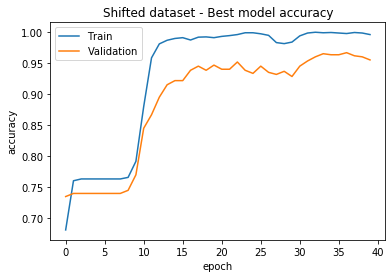

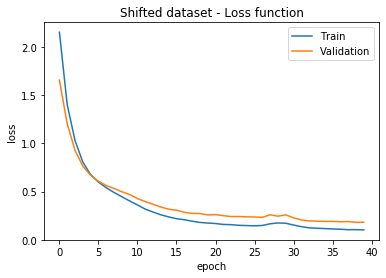

In [24]:
#plot accuracy both for training and validation
plt.plot(fit.history['accuracy'])
plt.plot(fit.history['val_accuracy'])
plt.title('Shifted dataset - Best model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Validation'])
plt.show()

#plot loss function
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.title('Shifted dataset - Loss function')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Validation'])
plt.show()

# DATA AUGMENTATION

There is invariance by shifting digits left, or right. It follows that, for each sample in the training set, there are L - 1 equivalent samples we can train our network with.

In [25]:
def expand_augment(data, label, shift_augment = False):
    S = data 
    if(len(str(S))!=L):
        print('mismatch!')
        return[]
    
    x_temp = [0] * LD
    y_temp = label
    
    p = 10**(L-1)
    j = 0
    
    while (j < L):
        q = int(S/p) #in this way we obtained the first digit (MSD)
        
        # 1...9 ---> 0...8
        x_temp[j*D + (q-1)] = 1
        j += 1
        S = S - q*p
        p = int(p/10)
    
    if (shift_augment):
        x_aug  = [0] * LD * L
        x_aug  = np.reshape(x_aug, (L, LD))
        y_aug  = np.array([0]*L)
    
        for combination in range(L): #for each combination possible by shifting
            for index in range(LD):
                x_aug[combination][(index + combination*D)%LD] = x_temp[index]
            y_aug[combination] = label 
            
        return x_aug, y_aug
    
    else: return x_temp, y_temp

#print(dataset[1][0],   '---->', expand_augment(dataset[1][0], dataset[1][1], True))

# USING NEW DATASET APPLYING SHIFT INVARIANCE

In [26]:
data_augmented = [None]*N*L*2
data_augmented = np.reshape(data_augmented, (L*N,2))

for i in range(N):
    x_aug_temp, y_aug_temp = expand_augment(dataset[i][0], dataset[i][1], True)
    
    for j in range(len(x_aug_temp)):
        data_augmented[j + i*L][0] = x_aug_temp[j]
        data_augmented[j + i*L][1] = y_aug_temp[j]

#New N from data augmentation
N_new = len(data_augmented)
        
#see how many samples we use for training and then RESHUFFLE
N_train = int(percent_train * N_new)
np.random.shuffle(data_augmented)

print(np.shape(data_augmented[0:N_train,0]))

print(f'data: {N_new}')                         
print(f'lenght of string: {L}')             
print(f'dimension of my new data sample: {LD}') 
print(f'dimension of my new training dataset: {N_train}') 

#split into train and test

x_train = [[i for i in j] for j in data_augmented[0:N_train,0]]
x_test  = [[i for i in j] for j in data_augmented[N_train:,0]]
y_train = data_augmented[0:N_train,1]
y_test  = data_augmented[N_train:,1]

#print(len(x_train), '\t', len(x_test)) #should be 

#KERAS WANTS AS INPUT np.array()
x_train = np.array(x_train)                  # <--- we'd need to do this if the input data weren't of this kind
y_train = np.array(y_train)                 # <--- THIS IS OK
x_test = np.array(x_test)                  
y_test = np.array(y_test)

(16800,)
data: 21000
lenght of string: 7
dimension of my new data sample: 63
dimension of my new training dataset: 16800


# GO!

In [27]:
#find best regularization parameter
optimizers  = { 'regularizer'  : [0.01, 0.05, 0.1],
              'optimizer' : ['RMSprop', 'Adam', 'Nadam', 'Adamax']}

grid = GridSearchCV(estimator = KerasClassifier(build_fn=create_model, epochs=epoch, batch_size=batch_size),
                    param_grid= optimizers,  
                    n_jobs=1,
                    cv = folds)
grid.fit(x_train,y_train, shuffle = 1 )

Train on 15120 samples
Epoch 1/40
15120/15120 [==============================] - 1s 81us/sample - loss: 0.5483 - accuracy: 0.7637
Epoch 2/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.3631 - accuracy: 0.8694
Epoch 3/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.1744 - accuracy: 0.9644
Epoch 4/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.0893 - accuracy: 0.9933
Epoch 5/40
15120/15120 [==============================] - 0s 33us/sample - loss: 0.0568 - accuracy: 0.9979
Epoch 6/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0410 - accuracy: 0.9991
Epoch 7/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.0319 - accuracy: 0.9993
Epoch 8/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.0257 - accuracy: 0.9995
Epoch 9/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.0219 - accuracy: 0.9993
Epoch 10/40
15

Epoch 29/40
15120/15120 [==============================] - 1s 51us/sample - loss: 0.0172 - accuracy: 0.9963
Epoch 30/40
15120/15120 [==============================] - 1s 53us/sample - loss: 0.0153 - accuracy: 0.9966
Epoch 31/40
15120/15120 [==============================] - 1s 53us/sample - loss: 0.0205 - accuracy: 0.9952
Epoch 32/40
15120/15120 [==============================] - 1s 58us/sample - loss: 0.0160 - accuracy: 0.9966
Epoch 33/40
15120/15120 [==============================] - 1s 56us/sample - loss: 0.0160 - accuracy: 0.9967
Epoch 34/40
15120/15120 [==============================] - 1s 55us/sample - loss: 0.0168 - accuracy: 0.9964
Epoch 35/40
15120/15120 [==============================] - 1s 51us/sample - loss: 0.0148 - accuracy: 0.9972
Epoch 36/40
15120/15120 [==============================] - 1s 59us/sample - loss: 0.0143 - accuracy: 0.9971
Epoch 37/40
15120/15120 [==============================] - 1s 56us/sample - loss: 0.0161 - accuracy: 0.9965
Epoch 38/40
15120/15120 [===

Epoch 16/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.0144 - accuracy: 0.9989
Epoch 17/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.0136 - accuracy: 0.9989
Epoch 18/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0144 - accuracy: 0.9981
Epoch 19/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.0133 - accuracy: 0.9987
Epoch 20/40
15120/15120 [==============================] - 1s 33us/sample - loss: 0.0151 - accuracy: 0.9977
Epoch 21/40
15120/15120 [==============================] - 1s 35us/sample - loss: 0.0129 - accuracy: 0.9986
Epoch 22/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.0136 - accuracy: 0.9983
Epoch 23/40
15120/15120 [==============================] - 1s 51us/sample - loss: 0.0142 - accuracy: 0.9978
Epoch 24/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.0162 - accuracy: 0.9976
Epoch 25/40
15120/15120 [===

15120/15120 [==============================] - 1s 38us/sample - loss: 0.4260 - accuracy: 0.8243
Epoch 3/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.2721 - accuracy: 0.9444
Epoch 4/40
15120/15120 [==============================] - 1s 54us/sample - loss: 0.1749 - accuracy: 0.9809
Epoch 5/40
15120/15120 [==============================] - 1s 59us/sample - loss: 0.1265 - accuracy: 0.9925
Epoch 6/40
15120/15120 [==============================] - 1s 52us/sample - loss: 0.0981 - accuracy: 0.9952
Epoch 7/40
15120/15120 [==============================] - 1s 52us/sample - loss: 0.0797 - accuracy: 0.9965
Epoch 8/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.0680 - accuracy: 0.9971
Epoch 9/40
15120/15120 [==============================] - 1s 49us/sample - loss: 0.0596 - accuracy: 0.9971
Epoch 10/40
15120/15120 [==============================] - 1s 59us/sample - loss: 0.0533 - accuracy: 0.9960
Epoch 11/40
15120/15120 [======================

15120/15120 [==============================] - 1s 40us/sample - loss: 0.0304 - accuracy: 0.9942
Epoch 38/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.0281 - accuracy: 0.9949s - loss: 0.024
Epoch 39/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0261 - accuracy: 0.9956
Epoch 40/40
1680/1680 [==============================] - 0s 107us/sample - loss: 0.0678 - accuracy: 0.9845
Train on 15120 samples
Epoch 1/40
15120/15120 [==============================] - 1s 83us/sample - loss: 0.5826 - accuracy: 0.7565
Epoch 2/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.4127 - accuracy: 0.8466
Epoch 3/40
15120/15120 [==============================] - 1s 36us/sample - loss: 0.2637 - accuracy: 0.9523
Epoch 4/40
15120/15120 [==============================] - 1s 36us/sample - loss: 0.1696 - accuracy: 0.9835
Epoch 5/40
15120/15120 [==============================] - 1s 36us/sample - loss: 0.1225 - accuracy: 0.9929
Epoch 6/

Epoch 24/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0588 - accuracy: 0.9944
Epoch 25/40
15120/15120 [==============================] - 1s 53us/sample - loss: 0.0597 - accuracy: 0.9937
Epoch 26/40
15120/15120 [==============================] - 1s 54us/sample - loss: 0.0595 - accuracy: 0.9931
Epoch 27/40
15120/15120 [==============================] - 1s 64us/sample - loss: 0.0586 - accuracy: 0.9933
Epoch 28/40
15120/15120 [==============================] - 1s 56us/sample - loss: 0.0578 - accuracy: 0.9928
Epoch 29/40
15120/15120 [==============================] - 1s 56us/sample - loss: 0.0591 - accuracy: 0.9926
Epoch 30/40
15120/15120 [==============================] - 1s 52us/sample - loss: 0.0576 - accuracy: 0.9939
Epoch 31/40
15120/15120 [==============================] - 1s 58us/sample - loss: 0.0600 - accuracy: 0.9930
Epoch 32/40
15120/15120 [==============================] - 1s 53us/sample - loss: 0.0592 - accuracy: 0.9931
Epoch 33/40
15120/15120 [===

Epoch 11/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.1212 - accuracy: 0.9960
Epoch 12/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.1099 - accuracy: 0.9954
Epoch 13/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.1041 - accuracy: 0.9942
Epoch 14/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.0985 - accuracy: 0.9932
Epoch 15/40
15120/15120 [==============================] - 0s 33us/sample - loss: 0.0952 - accuracy: 0.9925
Epoch 16/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.0945 - accuracy: 0.9904
Epoch 17/40
15120/15120 [==============================] - 1s 37us/sample - loss: 0.0959 - accuracy: 0.9891
Epoch 18/40
15120/15120 [==============================] - 0s 33us/sample - loss: 0.0930 - accuracy: 0.9903
Epoch 19/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.0960 - accuracy: 0.9874
Epoch 20/40
15120/15120 [===

15120/15120 [==============================] - 1s 34us/sample - loss: 0.0419 - accuracy: 0.9956
Epoch 40/40
1680/1680 [==============================] - 0s 81us/sample - loss: 0.0337 - accuracy: 0.9958
Train on 15120 samples
Epoch 1/40
15120/15120 [==============================] - 1s 73us/sample - loss: 0.6500 - accuracy: 0.7501
Epoch 2/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.5079 - accuracy: 0.7852
Epoch 3/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.3884 - accuracy: 0.8937
Epoch 4/40
15120/15120 [==============================] - 1s 35us/sample - loss: 0.2806 - accuracy: 0.9594
Epoch 5/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.2135 - accuracy: 0.9794
Epoch 6/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.1731 - accuracy: 0.9841
Epoch 7/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.1450 - accuracy: 0.9879
Epoch 8/40
15120/15120 [==

Epoch 33/40
15120/15120 [==============================] - 1s 55us/sample - loss: 0.0455 - accuracy: 0.9924
Epoch 34/40
15120/15120 [==============================] - 1s 60us/sample - loss: 0.0452 - accuracy: 0.9923
Epoch 35/40
15120/15120 [==============================] - 1s 52us/sample - loss: 0.0465 - accuracy: 0.9921
Epoch 36/40
15120/15120 [==============================] - 1s 54us/sample - loss: 0.0419 - accuracy: 0.9938
Epoch 37/40
15120/15120 [==============================] - 1s 57us/sample - loss: 0.0421 - accuracy: 0.9932
Epoch 38/40
15120/15120 [==============================] - 1s 56us/sample - loss: 0.0439 - accuracy: 0.9923
Epoch 39/40
15120/15120 [==============================] - 1s 52us/sample - loss: 0.0432 - accuracy: 0.9923
Epoch 40/40
1680/1680 [==============================] - 0s 130us/sample - loss: 0.0629 - accuracy: 0.9875
Train on 15120 samples
Epoch 1/40
15120/15120 [==============================] - 1s 88us/sample - loss: 0.6270 - accuracy: 0.7565
Epoch 2

Epoch 20/40
15120/15120 [==============================] - 1s 59us/sample - loss: 0.0804 - accuracy: 0.9894
Epoch 21/40
15120/15120 [==============================] - 1s 57us/sample - loss: 0.0784 - accuracy: 0.9892
Epoch 22/40
15120/15120 [==============================] - 1s 59us/sample - loss: 0.0731 - accuracy: 0.9903
Epoch 23/40
15120/15120 [==============================] - 1s 54us/sample - loss: 0.0734 - accuracy: 0.9902
Epoch 24/40
15120/15120 [==============================] - 1s 53us/sample - loss: 0.0706 - accuracy: 0.9908
Epoch 25/40
15120/15120 [==============================] - 1s 54us/sample - loss: 0.0693 - accuracy: 0.9902
Epoch 26/40
15120/15120 [==============================] - 1s 59us/sample - loss: 0.0684 - accuracy: 0.9900
Epoch 27/40
15120/15120 [==============================] - 1s 50us/sample - loss: 0.0654 - accuracy: 0.9917
Epoch 28/40
15120/15120 [==============================] - 1s 49us/sample - loss: 0.0673 - accuracy: 0.9903
Epoch 29/40
15120/15120 [===

Epoch 7/40
15120/15120 [==============================] - 1s 33us/sample - loss: 0.0433 - accuracy: 0.9999
Epoch 8/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.0383 - accuracy: 0.9999
Epoch 9/40
15120/15120 [==============================] - 1s 36us/sample - loss: 0.0343 - accuracy: 0.9999
Epoch 10/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.0313 - accuracy: 0.9999
Epoch 11/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.0286 - accuracy: 1.0000
Epoch 12/40
15120/15120 [==============================] - 1s 36us/sample - loss: 0.0261 - accuracy: 0.9999
Epoch 13/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.0264 - accuracy: 0.9992
Epoch 14/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.0337 - accuracy: 0.9963
Epoch 15/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.0240 - accuracy: 0.9995
Epoch 16/40
15120/15120 [======

Train on 15120 samples
Epoch 1/40
15120/15120 [==============================] - 1s 83us/sample - loss: 0.5228 - accuracy: 0.7705
Epoch 2/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.3065 - accuracy: 0.8949
Epoch 3/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.1259 - accuracy: 0.9848
Epoch 4/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.0792 - accuracy: 0.9977
Epoch 5/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.0623 - accuracy: 0.9997
Epoch 6/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.0532 - accuracy: 0.9999
Epoch 7/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.0474 - accuracy: 0.9999
Epoch 8/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.0422 - accuracy: 0.9999
Epoch 9/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.0382 - accuracy: 0.9997
Epoch 10/40
15

Epoch 29/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.0133 - accuracy: 0.9987
Epoch 30/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.0121 - accuracy: 0.9991
Epoch 31/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.0101 - accuracy: 0.9996
Epoch 32/40
15120/15120 [==============================] - 1s 49us/sample - loss: 0.0098 - accuracy: 0.9995
Epoch 33/40
15120/15120 [==============================] - 1s 49us/sample - loss: 0.0095 - accuracy: 0.9994
Epoch 34/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.0083 - accuracy: 1.0000
Epoch 35/40
15120/15120 [==============================] - 1s 52us/sample - loss: 0.0081 - accuracy: 0.9999
Epoch 36/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.0077 - accuracy: 0.9998
Epoch 37/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.0070 - accuracy: 1.0000
Epoch 38/40
15120/15120 [===

15120/15120 [==============================] - 1s 48us/sample - loss: 0.0465 - accuracy: 0.9988
Epoch 16/40
15120/15120 [==============================] - 1s 56us/sample - loss: 0.0435 - accuracy: 0.9991
Epoch 17/40
15120/15120 [==============================] - 1s 52us/sample - loss: 0.0418 - accuracy: 0.9989
Epoch 18/40
15120/15120 [==============================] - 1s 59us/sample - loss: 0.0385 - accuracy: 0.9989
Epoch 19/40
15120/15120 [==============================] - 1s 56us/sample - loss: 0.0387 - accuracy: 0.9985
Epoch 20/40
15120/15120 [==============================] - 1s 56us/sample - loss: 0.0397 - accuracy: 0.9979
Epoch 21/40
15120/15120 [==============================] - 1s 56us/sample - loss: 0.0343 - accuracy: 0.9994
Epoch 22/40
15120/15120 [==============================] - 1s 66us/sample - loss: 0.0332 - accuracy: 0.9990
Epoch 23/40
15120/15120 [==============================] - 1s 59us/sample - loss: 0.0313 - accuracy: 0.9990
Epoch 24/40
15120/15120 [===============

Epoch 9/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0785 - accuracy: 0.9985
Epoch 10/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.0721 - accuracy: 0.9987
Epoch 11/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.0654 - accuracy: 0.9987
Epoch 12/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.0624 - accuracy: 0.9984
Epoch 13/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.0595 - accuracy: 0.9978
Epoch 14/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.0544 - accuracy: 0.9983
Epoch 15/40
15120/15120 [==============================] - 1s 37us/sample - loss: 0.0496 - accuracy: 0.9991
Epoch 16/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.0472 - accuracy: 0.9990
Epoch 17/40
15120/15120 [==============================] - 1s 36us/sample - loss: 0.0440 - accuracy: 0.9987
Epoch 18/40
15120/15120 [====

15120/15120 [==============================] - 1s 51us/sample - loss: 0.0237 - accuracy: 0.9987
Epoch 37/40
15120/15120 [==============================] - 1s 51us/sample - loss: 0.0220 - accuracy: 0.9989
Epoch 38/40
15120/15120 [==============================] - 1s 50us/sample - loss: 0.0220 - accuracy: 0.9989
Epoch 39/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.0239 - accuracy: 0.9985
Epoch 40/40
1680/1680 [==============================] - 0s 116us/sample - loss: 0.0667 - accuracy: 0.9839
Train on 15120 samples
Epoch 1/40
15120/15120 [==============================] - 1s 79us/sample - loss: 0.5856 - accuracy: 0.7610
Epoch 2/40
15120/15120 [==============================] - 1s 48us/sample - loss: 0.3810 - accuracy: 0.8745
Epoch 3/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.2165 - accuracy: 0.9685
Epoch 4/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.1511 - accuracy: 0.9889
Epoch 5/40
15120/15120

Epoch 30/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.0270 - accuracy: 0.9991
Epoch 31/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.0286 - accuracy: 0.9983
Epoch 32/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.0290 - accuracy: 0.9979
Epoch 33/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0250 - accuracy: 0.9991
Epoch 34/40
15120/15120 [==============================] - 1s 51us/sample - loss: 0.0275 - accuracy: 0.9981
Epoch 35/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.0259 - accuracy: 0.9989
Epoch 36/40
15120/15120 [==============================] - 1s 48us/sample - loss: 0.0240 - accuracy: 0.9987
Epoch 37/40
15120/15120 [==============================] - 1s 53us/sample - loss: 0.0229 - accuracy: 0.9989
Epoch 38/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.0221 - accuracy: 0.9990
Epoch 39/40
15120/15120 [===

Epoch 17/40
15120/15120 [==============================] - 1s 56us/sample - loss: 0.0690 - accuracy: 0.9979
Epoch 18/40
15120/15120 [==============================] - 1s 51us/sample - loss: 0.0658 - accuracy: 0.9985
Epoch 19/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0600 - accuracy: 0.9995
Epoch 20/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.0589 - accuracy: 0.9984
Epoch 21/40
15120/15120 [==============================] - 1s 49us/sample - loss: 0.0578 - accuracy: 0.9984
Epoch 22/40
15120/15120 [==============================] - 1s 53us/sample - loss: 0.0533 - accuracy: 0.9987
Epoch 23/40
15120/15120 [==============================] - 1s 48us/sample - loss: 0.0516 - accuracy: 0.9987
Epoch 24/40
15120/15120 [==============================] - 1s 49us/sample - loss: 0.0483 - accuracy: 0.9989
Epoch 25/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.0483 - accuracy: 0.9981
Epoch 26/40
15120/15120 [===

15120/15120 [==============================] - 1s 42us/sample - loss: 0.2910 - accuracy: 0.9517
Epoch 4/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.1960 - accuracy: 0.9858
Epoch 5/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.1550 - accuracy: 0.9943
Epoch 6/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.1301 - accuracy: 0.9974
Epoch 7/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.1136 - accuracy: 0.9976
Epoch 8/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.1007 - accuracy: 0.9985
Epoch 9/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.0924 - accuracy: 0.9985
Epoch 10/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.0848 - accuracy: 0.9984
Epoch 11/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.0793 - accuracy: 0.9984
Epoch 12/40
15120/15120 [=====================

15120/15120 [==============================] - 1s 60us/sample - loss: 0.0296 - accuracy: 0.9987
Epoch 39/40
15120/15120 [==============================] - 1s 61us/sample - loss: 0.0294 - accuracy: 0.9984
Epoch 40/40
1680/1680 [==============================] - 0s 123us/sample - loss: 0.0477 - accuracy: 0.9940
Train on 15120 samples
Epoch 1/40
15120/15120 [==============================] - 1s 78us/sample - loss: 0.6505 - accuracy: 0.7546
Epoch 2/40
15120/15120 [==============================] - 1s 50us/sample - loss: 0.4845 - accuracy: 0.7698
Epoch 3/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.3297 - accuracy: 0.9278
Epoch 4/40
15120/15120 [==============================] - 1s 56us/sample - loss: 0.2199 - accuracy: 0.9809
Epoch 5/40
15120/15120 [==============================] - 1s 61us/sample - loss: 0.1681 - accuracy: 0.9933
Epoch 6/40
15120/15120 [==============================] - 1s 58us/sample - loss: 0.1397 - accuracy: 0.9956
Epoch 7/40
15120/15120 [

Epoch 32/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.0144 - accuracy: 0.9986
Epoch 33/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.0115 - accuracy: 0.9995
Epoch 34/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.0098 - accuracy: 1.0000
Epoch 35/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0090 - accuracy: 0.9999
Epoch 36/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.0084 - accuracy: 1.0000
Epoch 37/40
15120/15120 [==============================] - 1s 48us/sample - loss: 0.0079 - accuracy: 1.0000
Epoch 38/40
15120/15120 [==============================] - 1s 53us/sample - loss: 0.0074 - accuracy: 1.0000
Epoch 39/40
15120/15120 [==============================] - 1s 48us/sample - loss: 0.0071 - accuracy: 1.0000
Epoch 40/40
1680/1680 [==============================] - 0s 123us/sample - loss: 0.0222 - accuracy: 0.9946
Train on 15120 samples
Epoch 

Epoch 19/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.0179 - accuracy: 0.9999
Epoch 20/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.0164 - accuracy: 0.9999
Epoch 21/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.0169 - accuracy: 0.9995
Epoch 22/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0211 - accuracy: 0.9981
Epoch 23/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0209 - accuracy: 0.9986
Epoch 24/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.0184 - accuracy: 0.9988
Epoch 25/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0153 - accuracy: 0.9998
Epoch 26/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.0143 - accuracy: 0.9997
Epoch 27/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.0127 - accuracy: 1.0000
Epoch 28/40
15120/15120 [===

15120/15120 [==============================] - 1s 45us/sample - loss: 0.0613 - accuracy: 0.9999
Epoch 6/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.0525 - accuracy: 0.9998
Epoch 7/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.0463 - accuracy: 0.9999
Epoch 8/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.0405 - accuracy: 0.9999
Epoch 9/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.0366 - accuracy: 0.9999
Epoch 10/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.0333 - accuracy: 1.0000
Epoch 11/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.0312 - accuracy: 0.9999
Epoch 12/40
15120/15120 [==============================] - 1s 55us/sample - loss: 0.0325 - accuracy: 0.9986
Epoch 13/40
15120/15120 [==============================] - 1s 53us/sample - loss: 0.0305 - accuracy: 0.9987
Epoch 14/40
15120/15120 [===================

Epoch 40/40
1680/1680 [==============================] - 0s 114us/sample - loss: 0.0251 - accuracy: 0.9958
Train on 15120 samples
Epoch 1/40
15120/15120 [==============================] - 1s 99us/sample - loss: 0.6183 - accuracy: 0.7440
Epoch 2/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.4202 - accuracy: 0.8554
Epoch 3/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.2320 - accuracy: 0.9772
Epoch 4/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.1632 - accuracy: 0.9942
Epoch 5/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.1319 - accuracy: 0.9979
Epoch 6/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.1117 - accuracy: 0.9987
Epoch 7/40
15120/15120 [==============================] - 1s 50us/sample - loss: 0.0977 - accuracy: 0.9995
Epoch 8/40
15120/15120 [==============================] - 1s 48us/sample - loss: 0.0870 - accuracy: 0.9995
Epoch 9/40
151

Epoch 27/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.0218 - accuracy: 0.9995
Epoch 28/40
15120/15120 [==============================] - 1s 35us/sample - loss: 0.0203 - accuracy: 0.9998
Epoch 29/40
15120/15120 [==============================] - 1s 34us/sample - loss: 0.0212 - accuracy: 0.9989
Epoch 30/40
15120/15120 [==============================] - 1s 34us/sample - loss: 0.0215 - accuracy: 0.9988
Epoch 31/40
15120/15120 [==============================] - 1s 48us/sample - loss: 0.0183 - accuracy: 0.9997
Epoch 32/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.0180 - accuracy: 0.9995
Epoch 33/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.0172 - accuracy: 0.9997
Epoch 34/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.0165 - accuracy: 0.9995
Epoch 35/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.0156 - accuracy: 0.9996
Epoch 36/40
15120/15120 [===

Epoch 14/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.0443 - accuracy: 0.9997
Epoch 15/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.0426 - accuracy: 0.9990
Epoch 16/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.0418 - accuracy: 0.9985
Epoch 17/40
15120/15120 [==============================] - 1s 49us/sample - loss: 0.0378 - accuracy: 0.9993
Epoch 18/40
15120/15120 [==============================] - 1s 51us/sample - loss: 0.0353 - accuracy: 0.9995
Epoch 19/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.0342 - accuracy: 0.9991
Epoch 20/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.0326 - accuracy: 0.9993
Epoch 21/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0329 - accuracy: 0.9983
Epoch 22/40
15120/15120 [==============================] - 1s 49us/sample - loss: 0.0325 - accuracy: 0.9979
Epoch 23/40
15120/15120 [===

15120/15120 [==============================] - 3s 181us/sample - loss: 0.6700 - accuracy: 0.7544
Epoch 2/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.4623 - accuracy: 0.8180
Epoch 3/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.2805 - accuracy: 0.9560
Epoch 4/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.1924 - accuracy: 0.9872
Epoch 5/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.1524 - accuracy: 0.9935
Epoch 6/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.1280 - accuracy: 0.9971
Epoch 7/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.1134 - accuracy: 0.9978
Epoch 8/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.1015 - accuracy: 0.9987
Epoch 9/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.0933 - accuracy: 0.9980
Epoch 10/40
15120/15120 [======================

15120/15120 [==============================] - 1s 40us/sample - loss: 0.0286 - accuracy: 0.9982
Epoch 37/40
15120/15120 [==============================] - 1s 50us/sample - loss: 0.0289 - accuracy: 0.9975
Epoch 38/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.0283 - accuracy: 0.9982
Epoch 39/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0275 - accuracy: 0.9973
Epoch 40/40
1680/1680 [==============================] - 0s 109us/sample - loss: 0.0217 - accuracy: 0.9982
Train on 15120 samples
Epoch 1/40
15120/15120 [==============================] - 1s 90us/sample - loss: 0.6453 - accuracy: 0.7540
Epoch 2/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.4728 - accuracy: 0.7824
Epoch 3/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.3059 - accuracy: 0.9393
Epoch 4/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.2057 - accuracy: 0.9891
Epoch 5/40
15120/15120

Epoch 30/40
15120/15120 [==============================] - 1s 54us/sample - loss: 0.0285 - accuracy: 0.9995
Epoch 31/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.0284 - accuracy: 0.9993
Epoch 32/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0271 - accuracy: 0.9991
Epoch 33/40
15120/15120 [==============================] - 1s 60us/sample - loss: 0.0266 - accuracy: 0.9992
Epoch 34/40
15120/15120 [==============================] - 1s 60us/sample - loss: 0.0272 - accuracy: 0.9984
Epoch 35/40
15120/15120 [==============================] - 1s 56us/sample - loss: 0.0245 - accuracy: 0.9995
Epoch 36/40
15120/15120 [==============================] - 1s 49us/sample - loss: 0.0226 - accuracy: 0.9998
Epoch 37/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.0224 - accuracy: 0.9995
Epoch 38/40
15120/15120 [==============================] - 1s 57us/sample - loss: 0.0207 - accuracy: 0.9995
Epoch 39/40
15120/15120 [===

Epoch 17/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.0724 - accuracy: 0.9994
Epoch 18/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.0701 - accuracy: 0.9988
Epoch 19/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.0668 - accuracy: 0.9989
Epoch 20/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.0630 - accuracy: 0.9993
Epoch 21/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.0605 - accuracy: 0.9991
Epoch 22/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.0578 - accuracy: 0.9987
Epoch 23/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.0553 - accuracy: 0.9989
Epoch 24/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0543 - accuracy: 0.9985
Epoch 25/40
15120/15120 [==============================] - 1s 37us/sample - loss: 0.0495 - accuracy: 0.9996
Epoch 26/40
15120/15120 [===

15120/15120 [==============================] - 1s 39us/sample - loss: 0.4768 - accuracy: 0.7659
Epoch 4/40
15120/15120 [==============================] - 1s 48us/sample - loss: 0.4299 - accuracy: 0.8205
Epoch 5/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.3708 - accuracy: 0.8610
Epoch 6/40
15120/15120 [==============================] - 1s 34us/sample - loss: 0.3018 - accuracy: 0.8994
Epoch 7/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.2426 - accuracy: 0.9310
Epoch 8/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.1950 - accuracy: 0.9528
Epoch 9/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.1587 - accuracy: 0.9679
Epoch 10/40
15120/15120 [==============================] - 1s 53us/sample - loss: 0.1316 - accuracy: 0.9778
Epoch 11/40
15120/15120 [==============================] - 1s 50us/sample - loss: 0.1098 - accuracy: 0.9853
Epoch 12/40
15120/15120 [=====================

15120/15120 [==============================] - 1s 54us/sample - loss: 0.0182 - accuracy: 0.9999
Epoch 39/40
15120/15120 [==============================] - 1s 49us/sample - loss: 0.0176 - accuracy: 0.9999
Epoch 40/40
1680/1680 [==============================] - 0s 129us/sample - loss: 0.0422 - accuracy: 0.9887
Train on 15120 samples
Epoch 1/40
15120/15120 [==============================] - 1s 74us/sample - loss: 0.6071 - accuracy: 0.7380
Epoch 2/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.5223 - accuracy: 0.7591
Epoch 3/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.4762 - accuracy: 0.7797
Epoch 4/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.4330 - accuracy: 0.8200
Epoch 5/40
15120/15120 [==============================] - 1s 55us/sample - loss: 0.3806 - accuracy: 0.8558
Epoch 6/40
15120/15120 [==============================] - 1s 60us/sample - loss: 0.3104 - accuracy: 0.8933
Epoch 7/40
15120/15120 [

Epoch 32/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.0220 - accuracy: 1.0000
Epoch 33/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.0210 - accuracy: 0.9999
Epoch 34/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.0198 - accuracy: 1.0000
Epoch 35/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.0192 - accuracy: 0.9999
Epoch 36/40
15120/15120 [==============================] - 0s 31us/sample - loss: 0.0186 - accuracy: 1.0000
Epoch 37/40
15120/15120 [==============================] - 0s 29us/sample - loss: 0.0178 - accuracy: 1.0000
Epoch 38/40
15120/15120 [==============================] - 0s 30us/sample - loss: 0.0172 - accuracy: 0.9999
Epoch 39/40
15120/15120 [==============================] - 0s 33us/sample - loss: 0.0167 - accuracy: 1.0000
Epoch 40/40
1680/1680 [==============================] - 0s 105us/sample - loss: 0.0435 - accuracy: 0.9893
Train on 15120 samples
Epoch 

Epoch 19/40
15120/15120 [==============================] - 0s 30us/sample - loss: 0.0468 - accuracy: 0.9992
Epoch 20/40
15120/15120 [==============================] - 1s 33us/sample - loss: 0.0439 - accuracy: 0.9994
Epoch 21/40
15120/15120 [==============================] - 0s 32us/sample - loss: 0.0411 - accuracy: 0.9996
Epoch 22/40
15120/15120 [==============================] - 0s 33us/sample - loss: 0.0386 - accuracy: 0.9996
Epoch 23/40
15120/15120 [==============================] - 0s 30us/sample - loss: 0.0362 - accuracy: 0.9999
Epoch 24/40
15120/15120 [==============================] - 1s 35us/sample - loss: 0.0342 - accuracy: 0.9999
Epoch 25/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.0324 - accuracy: 1.0000
Epoch 26/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.0308 - accuracy: 0.9999
Epoch 27/40
15120/15120 [==============================] - 1s 53us/sample - loss: 0.0289 - accuracy: 0.9999
Epoch 28/40
15120/15120 [===

15120/15120 [==============================] - 1s 51us/sample - loss: 0.4530 - accuracy: 0.7599
Epoch 6/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.4165 - accuracy: 0.8014
Epoch 7/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.3757 - accuracy: 0.8489
Epoch 8/40
15120/15120 [==============================] - 1s 50us/sample - loss: 0.3339 - accuracy: 0.8812
Epoch 9/40
15120/15120 [==============================] - 1s 49us/sample - loss: 0.2945 - accuracy: 0.9169
Epoch 10/40
15120/15120 [==============================] - 1s 59us/sample - loss: 0.2582 - accuracy: 0.9397
Epoch 11/40
15120/15120 [==============================] - 1s 50us/sample - loss: 0.2284 - accuracy: 0.9546
Epoch 12/40
15120/15120 [==============================] - 1s 58us/sample - loss: 0.2032 - accuracy: 0.9638
Epoch 13/40
15120/15120 [==============================] - 1s 52us/sample - loss: 0.1807 - accuracy: 0.9728
Epoch 14/40
15120/15120 [===================

Epoch 40/40
1680/1680 [==============================] - 0s 125us/sample - loss: 0.0884 - accuracy: 0.9768
Train on 15120 samples
Epoch 1/40
15120/15120 [==============================] - 1s 91us/sample - loss: 0.6588 - accuracy: 0.7556
Epoch 2/40
15120/15120 [==============================] - 1s 52us/sample - loss: 0.5563 - accuracy: 0.7560
Epoch 3/40
15120/15120 [==============================] - 1s 48us/sample - loss: 0.5053 - accuracy: 0.7560
Epoch 4/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.4666 - accuracy: 0.7560
Epoch 5/40
15120/15120 [==============================] - 1s 37us/sample - loss: 0.4315 - accuracy: 0.7560
Epoch 6/40
15120/15120 [==============================] - 1s 36us/sample - loss: 0.3979 - accuracy: 0.7560
Epoch 7/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.3650 - accuracy: 0.8136
Epoch 8/40
15120/15120 [==============================] - 1s 35us/sample - loss: 0.3355 - accuracy: 0.8976
Epoch 9/40
151

Epoch 27/40
15120/15120 [==============================] - 1s 35us/sample - loss: 0.0554 - accuracy: 0.9994
Epoch 28/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.0519 - accuracy: 0.9995
Epoch 29/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.0495 - accuracy: 0.9997
Epoch 30/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.0477 - accuracy: 0.9997
Epoch 31/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.0455 - accuracy: 0.9997
Epoch 32/40
15120/15120 [==============================] - 1s 49us/sample - loss: 0.0439 - accuracy: 0.9997
Epoch 33/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0416 - accuracy: 0.9997
Epoch 34/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.0396 - accuracy: 0.9998
Epoch 35/40
15120/15120 [==============================] - 1s 48us/sample - loss: 0.0383 - accuracy: 0.9998
Epoch 36/40
15120/15120 [===

Epoch 14/40
15120/15120 [==============================] - 1s 61us/sample - loss: 0.2410 - accuracy: 0.9452
Epoch 15/40
15120/15120 [==============================] - 1s 54us/sample - loss: 0.2208 - accuracy: 0.9554
Epoch 16/40
15120/15120 [==============================] - 1s 58us/sample - loss: 0.2011 - accuracy: 0.9630
Epoch 17/40
15120/15120 [==============================] - 1s 59us/sample - loss: 0.1839 - accuracy: 0.9675
Epoch 18/40
15120/15120 [==============================] - 1s 59us/sample - loss: 0.1699 - accuracy: 0.9728
Epoch 19/40
15120/15120 [==============================] - 1s 57us/sample - loss: 0.1577 - accuracy: 0.9767
Epoch 20/40
15120/15120 [==============================] - 1s 58us/sample - loss: 0.1454 - accuracy: 0.9800
Epoch 21/40
15120/15120 [==============================] - 1s 59us/sample - loss: 0.1358 - accuracy: 0.9828
Epoch 22/40
15120/15120 [==============================] - 1s 50us/sample - loss: 0.1262 - accuracy: 0.9862
Epoch 23/40
15120/15120 [===

15120/15120 [==============================] - 1s 72us/sample - loss: 0.7619 - accuracy: 0.7259
Epoch 2/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.6151 - accuracy: 0.7579
Epoch 3/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.5833 - accuracy: 0.7579
Epoch 4/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.5661 - accuracy: 0.7579
Epoch 5/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.5466 - accuracy: 0.7579
Epoch 6/40
15120/15120 [==============================] - 1s 58us/sample - loss: 0.5243 - accuracy: 0.7579
Epoch 7/40
15120/15120 [==============================] - 1s 54us/sample - loss: 0.5033 - accuracy: 0.7579
Epoch 8/40
15120/15120 [==============================] - 1s 54us/sample - loss: 0.4831 - accuracy: 0.7579
Epoch 9/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.4630 - accuracy: 0.7579
Epoch 10/40
15120/15120 [=======================

15120/15120 [==============================] - 0s 29us/sample - loss: 0.0664 - accuracy: 0.9976
Epoch 37/40
15120/15120 [==============================] - 0s 28us/sample - loss: 0.0632 - accuracy: 0.9979
Epoch 38/40
15120/15120 [==============================] - 0s 32us/sample - loss: 0.0615 - accuracy: 0.9981
Epoch 39/40
15120/15120 [==============================] - 0s 33us/sample - loss: 0.0593 - accuracy: 0.9982
Epoch 40/40
1680/1680 [==============================] - 0s 76us/sample - loss: 0.1594 - accuracy: 0.9607
Train on 15120 samples
Epoch 1/40
15120/15120 [==============================] - 1s 64us/sample - loss: 0.7756 - accuracy: 0.7067
Epoch 2/40
15120/15120 [==============================] - 1s 52us/sample - loss: 0.6218 - accuracy: 0.7577
Epoch 3/40
15120/15120 [==============================] - 1s 53us/sample - loss: 0.5893 - accuracy: 0.7577
Epoch 4/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.5735 - accuracy: 0.7577
Epoch 5/40
15120/15120 

Epoch 30/40
15120/15120 [==============================] - 1s 51us/sample - loss: 0.1034 - accuracy: 0.9940
Epoch 31/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.0996 - accuracy: 0.9952
Epoch 32/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.0950 - accuracy: 0.9955
Epoch 33/40
15120/15120 [==============================] - 1s 56us/sample - loss: 0.0907 - accuracy: 0.9959
Epoch 34/40
15120/15120 [==============================] - 1s 50us/sample - loss: 0.0865 - accuracy: 0.9970
Epoch 35/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.0841 - accuracy: 0.9975
Epoch 36/40
15120/15120 [==============================] - 1s 37us/sample - loss: 0.0807 - accuracy: 0.9975
Epoch 37/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0775 - accuracy: 0.9979
Epoch 38/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.0761 - accuracy: 0.9978
Epoch 39/40
15120/15120 [===

GridSearchCV(cv=10, error_score=nan,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fcfb87d5eb8>,
             iid='deprecated', n_jobs=1,
             param_grid={'optimizer': ['RMSprop', 'Adam', 'Nadam', 'Adamax'],
                         'regularizer': [0.01, 0.05, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [28]:
print("Best parameters set found:", grid.best_params_ )
best_regular = grid.best_params_.get('regularizer')
best_optimizer = grid.best_params_.get('optimizer')
 
print("Score with best parameters:", grid.best_score_)


scores = pd.DataFrame(grid.cv_results_)[['rank_test_score','mean_test_score','std_test_score', 'params', 'mean_fit_time','std_fit_time','mean_score_time','std_score_time']]
scores.sort_values('rank_test_score')

Best parameters set found: {'optimizer': 'Nadam', 'regularizer': 0.05}
Score with best parameters: 0.9963095247745514


,rank_test_score,mean_test_score,std_test_score,params,mean_fit_time,std_fit_time,mean_score_time,std_score_time
7,1,0.996310,0.003170,"{'optimizer': 'Nadam', 'regularizer': 0.05}",27.545377,1.727222,0.214821,0.034131
6,2,0.995893,0.001629,"{'optimizer': 'Nadam', 'regularizer': 0.01}",28.521503,1.250262,0.213432,0.026380
8,3,0.995179,0.004728,"{'optimizer': 'Nadam', 'regularizer': 0.1}",27.096681,0.913273,0.194684,0.028317
3,4,0.993929,0.002738,"{'optimizer': 'Adam', 'regularizer': 0.01}",26.956700,1.183290,0.216514,0.033466
4,5,0.993869,0.004952,"{'optimizer': 'Adam', 'regularizer': 0.05}",29.397798,1.942951,0.232357,0.021166
5,6,0.991964,0.002231,"{'optimizer': 'Adam', 'regularizer': 0.1}",29.415774,2.005906,0.243232,0.027502
9,7,0.991667,0.002952,"{'optimizer': 'Adamax', 'regularizer': 0.01}",28.747846,3.375938,0.237896,0.027056
0,8,0.987143,0.005521,"{'optimizer': 'RMSprop', 'regularizer': 0.01}",28.496409,2.539755,0.212004,0.029516
1,9,0.982976,0.006357,"{'optimizer': 'RMSprop', 'regularizer': 0.05}",28.229464,2.933256,0.347153,0.336621
2,10,0.979464,0.009997,"{'optimizer': 'RMSprop', 'regularizer': 0.1}",30.010552,2.794216,0.243045,0.043881


In [29]:
# #find best optimizers
# optimizers  = { 'optimizer'  : ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']},

# grid = GridSearchCV(estimator = KerasClassifier(build_fn=create_model, epochs=epoch, batch_size=batch_size,
#                                                regularizer = best_regular),
#                     param_grid=optimizers,
#                     n_jobs=1,
#                     cv = folds)
# grid.fit(x_train,y_train)

In [30]:
# print("Best parameters set found:", grid.best_params_ )
# best_optimizer = grid.best_params_.get('optimizer')
# print("Score with best parameters:", grid.best_score_)

# scores = pd.DataFrame(grid.cv_results_)[['rank_test_score','mean_test_score','std_test_score', 'param_optimizer', 'mean_fit_time','std_fit_time','mean_score_time','std_score_time']]
# scores.sort_values('rank_test_score')

In [31]:
#find best dropout rate
optimizers  = { 'drop_out'  : [0.15, 0.20, 0.25, 0.3],
              'activations'  : ['relu', 'sigmoid', 'softmax'] }

grid = GridSearchCV(estimator = KerasClassifier(build_fn=create_model,
                                                epochs=epoch, batch_size=batch_size,
                                                optimizer = best_optimizer,
                                                regularizer = best_regular),
                    param_grid=optimizers,
                    n_jobs=1,
                    cv = folds)
grid.fit(x_train,y_train, shuffle = 1 )

Train on 15120 samples
Epoch 1/40
15120/15120 [==============================] - 1s 89us/sample - loss: 0.5940 - accuracy: 0.7549
Epoch 2/40
15120/15120 [==============================] - 1s 49us/sample - loss: 0.3942 - accuracy: 0.8500
Epoch 3/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.2107 - accuracy: 0.9759
Epoch 4/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.1436 - accuracy: 0.9946
Epoch 5/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.1150 - accuracy: 0.9979
Epoch 6/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.0967 - accuracy: 0.9989
Epoch 7/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.0840 - accuracy: 0.9991
Epoch 8/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.0743 - accuracy: 0.9994
Epoch 9/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.0674 - accuracy: 0.9992
Epoch 10/40
15

Epoch 29/40
15120/15120 [==============================] - 1s 51us/sample - loss: 0.0231 - accuracy: 0.9993
Epoch 30/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.0222 - accuracy: 0.9992
Epoch 31/40
15120/15120 [==============================] - 1s 55us/sample - loss: 0.0213 - accuracy: 0.9997
Epoch 32/40
15120/15120 [==============================] - 1s 51us/sample - loss: 0.0221 - accuracy: 0.9987
Epoch 33/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.0249 - accuracy: 0.9983
Epoch 34/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.0240 - accuracy: 0.9983
Epoch 35/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.0207 - accuracy: 0.9993
Epoch 36/40
15120/15120 [==============================] - 1s 48us/sample - loss: 0.0203 - accuracy: 0.9993
Epoch 37/40
15120/15120 [==============================] - 1s 56us/sample - loss: 0.0194 - accuracy: 0.9991
Epoch 38/40
15120/15120 [===

Epoch 16/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.0464 - accuracy: 0.9989
Epoch 17/40
15120/15120 [==============================] - 1s 37us/sample - loss: 0.0447 - accuracy: 0.9982
Epoch 18/40
15120/15120 [==============================] - 1s 34us/sample - loss: 0.0423 - accuracy: 0.9987
Epoch 19/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.0461 - accuracy: 0.9966
Epoch 20/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.0471 - accuracy: 0.9956
Epoch 21/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.0419 - accuracy: 0.9979
Epoch 22/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.0372 - accuracy: 0.9989
Epoch 23/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0353 - accuracy: 0.9985
Epoch 24/40
15120/15120 [==============================] - 1s 37us/sample - loss: 0.0331 - accuracy: 0.9985
Epoch 25/40
15120/15120 [===

15120/15120 [==============================] - 1s 41us/sample - loss: 0.4388 - accuracy: 0.7595
Epoch 3/40
15120/15120 [==============================] - 1s 56us/sample - loss: 0.2890 - accuracy: 0.9120
Epoch 4/40
15120/15120 [==============================] - 1s 56us/sample - loss: 0.1891 - accuracy: 0.9901
Epoch 5/40
15120/15120 [==============================] - 1s 48us/sample - loss: 0.1397 - accuracy: 0.9970
Epoch 6/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.1123 - accuracy: 0.9993
Epoch 7/40
15120/15120 [==============================] - 1s 54us/sample - loss: 0.0960 - accuracy: 0.9993
Epoch 8/40
15120/15120 [==============================] - 1s 60us/sample - loss: 0.0845 - accuracy: 0.9989
Epoch 9/40
15120/15120 [==============================] - 1s 64us/sample - loss: 0.0764 - accuracy: 0.9978
Epoch 10/40
15120/15120 [==============================] - 1s 48us/sample - loss: 0.0704 - accuracy: 0.9976
Epoch 11/40
15120/15120 [======================

15120/15120 [==============================] - 1s 49us/sample - loss: 0.0199 - accuracy: 0.9989
Epoch 38/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.0210 - accuracy: 0.9989
Epoch 39/40
15120/15120 [==============================] - 1s 51us/sample - loss: 0.0174 - accuracy: 0.9998
Epoch 40/40
1680/1680 [==============================] - 0s 133us/sample - loss: 0.0366 - accuracy: 0.9917
Train on 15120 samples
Epoch 1/40
15120/15120 [==============================] - 1s 94us/sample - loss: 0.6183 - accuracy: 0.7435
Epoch 2/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.4075 - accuracy: 0.8536
Epoch 3/40
15120/15120 [==============================] - 1s 50us/sample - loss: 0.2216 - accuracy: 0.9730
Epoch 4/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.1511 - accuracy: 0.9933
Epoch 5/40
15120/15120 [==============================] - 1s 36us/sample - loss: 0.1200 - accuracy: 0.9972
Epoch 6/40
15120/15120 

Epoch 31/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.0227 - accuracy: 0.9997
Epoch 32/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.0239 - accuracy: 0.9989
Epoch 33/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.0250 - accuracy: 0.9987
Epoch 34/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.0238 - accuracy: 0.9989
Epoch 35/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.0250 - accuracy: 0.9983
Epoch 36/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.0228 - accuracy: 0.9990
Epoch 37/40
15120/15120 [==============================] - 1s 48us/sample - loss: 0.0220 - accuracy: 0.9993
Epoch 38/40
15120/15120 [==============================] - 1s 54us/sample - loss: 0.0216 - accuracy: 0.9992
Epoch 39/40
15120/15120 [==============================] - 1s 56us/sample - loss: 0.0201 - accuracy: 0.9993
Epoch 40/40
1680/1680 [=====

Epoch 18/40
15120/15120 [==============================] - 1s 51us/sample - loss: 0.0486 - accuracy: 0.9985
Epoch 19/40
15120/15120 [==============================] - 1s 49us/sample - loss: 0.0468 - accuracy: 0.9985
Epoch 20/40
15120/15120 [==============================] - 1s 65us/sample - loss: 0.0436 - accuracy: 0.9991
Epoch 21/40
15120/15120 [==============================] - 1s 56us/sample - loss: 0.0413 - accuracy: 0.9990
Epoch 22/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.0376 - accuracy: 0.9997
Epoch 23/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.0370 - accuracy: 0.9991
Epoch 24/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.0396 - accuracy: 0.9983
Epoch 25/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.0352 - accuracy: 0.9991
Epoch 26/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.0349 - accuracy: 0.9991
Epoch 27/40
15120/15120 [===

15120/15120 [==============================] - 1s 40us/sample - loss: 0.1497 - accuracy: 0.9926
Epoch 5/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.1165 - accuracy: 0.9980
Epoch 6/40
15120/15120 [==============================] - 1s 51us/sample - loss: 0.0993 - accuracy: 0.9985
Epoch 7/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.0868 - accuracy: 0.9995
Epoch 8/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0782 - accuracy: 0.9987
Epoch 9/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.0702 - accuracy: 0.9995
Epoch 10/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0635 - accuracy: 0.9996
Epoch 11/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.0589 - accuracy: 0.9990
Epoch 12/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.0583 - accuracy: 0.9985
Epoch 13/40
15120/15120 [====================

15120/15120 [==============================] - 1s 51us/sample - loss: 0.0231 - accuracy: 0.9989
Epoch 40/40
1680/1680 [==============================] - 0s 129us/sample - loss: 0.0651 - accuracy: 0.9863
Train on 15120 samples
Epoch 1/40
15120/15120 [==============================] - 2s 101us/sample - loss: 0.6117 - accuracy: 0.7439
Epoch 2/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.3940 - accuracy: 0.8610
Epoch 3/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.2128 - accuracy: 0.9792
Epoch 4/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.1494 - accuracy: 0.9951
Epoch 5/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.1201 - accuracy: 0.9983
Epoch 6/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.1025 - accuracy: 0.9985
Epoch 7/40
15120/15120 [==============================] - 1s 50us/sample - loss: 0.0891 - accuracy: 0.9991
Epoch 8/40
15120/15120 [

Epoch 33/40
15120/15120 [==============================] - 1s 35us/sample - loss: 0.0171 - accuracy: 0.9999
Epoch 34/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0161 - accuracy: 0.9999
Epoch 35/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0155 - accuracy: 0.9999
Epoch 36/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.0168 - accuracy: 0.9993
Epoch 37/40
15120/15120 [==============================] - 1s 51us/sample - loss: 0.0146 - accuracy: 0.9999
Epoch 38/40
15120/15120 [==============================] - 1s 49us/sample - loss: 0.0140 - accuracy: 0.9999
Epoch 39/40
15120/15120 [==============================] - 1s 53us/sample - loss: 0.0138 - accuracy: 0.9998
Epoch 40/40
1680/1680 [==============================] - 0s 126us/sample - loss: 0.0107 - accuracy: 1.0000
Train on 15120 samples
Epoch 1/40
15120/15120 [==============================] - 2s 100us/sample - loss: 0.6048 - accuracy: 0.7559
Epoch 

Epoch 20/40
15120/15120 [==============================] - 1s 52us/sample - loss: 0.0338 - accuracy: 0.9992
Epoch 21/40
15120/15120 [==============================] - 1s 50us/sample - loss: 0.0322 - accuracy: 0.9994
Epoch 22/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.0353 - accuracy: 0.9978
Epoch 23/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.0353 - accuracy: 0.9979
Epoch 24/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.0319 - accuracy: 0.9985
Epoch 25/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.0296 - accuracy: 0.9987
Epoch 26/40
15120/15120 [==============================] - 1s 50us/sample - loss: 0.0284 - accuracy: 0.9987
Epoch 27/40
15120/15120 [==============================] - 1s 48us/sample - loss: 0.0264 - accuracy: 0.9993
Epoch 28/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.0249 - accuracy: 0.9991
Epoch 29/40
15120/15120 [===

15120/15120 [==============================] - 1s 40us/sample - loss: 0.1271 - accuracy: 0.9988
Epoch 7/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.1085 - accuracy: 0.9995
Epoch 8/40
15120/15120 [==============================] - 1s 36us/sample - loss: 0.0954 - accuracy: 0.9995
Epoch 9/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.0841 - accuracy: 0.9995
Epoch 10/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.0766 - accuracy: 0.9993
Epoch 11/40
15120/15120 [==============================] - 1s 37us/sample - loss: 0.0704 - accuracy: 0.9987
Epoch 12/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.0645 - accuracy: 0.9994
Epoch 13/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.0593 - accuracy: 0.9987
Epoch 14/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.0548 - accuracy: 0.9991
Epoch 15/40
15120/15120 [==================

15120/15120 [==============================] - 1s 46us/sample - loss: 0.0354 - accuracy: 0.9974
Epoch 35/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0315 - accuracy: 0.9982
Epoch 36/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.0286 - accuracy: 0.9990
Epoch 37/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.0268 - accuracy: 0.9995
Epoch 38/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.0269 - accuracy: 0.9984
Epoch 39/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.0292 - accuracy: 0.9981
Epoch 40/40
1680/1680 [==============================] - 0s 105us/sample - loss: 0.0478 - accuracy: 0.9899
Train on 15120 samples
Epoch 1/40
15120/15120 [==============================] - 1s 89us/sample - loss: 0.6100 - accuracy: 0.7539
Epoch 2/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.3841 - accuracy: 0.8751
Epoch 3/40
15120/151

Epoch 28/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.0338 - accuracy: 0.9972
Epoch 29/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.0295 - accuracy: 0.9984
Epoch 30/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.0311 - accuracy: 0.9977
Epoch 31/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0280 - accuracy: 0.9988
Epoch 32/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.0256 - accuracy: 0.9992
Epoch 33/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.0273 - accuracy: 0.9985
Epoch 34/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.0313 - accuracy: 0.9965
Epoch 35/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0273 - accuracy: 0.9983
Epoch 36/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.0261 - accuracy: 0.9980
Epoch 37/40
15120/15120 [===

Epoch 15/40
15120/15120 [==============================] - 1s 62us/sample - loss: 0.3932 - accuracy: 0.8124
Epoch 16/40
15120/15120 [==============================] - 1s 74us/sample - loss: 0.3417 - accuracy: 0.8458
Epoch 17/40
15120/15120 [==============================] - 1s 84us/sample - loss: 0.2863 - accuracy: 0.8977
Epoch 18/40
15120/15120 [==============================] - 1s 68us/sample - loss: 0.2341 - accuracy: 0.9589
Epoch 19/40
15120/15120 [==============================] - 1s 72us/sample - loss: 0.1910 - accuracy: 0.9898
Epoch 20/40
15120/15120 [==============================] - 1s 80us/sample - loss: 0.1581 - accuracy: 0.9974
Epoch 21/40
15120/15120 [==============================] - 1s 81us/sample - loss: 0.1349 - accuracy: 0.9985
Epoch 22/40
15120/15120 [==============================] - 1s 82us/sample - loss: 0.1173 - accuracy: 0.9994
Epoch 23/40
15120/15120 [==============================] - 1s 65us/sample - loss: 0.1049 - accuracy: 0.9996
Epoch 24/40
15120/15120 [===

15120/15120 [==============================] - 1s 96us/sample - loss: 1.1285 - accuracy: 0.7566
Epoch 2/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.7265 - accuracy: 0.7579
Epoch 3/40
15120/15120 [==============================] - 1s 51us/sample - loss: 0.6466 - accuracy: 0.7579
Epoch 4/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.6020 - accuracy: 0.7579
Epoch 5/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.5708 - accuracy: 0.7579
Epoch 6/40
15120/15120 [==============================] - 1s 38us/sample - loss: 0.5497 - accuracy: 0.7579
Epoch 7/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.5340 - accuracy: 0.7579
Epoch 8/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.5213 - accuracy: 0.7579
Epoch 9/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.5112 - accuracy: 0.7579
Epoch 10/40
15120/15120 [=======================

15120/15120 [==============================] - 1s 36us/sample - loss: 0.0381 - accuracy: 1.0000
Epoch 37/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.0359 - accuracy: 1.0000
Epoch 38/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.0340 - accuracy: 1.0000
Epoch 39/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.0324 - accuracy: 1.0000
Epoch 40/40
1680/1680 [==============================] - 0s 106us/sample - loss: 0.0296 - accuracy: 1.0000
Train on 15120 samples
Epoch 1/40
15120/15120 [==============================] - 1s 95us/sample - loss: 1.3438 - accuracy: 0.5563
Epoch 2/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.7985 - accuracy: 0.7536
Epoch 3/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.7052 - accuracy: 0.7573
Epoch 4/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.6629 - accuracy: 0.7577
Epoch 5/40
15120/15120

Epoch 30/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.0570 - accuracy: 1.0000
Epoch 31/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0539 - accuracy: 0.9999
Epoch 32/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0504 - accuracy: 1.0000
Epoch 33/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.0475 - accuracy: 0.9999
Epoch 34/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.0448 - accuracy: 0.9999
Epoch 35/40
15120/15120 [==============================] - 1s 52us/sample - loss: 0.0425 - accuracy: 1.0000
Epoch 36/40
15120/15120 [==============================] - 1s 56us/sample - loss: 0.0401 - accuracy: 1.0000
Epoch 37/40
15120/15120 [==============================] - 1s 55us/sample - loss: 0.0378 - accuracy: 1.0000
Epoch 38/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.0362 - accuracy: 0.9999
Epoch 39/40
15120/15120 [===

Epoch 17/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.2452 - accuracy: 0.9438
Epoch 18/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.1983 - accuracy: 0.9862
Epoch 19/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.1632 - accuracy: 0.9974
Epoch 20/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.1385 - accuracy: 0.9995
Epoch 21/40
15120/15120 [==============================] - 1s 55us/sample - loss: 0.1203 - accuracy: 0.9995
Epoch 22/40
15120/15120 [==============================] - 1s 50us/sample - loss: 0.1072 - accuracy: 0.9996
Epoch 23/40
15120/15120 [==============================] - 1s 37us/sample - loss: 0.0961 - accuracy: 0.9997
Epoch 24/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.0878 - accuracy: 0.9999
Epoch 25/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.0807 - accuracy: 0.9999
Epoch 26/40
15120/15120 [===

15120/15120 [==============================] - 1s 48us/sample - loss: 0.6542 - accuracy: 0.7548
Epoch 4/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.6076 - accuracy: 0.7548
Epoch 5/40
15120/15120 [==============================] - 1s 51us/sample - loss: 0.5758 - accuracy: 0.7548
Epoch 6/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.5542 - accuracy: 0.7548
Epoch 7/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.5377 - accuracy: 0.7548
Epoch 8/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.5256 - accuracy: 0.7548
Epoch 9/40
15120/15120 [==============================] - 1s 49us/sample - loss: 0.5146 - accuracy: 0.7548
Epoch 10/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.5046 - accuracy: 0.7557
Epoch 11/40
15120/15120 [==============================] - 1s 50us/sample - loss: 0.4923 - accuracy: 0.7604
Epoch 12/40
15120/15120 [=====================

15120/15120 [==============================] - 1s 43us/sample - loss: 0.0375 - accuracy: 0.9999
Epoch 39/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0359 - accuracy: 0.9999
Epoch 40/40
1680/1680 [==============================] - 0s 89us/sample - loss: 0.0327 - accuracy: 1.0000
Train on 15120 samples
Epoch 1/40
15120/15120 [==============================] - 1s 91us/sample - loss: 1.1413 - accuracy: 0.7193
Epoch 2/40
15120/15120 [==============================] - 1s 48us/sample - loss: 0.7330 - accuracy: 0.7581
Epoch 3/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.6543 - accuracy: 0.7581
Epoch 4/40
15120/15120 [==============================] - 1s 50us/sample - loss: 0.6129 - accuracy: 0.7581
Epoch 5/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.5823 - accuracy: 0.7581
Epoch 6/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.5586 - accuracy: 0.7581
Epoch 7/40
15120/15120 [=

Epoch 32/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0514 - accuracy: 0.9999
Epoch 33/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.0481 - accuracy: 1.0000
Epoch 34/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.0459 - accuracy: 0.9998
Epoch 35/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.0434 - accuracy: 0.9999
Epoch 36/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.0415 - accuracy: 0.9999
Epoch 37/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.0389 - accuracy: 0.9999
Epoch 38/40
15120/15120 [==============================] - 1s 48us/sample - loss: 0.0371 - accuracy: 0.9999
Epoch 39/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.0355 - accuracy: 0.9999
Epoch 40/40
1680/1680 [==============================] - 0s 120us/sample - loss: 0.0319 - accuracy: 1.0000
Train on 15120 samples
Epoch 

Epoch 19/40
15120/15120 [==============================] - 1s 58us/sample - loss: 0.1819 - accuracy: 0.9943
Epoch 20/40
15120/15120 [==============================] - 1s 51us/sample - loss: 0.1520 - accuracy: 0.9984
Epoch 21/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.1299 - accuracy: 0.9993
Epoch 22/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.1141 - accuracy: 0.9997
Epoch 23/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.1022 - accuracy: 0.9997
Epoch 24/40
15120/15120 [==============================] - 1s 51us/sample - loss: 0.0925 - accuracy: 0.9997
Epoch 25/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.0848 - accuracy: 0.9997
Epoch 26/40
15120/15120 [==============================] - 1s 50us/sample - loss: 0.0787 - accuracy: 0.9999
Epoch 27/40
15120/15120 [==============================] - 1s 64us/sample - loss: 0.0729 - accuracy: 0.9998
Epoch 28/40
15120/15120 [===

15120/15120 [==============================] - 1s 43us/sample - loss: 0.5991 - accuracy: 0.7577
Epoch 6/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.5747 - accuracy: 0.7577
Epoch 7/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.5561 - accuracy: 0.7577
Epoch 8/40
15120/15120 [==============================] - 1s 37us/sample - loss: 0.5413 - accuracy: 0.7577
Epoch 9/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.5295 - accuracy: 0.7577
Epoch 10/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.5194 - accuracy: 0.7577
Epoch 11/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.5094 - accuracy: 0.7577
Epoch 12/40
15120/15120 [==============================] - 1s 37us/sample - loss: 0.4972 - accuracy: 0.7577
Epoch 13/40
15120/15120 [==============================] - 1s 37us/sample - loss: 0.4856 - accuracy: 0.7577
Epoch 14/40
15120/15120 [===================

Epoch 40/40
1680/1680 [==============================] - 0s 124us/sample - loss: 0.0391 - accuracy: 0.9994
Train on 15120 samples
Epoch 1/40
15120/15120 [==============================] - 2s 100us/sample - loss: 1.1963 - accuracy: 0.7005
Epoch 2/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.7557 - accuracy: 0.7536
Epoch 3/40
15120/15120 [==============================] - 1s 50us/sample - loss: 0.6708 - accuracy: 0.7558
Epoch 4/40
15120/15120 [==============================] - 1s 48us/sample - loss: 0.6263 - accuracy: 0.7558
Epoch 5/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.5940 - accuracy: 0.7558
Epoch 6/40
15120/15120 [==============================] - 1s 48us/sample - loss: 0.5707 - accuracy: 0.7558
Epoch 7/40
15120/15120 [==============================] - 1s 50us/sample - loss: 0.5545 - accuracy: 0.7558
Epoch 8/40
15120/15120 [==============================] - 1s 49us/sample - loss: 0.5407 - accuracy: 0.7558
Epoch 9/40
15

Epoch 27/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.0737 - accuracy: 0.9997
Epoch 28/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.0689 - accuracy: 0.9997
Epoch 29/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.0644 - accuracy: 0.9998
Epoch 30/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.0610 - accuracy: 0.9998
Epoch 31/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.0572 - accuracy: 0.9998
Epoch 32/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.0541 - accuracy: 0.9999
Epoch 33/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.0519 - accuracy: 0.9996
Epoch 34/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.0492 - accuracy: 0.9998
Epoch 35/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.0461 - accuracy: 0.9998
Epoch 36/40
15120/15120 [===

Epoch 14/40
15120/15120 [==============================] - 1s 49us/sample - loss: 0.4476 - accuracy: 0.7735
Epoch 15/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.4109 - accuracy: 0.7966
Epoch 16/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.3603 - accuracy: 0.8288
Epoch 17/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.3036 - accuracy: 0.8798
Epoch 18/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.2489 - accuracy: 0.9434
Epoch 19/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.2023 - accuracy: 0.9884
Epoch 20/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.1676 - accuracy: 0.9970
Epoch 21/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.1427 - accuracy: 0.9989
Epoch 22/40
15120/15120 [==============================] - 1s 54us/sample - loss: 0.1249 - accuracy: 0.9988
Epoch 23/40
15120/15120 [===

15120/15120 [==============================] - 1s 95us/sample - loss: 0.6448 - accuracy: 0.6935
Epoch 2/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.5739 - accuracy: 0.7595
Epoch 3/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.5625 - accuracy: 0.7595
Epoch 4/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.5581 - accuracy: 0.7595
Epoch 5/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.5464 - accuracy: 0.7595
Epoch 6/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.5262 - accuracy: 0.7595
Epoch 7/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.5088 - accuracy: 0.7595
Epoch 8/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.5019 - accuracy: 0.7595
Epoch 9/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.4958 - accuracy: 0.7595
Epoch 10/40
15120/15120 [=======================

15120/15120 [==============================] - 1s 52us/sample - loss: 0.0399 - accuracy: 0.9993
Epoch 37/40
15120/15120 [==============================] - 1s 51us/sample - loss: 0.0367 - accuracy: 0.9997
Epoch 38/40
15120/15120 [==============================] - 1s 51us/sample - loss: 0.0338 - accuracy: 0.9998
Epoch 39/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.0314 - accuracy: 0.9999
Epoch 40/40
1680/1680 [==============================] - 0s 118us/sample - loss: 0.0415 - accuracy: 0.9929
Train on 15120 samples
Epoch 1/40
15120/15120 [==============================] - 1s 92us/sample - loss: 0.6266 - accuracy: 0.7532
Epoch 2/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.5724 - accuracy: 0.7571
Epoch 3/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.5639 - accuracy: 0.7571
Epoch 4/40
15120/15120 [==============================] - 1s 51us/sample - loss: 0.5613 - accuracy: 0.7571
Epoch 5/40
15120/15120

Epoch 30/40
15120/15120 [==============================] - 1s 48us/sample - loss: 0.1634 - accuracy: 0.9568
Epoch 31/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.1363 - accuracy: 0.9699
Epoch 32/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.1133 - accuracy: 0.9782
Epoch 33/40
15120/15120 [==============================] - 1s 51us/sample - loss: 0.0912 - accuracy: 0.9858
Epoch 34/40
15120/15120 [==============================] - 1s 49us/sample - loss: 0.0757 - accuracy: 0.9925
Epoch 35/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.0646 - accuracy: 0.9946
Epoch 36/40
15120/15120 [==============================] - 1s 57us/sample - loss: 0.0552 - accuracy: 0.9976
Epoch 37/40
15120/15120 [==============================] - 1s 61us/sample - loss: 0.0493 - accuracy: 0.9986
Epoch 38/40
15120/15120 [==============================] - 1s 64us/sample - loss: 0.0443 - accuracy: 0.9992
Epoch 39/40
15120/15120 [===

Epoch 17/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.4684 - accuracy: 0.7726
Epoch 18/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.4599 - accuracy: 0.7755
Epoch 19/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.4493 - accuracy: 0.7868
Epoch 20/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.4301 - accuracy: 0.7983
Epoch 21/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.4082 - accuracy: 0.8144
Epoch 22/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.3766 - accuracy: 0.8351
Epoch 23/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.3406 - accuracy: 0.8554
Epoch 24/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.3008 - accuracy: 0.8817
Epoch 25/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.2611 - accuracy: 0.9036
Epoch 26/40
15120/15120 [===

15120/15120 [==============================] - 1s 46us/sample - loss: 0.5650 - accuracy: 0.7560
Epoch 4/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.5632 - accuracy: 0.7560
Epoch 5/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.5585 - accuracy: 0.7560
Epoch 6/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.5426 - accuracy: 0.7560
Epoch 7/40
15120/15120 [==============================] - 1s 49us/sample - loss: 0.5201 - accuracy: 0.7560
Epoch 8/40
15120/15120 [==============================] - 1s 48us/sample - loss: 0.5059 - accuracy: 0.7560
Epoch 9/40
15120/15120 [==============================] - 1s 57us/sample - loss: 0.5002 - accuracy: 0.7560
Epoch 10/40
15120/15120 [==============================] - 1s 60us/sample - loss: 0.4944 - accuracy: 0.7558
Epoch 11/40
15120/15120 [==============================] - 1s 50us/sample - loss: 0.4912 - accuracy: 0.7561
Epoch 12/40
15120/15120 [=====================

15120/15120 [==============================] - 1s 44us/sample - loss: 0.0394 - accuracy: 0.9995
Epoch 39/40
15120/15120 [==============================] - 1s 51us/sample - loss: 0.0371 - accuracy: 0.9997
Epoch 40/40
1680/1680 [==============================] - 0s 146us/sample - loss: 0.0409 - accuracy: 0.9940
Train on 15120 samples
Epoch 1/40
15120/15120 [==============================] - 2s 111us/sample - loss: 0.6303 - accuracy: 0.7456
Epoch 2/40
15120/15120 [==============================] - 1s 54us/sample - loss: 0.5743 - accuracy: 0.7579
Epoch 3/40
15120/15120 [==============================] - 1s 63us/sample - loss: 0.5635 - accuracy: 0.7579
Epoch 4/40
15120/15120 [==============================] - 1s 65us/sample - loss: 0.5623 - accuracy: 0.7579
Epoch 5/40
15120/15120 [==============================] - 1s 55us/sample - loss: 0.5569 - accuracy: 0.7579
Epoch 6/40
15120/15120 [==============================] - 1s 62us/sample - loss: 0.5438 - accuracy: 0.7579
Epoch 7/40
15120/15120 

Epoch 32/40
15120/15120 [==============================] - 1s 59us/sample - loss: 0.0905 - accuracy: 0.9873
Epoch 33/40
15120/15120 [==============================] - 1s 61us/sample - loss: 0.0760 - accuracy: 0.9914
Epoch 34/40
15120/15120 [==============================] - 1s 59us/sample - loss: 0.0638 - accuracy: 0.9952
Epoch 35/40
15120/15120 [==============================] - 1s 59us/sample - loss: 0.0557 - accuracy: 0.9970
Epoch 36/40
15120/15120 [==============================] - 1s 52us/sample - loss: 0.0493 - accuracy: 0.9981
Epoch 37/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.0441 - accuracy: 0.9989
Epoch 38/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.0412 - accuracy: 0.9993
Epoch 39/40
15120/15120 [==============================] - 1s 51us/sample - loss: 0.0376 - accuracy: 0.9995
Epoch 40/40
1680/1680 [==============================] - 0s 119us/sample - loss: 0.0397 - accuracy: 0.9958
Train on 15120 samples
Epoch 

Epoch 19/40
15120/15120 [==============================] - 1s 36us/sample - loss: 0.4325 - accuracy: 0.7889
Epoch 20/40
15120/15120 [==============================] - 1s 35us/sample - loss: 0.4038 - accuracy: 0.8134
Epoch 21/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.3676 - accuracy: 0.8421
Epoch 22/40
15120/15120 [==============================] - 1s 49us/sample - loss: 0.3238 - accuracy: 0.8717
Epoch 23/40
15120/15120 [==============================] - 1s 53us/sample - loss: 0.2809 - accuracy: 0.9005
Epoch 24/40
15120/15120 [==============================] - 1s 54us/sample - loss: 0.2386 - accuracy: 0.9235
Epoch 25/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.2017 - accuracy: 0.9447
Epoch 26/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.1699 - accuracy: 0.9583
Epoch 27/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.1440 - accuracy: 0.9688
Epoch 28/40
15120/15120 [===

15120/15120 [==============================] - 1s 41us/sample - loss: 0.5623 - accuracy: 0.7571
Epoch 6/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.5590 - accuracy: 0.7571
Epoch 7/40
15120/15120 [==============================] - 1s 48us/sample - loss: 0.5490 - accuracy: 0.7571
Epoch 8/40
15120/15120 [==============================] - 1s 50us/sample - loss: 0.5258 - accuracy: 0.7571
Epoch 9/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.5068 - accuracy: 0.7571
Epoch 10/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.4996 - accuracy: 0.7571
Epoch 11/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.4957 - accuracy: 0.7600
Epoch 12/40
15120/15120 [==============================] - 1s 55us/sample - loss: 0.4922 - accuracy: 0.7646
Epoch 13/40
15120/15120 [==============================] - 1s 65us/sample - loss: 0.4895 - accuracy: 0.7636
Epoch 14/40
15120/15120 [===================

Epoch 40/40
1680/1680 [==============================] - 0s 119us/sample - loss: 0.0514 - accuracy: 0.9935
Train on 15120 samples
Epoch 1/40
15120/15120 [==============================] - 2s 101us/sample - loss: 0.6106 - accuracy: 0.7560
Epoch 2/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.5707 - accuracy: 0.7560
Epoch 3/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.5653 - accuracy: 0.7560
Epoch 4/40
15120/15120 [==============================] - 1s 45us/sample - loss: 0.5637 - accuracy: 0.7560
Epoch 5/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.5627 - accuracy: 0.7560
Epoch 6/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.5632 - accuracy: 0.7560
Epoch 7/40
15120/15120 [==============================] - 1s 53us/sample - loss: 0.5620 - accuracy: 0.7560
Epoch 8/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.5570 - accuracy: 0.7560
Epoch 9/40
15

15120/15120 [==============================] - 1s 51us/sample - loss: 0.3635 - accuracy: 0.8444
Epoch 27/40
15120/15120 [==============================] - 1s 56us/sample - loss: 0.3254 - accuracy: 0.8701
Epoch 28/40
15120/15120 [==============================] - 1s 67us/sample - loss: 0.2856 - accuracy: 0.8977
Epoch 29/40
15120/15120 [==============================] - 1s 62us/sample - loss: 0.2415 - accuracy: 0.9214
Epoch 30/40
15120/15120 [==============================] - 1s 57us/sample - loss: 0.2010 - accuracy: 0.9419
Epoch 31/40
15120/15120 [==============================] - 1s 52us/sample - loss: 0.1700 - accuracy: 0.9561
Epoch 32/40
15120/15120 [==============================] - 1s 60us/sample - loss: 0.1416 - accuracy: 0.9680
Epoch 33/40
15120/15120 [==============================] - 1s 55us/sample - loss: 0.1163 - accuracy: 0.9782
Epoch 34/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.0974 - accuracy: 0.9856
Epoch 35/40
15120/15120 [===============

Epoch 20/40
15120/15120 [==============================] - 1s 39us/sample - loss: 0.4369 - accuracy: 0.7863
Epoch 21/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.4195 - accuracy: 0.7979
Epoch 22/40
15120/15120 [==============================] - 1s 41us/sample - loss: 0.3996 - accuracy: 0.8127
Epoch 23/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.3762 - accuracy: 0.8306
Epoch 24/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.3506 - accuracy: 0.8519
Epoch 25/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.3250 - accuracy: 0.8702
Epoch 26/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.2973 - accuracy: 0.8869
Epoch 27/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.2606 - accuracy: 0.9114
Epoch 28/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.2211 - accuracy: 0.9345
Epoch 29/40
15120/15120 [===

Epoch 7/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.5288 - accuracy: 0.7579
Epoch 8/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.5128 - accuracy: 0.7579
Epoch 9/40
15120/15120 [==============================] - 1s 51us/sample - loss: 0.5034 - accuracy: 0.7579
Epoch 10/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.4996 - accuracy: 0.7579
Epoch 11/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.4953 - accuracy: 0.7581
Epoch 12/40
15120/15120 [==============================] - 1s 42us/sample - loss: 0.4928 - accuracy: 0.7588
Epoch 13/40
15120/15120 [==============================] - 1s 49us/sample - loss: 0.4908 - accuracy: 0.7595
Epoch 14/40
15120/15120 [==============================] - 1s 51us/sample - loss: 0.4874 - accuracy: 0.7601
Epoch 15/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.4837 - accuracy: 0.7624
Epoch 16/40
15120/15120 [======

Train on 15120 samples
Epoch 1/40
15120/15120 [==============================] - 1s 97us/sample - loss: 0.6683 - accuracy: 0.6171
Epoch 2/40
15120/15120 [==============================] - 1s 57us/sample - loss: 0.5851 - accuracy: 0.7579
Epoch 3/40
15120/15120 [==============================] - 1s 65us/sample - loss: 0.5682 - accuracy: 0.7579
Epoch 4/40
15120/15120 [==============================] - 1s 71us/sample - loss: 0.5625 - accuracy: 0.7579
Epoch 5/40
15120/15120 [==============================] - 1s 65us/sample - loss: 0.5548 - accuracy: 0.7579
Epoch 6/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.5386 - accuracy: 0.7579
Epoch 7/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.5235 - accuracy: 0.7579
Epoch 8/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.5122 - accuracy: 0.7579
Epoch 9/40
15120/15120 [==============================] - 1s 48us/sample - loss: 0.5072 - accuracy: 0.7579
Epoch 10/40
15

Epoch 29/40
15120/15120 [==============================] - 1s 54us/sample - loss: 0.1094 - accuracy: 0.9838
Epoch 30/40
15120/15120 [==============================] - 1s 46us/sample - loss: 0.0945 - accuracy: 0.9884
Epoch 31/40
15120/15120 [==============================] - 1s 44us/sample - loss: 0.0838 - accuracy: 0.9913
Epoch 32/40
15120/15120 [==============================] - 1s 40us/sample - loss: 0.0741 - accuracy: 0.9943
Epoch 33/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.0664 - accuracy: 0.9958
Epoch 34/40
15120/15120 [==============================] - 1s 48us/sample - loss: 0.0597 - accuracy: 0.9974
Epoch 35/40
15120/15120 [==============================] - 1s 47us/sample - loss: 0.0552 - accuracy: 0.9979
Epoch 36/40
15120/15120 [==============================] - 1s 43us/sample - loss: 0.0505 - accuracy: 0.9987
Epoch 37/40
15120/15120 [==============================] - 1s 52us/sample - loss: 0.0469 - accuracy: 0.9990
Epoch 38/40
15120/15120 [===

GridSearchCV(cv=10, error_score=nan,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fcf6059fbe0>,
             iid='deprecated', n_jobs=1,
             param_grid={'activations': ['relu', 'sigmoid', 'softmax'],
                         'drop_out': [0.15, 0.2, 0.25, 0.3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [32]:
print("Best parameters set found:", grid.best_params_ )
best_dropout = grid.best_params_.get('drop_out')
best_activations = grid.best_params_.get('activations')
print("Score with best parameters:", grid.best_score_)


scores = pd.DataFrame(grid.cv_results_)[['rank_test_score','mean_test_score','std_test_score', 'params', 'mean_fit_time','std_fit_time','mean_score_time','std_score_time']]
scores.sort_values('rank_test_score')

Best parameters set found: {'activations': 'sigmoid', 'drop_out': 0.15}
Score with best parameters: 0.9998214364051818


,rank_test_score,mean_test_score,std_test_score,params,mean_fit_time,std_fit_time,mean_score_time,std_score_time
4,1,0.999821,0.000273,"{'activations': 'sigmoid', 'drop_out': 0.15}",30.209009,2.266785,0.230882,0.033064
5,2,0.999762,0.000292,"{'activations': 'sigmoid', 'drop_out': 0.2}",29.517265,1.369397,0.211176,0.040011
6,2,0.999762,0.000292,"{'activations': 'sigmoid', 'drop_out': 0.25}",29.142176,1.540292,0.218018,0.023298
7,4,0.999643,0.000546,"{'activations': 'sigmoid', 'drop_out': 0.3}",27.810915,0.978725,0.224910,0.037584
11,5,0.996310,0.002208,"{'activations': 'softmax', 'drop_out': 0.3}",30.344740,2.580539,0.232614,0.031583
9,6,0.996012,0.001162,"{'activations': 'softmax', 'drop_out': 0.2}",30.197817,2.221641,0.226358,0.050410
0,7,0.995655,0.002609,"{'activations': 'relu', 'drop_out': 0.15}",27.980628,2.167682,0.212796,0.037806
8,8,0.995060,0.002097,"{'activations': 'softmax', 'drop_out': 0.15}",31.062006,1.569483,0.233186,0.039243
2,9,0.994940,0.004135,"{'activations': 'relu', 'drop_out': 0.25}",28.502149,1.830228,0.245855,0.027556
1,10,0.994345,0.003391,"{'activations': 'relu', 'drop_out': 0.2}",29.016428,1.759115,0.216749,0.024986


In [33]:
# #find best activation function
# optimizers  = { 'activations'  : ['relu', 'sigmoid', 'softmax']}

# grid = GridSearchCV(estimator = KerasClassifier(build_fn=create_model,
#                                                 optimizer=best_optimizer, drop_out = best_dropout, regularizer = best_regular,
#                                                 epochs=epoch, batch_size=batch_size),
#                     param_grid= optimizers,
#                     n_jobs=1,
#                     cv = folds)
# grid.fit(x_train,y_train)

In [34]:
# print("Best parameters set found:", grid.best_params_ )
# best_activations = grid.best_params_.get('activations')
# print("Score with best parameters:", grid.best_score_)


# scores = pd.DataFrame(grid.cv_results_)[['rank_test_score','mean_test_score','std_test_score', 'param_activations', 'mean_fit_time','std_fit_time','mean_score_time','std_score_time']]
# scores.sort_values('rank_test_score')

#############################################################à

In [37]:
tf.compat.v1.disable_eager_execution()

best_model = create_model(activations = 'sigmoid', 
                          drop_out = 0.15, 
                          optimizer = 'Nadam',
                          regularizer = 0.05)

fit = best_model.fit(x_train, y_train, 
                     epochs = 40, 
                     batch_size = batch_size, 
                     validation_data = (x_test, y_test), shuffle = 1,
                     callbacks = [ModelCheckpoint(filepath='WASC_parameters_A.h5', save_best_only=True)])

# tf.compat.v1.enable_eager_execution()

Train on 16800 samples, validate on 4200 samples
Epoch 1/40
16800/16800 [==============================] - 2s 95us/sample - loss: 1.2189 - accuracy: 0.6410 - val_loss: 0.8177 - val_accuracy: 0.7650
Epoch 2/40
16800/16800 [==============================] - 1s 72us/sample - loss: 0.7511 - accuracy: 0.7570 - val_loss: 0.6893 - val_accuracy: 0.7650
Epoch 3/40
16800/16800 [==============================] - 1s 68us/sample - loss: 0.6721 - accuracy: 0.7571 - val_loss: 0.6394 - val_accuracy: 0.7650
Epoch 4/40
16800/16800 [==============================] - 1s 70us/sample - loss: 0.6321 - accuracy: 0.7571 - val_loss: 0.6055 - val_accuracy: 0.7650
Epoch 5/40
16800/16800 [==============================] - 1s 58us/sample - loss: 0.6007 - accuracy: 0.7571 - val_loss: 0.5767 - val_accuracy: 0.7650
Epoch 6/40
16800/16800 [==============================] - 1s 63us/sample - loss: 0.5744 - accuracy: 0.7571 - val_loss: 0.5546 - val_accuracy: 0.7650
Epoch 7/40
16800/16800 [==============================] -

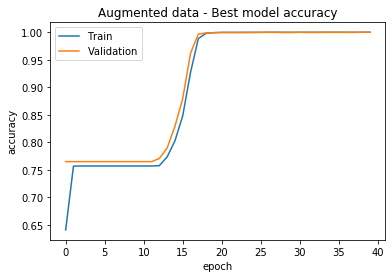

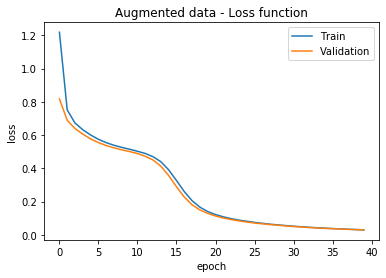

In [38]:
#plot accuracy both for training and validation
plt.plot(fit.history['accuracy'])
plt.plot(fit.history['val_accuracy'])
plt.title('Augmented data - Best model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Validation'])
plt.show()

#plot loss function
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.title('Augmented data - Loss function')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Validation'])
plt.show()

In [41]:
print(best_activations, best_dropout, best_optimizer, best_regular)
print(seed, batch_size, epoch, folds)

print(fit.history['accuracy'][-1])
print(fit.history['val_accuracy'][-1])

sigmoid 0.15 Nadam 0.05
1234 50 40 10
1.0
1.0


In [45]:
loaded = load_model(filepath='WASC_parameters_A.h5', compile=True )

In [46]:
loaded.summary()

Model: "sequential_730"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2920 (Dense)           (None, 63)                4032      
_________________________________________________________________
dense_2921 (Dense)           (None, 31)                1984      
_________________________________________________________________
dense_2922 (Dense)           (None, 15)                480       
_________________________________________________________________
dropout_730 (Dropout)        (None, 15)                0         
_________________________________________________________________
dense_2923 (Dense)           (None, 1)                 16        
Total params: 6,512
Trainable params: 6,512
Non-trainable params: 0
_________________________________________________________________


In [47]:
np.shape(data_augmented[:,0])

x = [[i for i in j] for j in data_augmented[:,0]]
np.shape(x)

predicted = loaded.predict(np.array(x))
predicted = np.reshape(np.around(predicted), (len(data_augmented),))
predicted = predicted.astype(int)

# sigmoid 0.2 Nadam 0.05

In [48]:
import sklearn
print(sklearn.__version__)
print(data_augmented[:,1], predicted)

0.22.1
[0 0 0 ... 0 1 0] [0 0 0 ... 0 1 0]


In [49]:
y_true = data_augmented[:,1].astype(int)
y_predicted = predicted

np.unique(y_true)

array([0, 1])

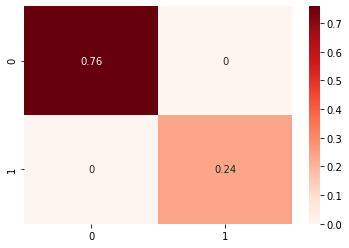

In [51]:

import seaborn as sns



conf_matr = sklearn.metrics.confusion_matrix(y_true, 
                                             y_predicted,
                                            normalize = 'all')
sns.heatmap(conf_matr, annot = True, cmap = 'Reds')